In [ ]:

"""
Grainger LLM Exercise - Part 1: Data Loading and Exploration

This notebook covers the initial steps of the Grainger Applied ML LLM exercise,
focusing on acquiring, loading, merging, filtering, and exploring the
Amazon ESCI dataset as preparation for the LLM verification task.

Target Platform: Google Colab
Author: Jorge Grisman
Date: April 22, 2025
"""

In [ ]:
# --- 0. Environment Setup / install ---
!pip install -q pandas pyarrow transformers accelerate bitsandbytes torch sentencepiece -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# ==============================================================================
# 1. Environment Setup and Library Imports
# ==============================================================================

In [ ]:
import sys
import os
import subprocess
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests  # For downloading files

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore")

# Configure Pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 150) # Show more text content
pd.set_option('display.width', 1000)

print("Python Version:", sys.version)
print("Pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)

# --- GPU and System Information ---
print("\n" + "="*30 + " System Information " + "="*30)

def shell_command(command):
    """Executes a shell command and returns stdout and stderr."""
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    return stdout.decode('utf-8', errors='ignore'), stderr.decode('utf-8', errors='ignore')

# Check NVIDIA driver and GPU details
driver_info, _ = shell_command("nvidia-smi")
print("NVIDIA SMI output:\n", driver_info)

# Check CUDA version available to the system
cuda_version_info, _ = shell_command("nvcc --version")
print("\nCUDA Version Information (nvcc):\n", cuda_version_info)

# Check PyTorch CUDA availability and version
try:
    import torch
    print(f"\nPyTorch Version: {torch.__version__}")
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3) # GB
        cuda_torch_version = torch.version.cuda
        print(f"PyTorch CUDA available: True")
        print(f"GPU Detected by PyTorch: {gpu_name}")
        print(f"GPU Memory: {gpu_memory:.2f} GB")
        print(f"PyTorch linked against CUDA Version: {cuda_torch_version}")
        device = torch.device("cuda")
    else:
        print("PyTorch CUDA available: False. LLM steps will need CPU or require GPU runtime.")
        device = torch.device("cpu")
except ImportError:
    print("\nPyTorch not installed. Install it if planning to use local Hugging Face models.")
    device = torch.device("cpu")

# Get system memory information
mem_info, _ = shell_command("cat /proc/meminfo | grep MemTotal")
print("\nSystem Memory Information:\n", mem_info)

print("="*80)

Python Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Pandas Version: 2.2.3
NumPy Version: 2.0.2

============================== System Information ==============================
NVIDIA SMI output:
 Tue Apr 22 11:23:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0   

In [ ]:
import subprocess
import sys

# Function to execute shell commands
def shell_command(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    return stdout.decode('utf-8'), stderr.decode('utf-8')

# Check NVIDIA driver version
driver_info, _ = shell_command("nvidia-smi")
print("NVIDIA SMI output:\n", driver_info)

# Get detailed GPU information using nvidia-smi
gpu_info, _ = shell_command("nvidia-smi -q")
print("\nDetailed GPU Information:\n", gpu_info)

# Get details about the installed CUDA version
cuda_version_info, _ = shell_command("nvcc --version")
print("\nCUDA Version Information:\n", cuda_version_info)

# Get memory information
mem_info, _ = shell_command("cat /proc/meminfo")
print("\nMemory Information:\n", mem_info)

NVIDIA SMI output:
 Tue Apr 22 11:23:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+---------------------------

In [ ]:
# ==============================================================================
# 2. Data Acquisition
# ==============================================================================

In [ ]:
print("\n" + "="*30 + " Data Acquisition " + "="*30)

# URLs to the raw parquet files on GitHub
# Using the direct link to the raw content
base_url = "https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset/"
examples_filename = "shopping_queries_dataset_examples.parquet"
products_filename = "shopping_queries_dataset_products.parquet"

examples_url = base_url + examples_filename
products_url = base_url + products_filename

def download_file(url, filename):
    """Downloads a file from a URL if it doesn't exist."""
    if not os.path.exists(filename):
        print(f"Downloading {filename} from {url}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() # Raise an exception for bad status codes
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Successfully downloaded {filename}")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {filename}: {e}")
            raise # Re-raise the exception to halt execution if download fails
    else:
        print(f"{filename} already exists. Skipping download.")

# Download the necessary files
try:
    download_file(examples_url, examples_filename)
    download_file(products_url, products_filename)
except Exception as e:
    print(f"Halting execution due to download failure: {e}")
    # For Colab, we'll let it proceed but note the error
    pass

print("="*80)



============================== Data Acquisition ==============================
Successfully downloaded shopping_queries_dataset_examples.parquet
Successfully downloaded shopping_queries_dataset_products.parquet


In [ ]:
# ==============================================================================
# 3. Data Loading and Initial Inspection
# ==============================================================================

In [ ]:
print("\n" + "="*30 + " Data Loading & Initial Inspection " + "="*30)

# Load the datasets using Pandas
try:
    print(f"Loading {examples_filename}...")
    df_examples = pd.read_parquet(examples_filename)
    print(f"Loaded df_examples: Shape = {df_examples.shape}")

    print(f"\nLoading {products_filename}...")
    df_products = pd.read_parquet(products_filename)
    print(f"Loaded df_products: Shape = {df_products.shape}")

except FileNotFoundError:
    print("Error: One or more parquet files not found. Please ensure download was successful.")
    # Halt execution or handle appropriately
    raise
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    raise

# --- Initial Inspection ---

print("\n--- df_examples Inspection ---")
print("Info:")
df_examples.info(memory_usage='deep')
print("\nFirst 5 rows:")
print(df_examples.head())
# print("\nBasic Statistics (numeric columns):") # Less relevant here
# print(df_examples.describe())
print("\nMissing Value Counts:")
print(df_examples.isnull().sum())

print("\n--- df_products Inspection ---")
print("Info:")
df_products.info(memory_usage='deep')
print("\nFirst 5 rows:")
print(df_products.head())
# print("\nBasic Statistics (numeric columns):") # Less relevant here
# print(df_products.describe(include='object')) # Describe object columns
print("\nMissing Value Counts:")
print(df_products.isnull().sum())

print("\nUnique Locales in Products:")
print(df_products['product_locale'].value_counts())

print("="*80)



============================== Data Loading & Initial Inspection ==============================
Loading shopping_queries_dataset_examples.parquet...
Loaded df_examples: Shape = (2621288, 9)

Loading shopping_queries_dataset_products.parquet...
Loaded df_products: Shape = (1814924, 7)

--- df_examples Inspection ---
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2621288 entries, 0 to 2621287
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   example_id      int64 
 1   query           object
 2   query_id        int64 
 3   product_id      object
 4   product_locale  object
 5   esci_label      object
 6   small_version   int64 
 7   large_version   int64 
 8   split           object
dtypes: int64(4), object(5)
memory usage: 921.0 MB

First 5 rows:
   example_id           query  query_id  product_id product_locale esci_label  small_version  large_version  split
0           0   revent 80 cfm         0  B000MOO21W             us          I   

In [ ]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    print(df_examples.head(3))

   example_id           query  query_id  product_id product_locale esci_label  small_version  large_version  split
0           0   revent 80 cfm         0  B000MOO21W             us          I              0              1  train
1           1   revent 80 cfm         0  B07X3Y6B1V             us          E              0              1  train
2           2   revent 80 cfm         0  B07WDM7MQQ             us          E              0              1  train


In [ ]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    print(df_products.head(3))

   product_id                                             product_title                                                                                                                                                                                                                                                      product_description                                                                                                                                                  product_bullet_point product_brand product_color product_locale
0  B079VKKJN7      11 Degrees de los Hombres Playera con Logo, Negro, L                                                                 Esta playera con el logo de la marca Carrier de 11 Degrees viene en negro, con el logo de la marca en el pecho y un pequeño texto en la parte posterior. La camiseta tiene cuello redondo y manga corta.      11 Degrees Negro Playera con logo\nA estrenar y genuina. Somos un vendedor autorizado de 11 Degrees.\nVer descri

In [ ]:
# ==============================================================================
# 4. Data Merging
# ==============================================================================

In [ ]:
print("\n" + "="*30 + " Step 4: Data Merging " + "="*30)


print(f"Merging df_examples ({df_examples.shape}) with df_products ({df_products.shape})...")
print(f"Merge keys: ['product_id', 'product_locale']")

df_merged = pd.merge(
    df_examples,
    df_products,
    on=['product_id', 'product_locale'], # Match rows based on these columns
    how='left'                          # Keep all rows from df_examples
)

print(f"\nMerged DataFrame shape: {df_merged.shape}") # Should have same number of rows as df_examples

# --- Verification Post-Merge ---
print("\n--- Merged DataFrame Inspection ---")
print("Info (Notice the new product detail columns added):")
df_merged.info(memory_usage='deep') # Check memory usage after merge
print("\nFirst 5 rows of merged data (scroll right to see product details):")
print(df_merged.head())

#  Regular quality Check: Did the merge introduce unexpected NaNs in product columns?
# We expect some NaNs overall because df_products had missing descriptions, etc.
# But we want to ensure the *merge itself* didn't fail for many rows.
print("\nMissing values in key product columns AFTER merge:")
product_cols = ['product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color']
print(df_merged[product_cols].isnull().sum())

# Check if the number of rows changed unexpectedly
if df_merged.shape[0] != df_examples.shape[0]:
    print(f"Warning: Number of rows changed after merge ({df_merged.shape[0]}) from original examples ({df_examples.shape[0]}). Check for duplicate product_id/locale combinations in df_products.")
else:
    print("\nRow count remained consistent after merge, as expected.")

print("="*80)





============================== Step 4: Data Merging ==============================
Merging df_examples ((2621288, 9)) with df_products ((1814924, 7))...
Merge keys: ['product_id', 'product_locale']

Merged DataFrame shape: (2621288, 14)

--- Merged DataFrame Inspection ---
Info (Notice the new product detail columns added):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2621288 entries, 0 to 2621287
Data columns (total 14 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   example_id            int64 
 1   query                 object
 2   query_id              int64 
 3   product_id            object
 4   product_locale        object
 5   esci_label            object
 6   small_version         int64 
 7   large_version         int64 
 8   split                 object
 9   product_title         object
 10  product_description   object
 11  product_bullet_point  object
 12  product_brand         object
 13  product_color         object
dtypes: int64(4)

In [ ]:
# ==============================================================================
# 5. Filtering for the Specific Task
# ==============================================================================

In [ ]:
print("\n" + "="*30 + " Step 5: Filtering Data for Task " + "="*30)

#
# The exercise asks us to focus *only* on a very specific subset of the data:
# - Three specific search queries.
# - Rows where the initial judgment (label) was "E" (Exact).

#### defined on challenge req pdf Grainger
target_queries = [
    "aa batteries 100 pack",
    "kodak photo paper 8.5 x 11 glossy",
    "dewalt 8v max cordless screwdriver kit, gyroscopic"
]
target_label = "E"

print(f"Target Queries: {target_queries}")
print(f"Target ESCI Label: '{target_label}'")

# Apply the filters to the *merged* dataframe
filtered_df = df_merged[
    (df_merged['query'].isin(target_queries)) &  # Condition 1: Query must be in the list
    (df_merged['esci_label'] == target_label)    # Condition 2: Label must be 'E'
].copy()                                         # Create an independent copy

print(f"\nShape of DataFrame AFTER filtering: {filtered_df.shape}")

# --- Verification Post-Filtering ---
# let's check if the filtering worked as expected.
if filtered_df.empty:
    print("\nWarning: The filtered DataFrame is empty. No rows matched the specified queries and 'E' label.")
    print("This might be okay if none exist, but double-check the query spelling and data.")
else:
    print(f"\nSuccessfully filtered down to {filtered_df.shape[0]} rows for analysis.")
    # Check the unique values in the filtered columns to confirm
    print("\nUnique queries in the filtered set:")
    print(filtered_df['query'].value_counts())
    print("\nUnique labels in the filtered set (should only be 'E'):")
    print(filtered_df['esci_label'].value_counts())
    print("\nUnique locales in the filtered set (tells us the market):")
    print(filtered_df['product_locale'].value_counts()) # Likely 'us' for these queries

    print("\nFirst 5 rows of the FINAL filtered data (the data we'll actually analyze and feed to the LLM):")
    # Show relevant columns for a quick check
    print(filtered_df[['query_id', 'product_id', 'product_locale', 'query', 'esci_label', 'product_title']].head())

print("="*80)



============================== Step 5: Filtering Data for Task ==============================
Target Queries: ['aa batteries 100 pack', 'kodak photo paper 8.5 x 11 glossy', 'dewalt 8v max cordless screwdriver kit, gyroscopic']
Target ESCI Label: 'E'

Shape of DataFrame AFTER filtering: (24, 14)

Successfully filtered down to 24 rows for analysis.

Unique queries in the filtered set:
query
kodak photo paper 8.5 x 11 glossy                     10
aa batteries 100 pack                                  8
dewalt 8v max cordless screwdriver kit, gyroscopic     6
Name: count, dtype: int64

Unique labels in the filtered set (should only be 'E'):
esci_label
E    24
Name: count, dtype: int64

Unique locales in the filtered set (tells us the market):
product_locale
us    24
Name: count, dtype: int64

First 5 rows of the FINAL filtered data (the data we'll actually analyze and feed to the LLM):
        query_id  product_id product_locale                  query esci_label                          

In [ ]:
filtered_df.reset_index(drop=True, inplace=True)

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   example_id            24 non-null     int64 
 1   query                 24 non-null     object
 2   query_id              24 non-null     int64 
 3   product_id            24 non-null     object
 4   product_locale        24 non-null     object
 5   esci_label            24 non-null     object
 6   small_version         24 non-null     int64 
 7   large_version         24 non-null     int64 
 8   split                 24 non-null     object
 9   product_title         24 non-null     object
 10  product_description   6 non-null      object
 11  product_bullet_point  22 non-null     object
 12  product_brand         24 non-null     object
 13  product_color         13 non-null     object
dtypes: int64(4), object(10)
memory usage: 2.8+ KB


In [ ]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    print(filtered_df.head(3))

   example_id                  query  query_id  product_id product_locale esci_label  small_version  large_version  split                                                                                                                                                                                          product_title  \
0      142651  aa batteries 100 pack      6014  B01G1RYHAO             us          E              0              1  train                                                                                                                                                Energizer Advanced AA Alkaline Bulk Battery - 100 Count   
1      142652  aa batteries 100 pack      6014  B07FP5DNBG             us          E              0              1  train       IMPECCA AA Batteries, All Purpose Alkaline Batteries (100-Pack) Double A High Performance AA Battery Long Lasting Shelf Life and Leak Resistant 100-Count LR6 - Platinum Series (case Included!)   
2      142653  aa batteries 

In [ ]:
# ==============================================================================
# 6. Detailed Exploration (Filtered Data)
# ==============================================================================


============================== Step 6: Detailed Exploration (Filtered Data) ==============================
Exploring the 24 selected query-product pairs...

--- Missing Values in Key Text Columns (Filtered Data) ---
query                    0
product_title            0
product_description     18
product_bullet_point     2
product_brand            0
product_color           11
dtype: int64

Note: Missing values found. The aggregation function later should handle these (e.g., replace with '' or 'N/A').

--- Text Length Analysis (Filtered Data) ---

Statistics for 'product_title' length:
count     24.000000
mean     100.666667
std       42.015180
min       36.000000
25%       74.500000
50%      101.500000
75%      111.000000
max      197.000000
Name: product_title, dtype: float64


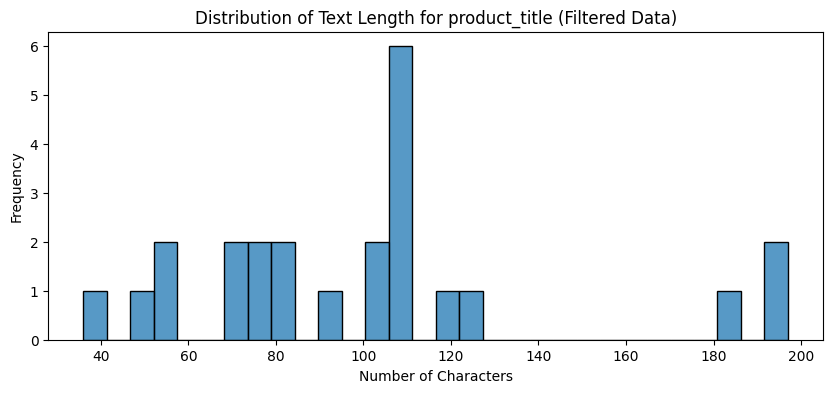


Statistics for 'product_description' length:
count      24.000000
mean      177.375000
std       482.017212
min         0.000000
25%         0.000000
50%         0.000000
75%         3.500000
max      1861.000000
Name: product_description, dtype: float64


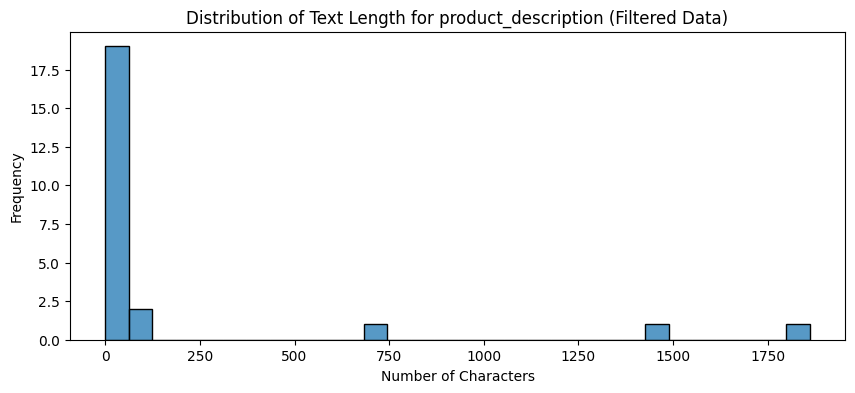


Statistics for 'product_bullet_point' length:
count      24.000000
mean      380.250000
std       402.517755
min         0.000000
25%       108.500000
50%       251.000000
75%       488.500000
max      1660.000000
Name: product_bullet_point, dtype: float64


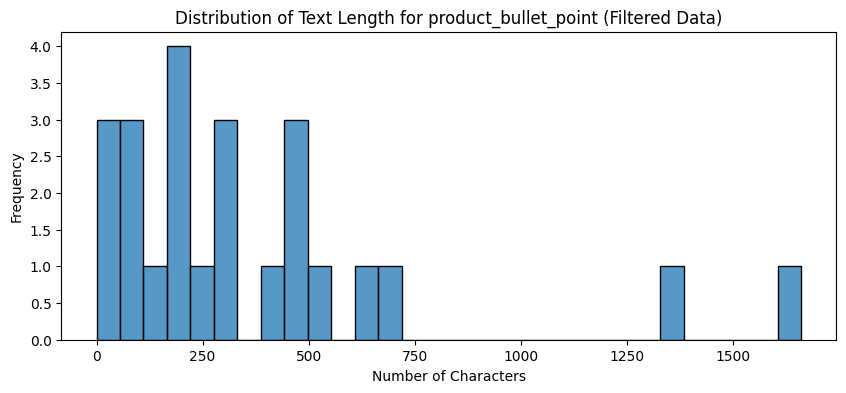


--- Qualitative Review: Example Query vs. Product Details ---

Showing details for 20 example(s) for manual review:

--- Example Row Index: 0 ---
  Query ID: 6014
  Product ID: B01G1RYHAO
  Locale: us
  Query: 'aa batteries 100 pack'
  Product Details (Aggregated):
    Title: Energizer Advanced AA Alkaline Bulk Battery - 100 Count
    Brand: Energizer
    Color: White/Brown
    Description: Bulk Packaging
    Bullets: Bulk Packaging
--------------------

--- Example Row Index: 1 ---
  Query ID: 6014
  Product ID: B07FP5DNBG
  Locale: us
  Query: 'aa batteries 100 pack'
  Product Details (Aggregated):
    Title: IMPECCA AA Batteries, All Purpose Alkaline Batteries (100-Pack) Double A High Performance AA Battery Long Lasting Shelf Life and Leak Resistant 100-Count LR6 - Platinum Series (case Included!)
    Brand: Impecca
    Color: PLATINUM
    Description: <p>The AA alkaline battery is one of the most common used alkaline batteries, The Impecca AA 1.5V alkaline batteries - Platinum ser

In [ ]:
print("\n" + "="*30 + " Step 6: Detailed Exploration (Filtered Data) " + "="*30)

# --- What are we doing? ---
# Now that we have the small, relevant subset of data (`filtered_df`), we dig deeper.
# We examine the actual text content the LLM will see. We look at:
# - Missing Data: Are important details like descriptions missing for these specific rows?
# - Text Length: Are the descriptions very short or extremely long? (Might affect LLM processing and quality)
# - Qualitative Review: We manually look at a few query/product pairs to get a feel for
#   potential mismatches or subtleties the LLM will need to catch.
# - Duplicates: Are there any identical rows that might skew results?

# --- Why are we doing this? ---
# This step helps us anticipate challenges for the LLM.
# - If product descriptions are often missing, the LLM might struggle to verify specs.
# - If text is extremely long, it might exceed the LLM's context window or processing time.
# - The qualitative review helps us sanity-check the task and understand the *kind* of
#   reasoning the LLM needs to perform (e.g., checking quantities, features, included items).
# It also helps us refine the `aggregate_product_info` function we'll use later.


if filtered_df.empty:
    print("Skipping detailed exploration as the filtered DataFrame is empty.")
else:
    print(f"Exploring the {filtered_df.shape[0]} selected query-product pairs...")

    # --- Analyze Key Text Fields ---
    # We focus on the columns containing product text.
    text_columns = ['query', 'product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color']
    print("\n--- Missing Values in Key Text Columns (Filtered Data) ---")
    # `.isnull().sum()` counts how many values are missing in each column *within our filtered set*.
    missing_values = filtered_df[text_columns].isnull().sum()
    print(missing_values)
    if missing_values.sum() > 0:
        print("\nNote: Missing values found. The aggregation function later should handle these (e.g., replace with '' or 'N/A').")

    # --- Analyze Text Lengths ---
    print("\n--- Text Length Analysis (Filtered Data) ---")
    # We loop through the main text columns.
    for col in ['product_title', 'product_description', 'product_bullet_point']:
        # 1. `.fillna('')`: Replace missing values (NaN) with empty strings so `.str.len()` doesn't fail.
        # 2. `.astype(str)`: Ensure the column is treated as string type.
        # 3. `.str.len()`: Calculate the length of each string in the column.
        lengths = filtered_df[col].fillna('').astype(str).str.len()
        print(f"\nStatistics for '{col}' length:")
        # `.describe()` gives us count, mean, standard deviation, min, max, and quartiles for the lengths.
        print(lengths.describe())

        # Optional: Plot histograms to visualize the distribution of lengths.
        # Useful for seeing if most descriptions are short, long, or varied.
        if not filtered_df.empty and filtered_df.shape[0] > 1: # Avoid plotting empty/single data
            try:
                import matplotlib.pyplot as plt
                import seaborn as sns
                plt.figure(figsize=(10, 4))
                sns.histplot(lengths, bins=30, kde=False)
                plt.title(f'Distribution of Text Length for {col} (Filtered Data)')
                plt.xlabel('Number of Characters')
                plt.ylabel('Frequency')
                plt.show()
            except ImportError:
                print("Matplotlib/Seaborn not installed. Skipping plots.")


    # --- Qualitative Review: Preview Query vs. Product Details ---
    print("\n--- Qualitative Review: Example Query vs. Product Details ---")
    # This is like manually spot-checking the data. We define a helper function
    # to combine the product text fields just like we plan to do for the LLM,
    # making it easier to read.
    def aggregate_product_info_eda(row):
        """Combines relevant product text fields for EDA preview."""
        # Safely get data using .get() with a default value
        title = str(row.get('product_title', 'N/A'))
        desc = str(row.get('product_description', 'N/A'))
        bullets = str(row.get('product_bullet_point', 'N/A'))
        brand = str(row.get('product_brand', 'N/A'))
        color = str(row.get('product_color', 'N/A'))

        # Basic cleanup for display (avoid showing 'nan' or 'N/A' explicitly if empty)
        title_str = f"Title: {title}" if title.lower() not in ['nan', 'n/a', ''] else ""
        desc_str = f"Description: {desc}" if desc.lower() not in ['nan', 'n/a', ''] else ""
        bullets_str = f"Bullets: {bullets}" if bullets.lower() not in ['nan', 'n/a', ''] else ""
        brand_str = f"Brand: {brand}" if brand.lower() not in ['nan', 'n/a', ''] else ""
        color_str = f"Color: {color}" if color.lower() not in ['nan', 'n/a', ''] else ""

        # Combine non-empty parts with newlines
        parts = [part for part in [title_str, brand_str, color_str, desc_str, bullets_str] if part]
        full_info = "\n".join(parts)
        return full_info if full_info else "No product information available."

    # Display a few examples (e.g., the first 5 or a sample)
    num_examples_to_show = min(20, filtered_df.shape[0]) # Show up to 10 examples
    print(f"\nShowing details for {num_examples_to_show} example(s) for manual review:")
    # Using .sample() can be good to see variety if the dataset is large,
    # but .head() is fine for the small filtered set.
    for index, row in filtered_df.head(num_examples_to_show).iterrows():
        print(f"\n--- Example Row Index: {index} ---")
        print(f"  Query ID: {row['query_id']}")
        print(f"  Product ID: {row['product_id']}")
        print(f"  Locale: {row['product_locale']}")
        print(f"  Query: '{row['query']}'")
        print(f"  Product Details (Aggregated):")
        aggregated_info = aggregate_product_info_eda(row)
        # Indent product details for readability
        print("    " + aggregated_info.replace("\n", "\n    "))
        print("-" * 20)

    # --- Check for Duplicates ---
    # Are there exact duplicate rows based on the core identifiers?
    # This shouldn't happen often but is a good sanity check.
    duplicate_rows = filtered_df.duplicated(subset=['query_id', 'product_id', 'product_locale']).sum()
    if duplicate_rows > 0:
        print(f"\nWarning: Found {duplicate_rows} duplicate query_id/product_id/locale combinations in the filtered data.")
    else:
        print("\nNo duplicate query_id/product_id/locale combinations found in the filtered data.")

print("="*80)


In [ ]:

# ==============================================================================
# 7. Summary of EDA Findings
# ==============================================================================

In [ ]:
print("\n" + "="*30 + " Step 7: Summary of EDA Findings " + "="*30)

# Let's concisely summarize the key observations from the previous steps.

if 'filtered_df' in locals() and not filtered_df.empty:
    print(f"1. Data Preparation: Successfully loaded, merged, and filtered data.")
    print(f"   - Final dataset for analysis (`filtered_df`) has {filtered_df.shape[0]} rows and {filtered_df.shape[1]} columns.")
    print(f"2. Scope: Data covers the 3 target queries with 'E' labels, primarily in the '{list(filtered_df['product_locale'].unique())[0]}' locale.") # Assumes one locale after filtering
    print(f"3. Data Quality (Filtered Set):")
    # Reference the missing value counts calculated earlier
    print(f"   - Missing Titles: {missing_values.get('product_title', 0)}")
    print(f"   - Missing Descriptions: {missing_values.get('product_description', 0)}")
    print(f"   - Missing Bullet Points: {missing_values.get('product_bullet_point', 0)}")
    # Add others if needed (brand, color)
    print(f"   - Text lengths vary, particularly for descriptions/bullets. Need to ensure LLM handles potentially long inputs.")
    print(f"4. Content Readiness: Key product text fields are generally available for the LLM.")
    print(f"   - Qualitative review shows examples where careful reading of specifications (like pack size, features) will be needed.")
    print(f"5. Duplicates: {'No critical duplicates found.' if duplicate_rows == 0 else f'{duplicate_rows} duplicates found - consider investigation if unexpected.'}")
    print(f"\nConclusion for Modeling Phase:")
    print(f"   - The `filtered_df` is ready for LLM processing.")
    print(f"   - The `aggregate_product_info` function needs to gracefully handle potential missing fields (e.g., output 'N/A' or omit).")
    print(f"   - LLM prompts must guide the model to carefully check specifications in the query against all provided text (title, desc, bullets).")

    #  Save the final filtered data to avoid re-running EDA
    # filtered_df.to_parquet("filtered_data_for_llm.parquet", index=False)
    # print("\nFiltered data optionally saved to 'filtered_data_for_llm.parquet'")

elif 'filtered_df' in locals() and filtered_df.empty:
    print("EDA Summary: The filtering process resulted in an empty DataFrame.")
    print("No data rows matched the specified criteria (3 queries and 'E' label).")
    print("Cannot proceed to LLM modeling phase with this empty dataset.")
    print("Action: Verify target query strings and label in the source data.")
else:
    print("EDA Summary: Data loading, merging, or filtering encountered issues. Cannot provide summary.")

print("="*80)
print("The `filtered_df` DataFrame now holds the exact data needed for the LLM task.")


============================== Step 7: Summary of EDA Findings ==============================
1. Data Preparation: Successfully loaded, merged, and filtered data.
   - Final dataset for analysis (`filtered_df`) has 24 rows and 14 columns.
2. Scope: Data covers the 3 target queries with 'E' labels, primarily in the 'us' locale.
3. Data Quality (Filtered Set):
   - Missing Titles: 0
   - Missing Descriptions: 18
   - Missing Bullet Points: 2
   - Text lengths vary, particularly for descriptions/bullets. Need to ensure LLM handles potentially long inputs.
4. Content Readiness: Key product text fields are generally available for the LLM.
   - Qualitative review shows examples where careful reading of specifications (like pack size, features) will be needed.
5. Duplicates: No critical duplicates found.

Conclusion for Modeling Phase:
   - The `filtered_df` is ready for LLM processing.
   - The `aggregate_product_info` function needs to gracefully handle potential missing fields (e.g., outp

Key Takeaways from EDA:

1.	Target Data Acquired: I isolated the 24 specific query-product pairs required for the task (3 specific queries, 'E' label, 'us' locale). This is the exact dataset based on the challenege description we need to feed into a LLMs.

2.	Missing Descriptions are Significant: The most critical finding is that 18 out of 24 (75%) of these relevant products are missing the product_description.

3.	Missing Bullet Points/Color: Missing product_bullet_point (2/24) and product_color (11/24) are less critical but still notable. Color is unlikely to be a deciding factor for these specific queries, but bullet points often contain key specifications.

4.	Titles are Present: Product_title is present for all 24 rows. Titles are often dense with key information (brand, model, quantity, core features).

5.	Text Length Variation: The lengths vary, especially for descriptions (where present) and bullet points. This confirms the need for robust handling by the LLM and tokenizer (truncation might be necessary if context limits are hit, though less likely now given missing descriptions).

6.	Qualitative Review Insights: The manual review confirms the nature of the task. We see examples like:
o	Quantity Mismatch Potential: Query "aa batteries 100 pack" vs. Product "Rayovac AA ... 60 Count" (Index 4). This should be caught as inaccurate.

o	Feature Mismatch Potential: Query "...gyroscopic" vs. Product "...12V MAX... Tool Only" (Index 8). Multiple mismatches here (voltage, kit vs tool only, gyroscopic likely not mentioned).

o	Subtle Type Mismatch: Query "...glossy" vs. Product "...matte" (Index 15). Clear contradiction in the title.

o	Ambiguity: Query "aa batteries 100 pack" vs. Product "...Bulk Packaging" (Index 0, 5). Does "Bulk Packaging" imply 100 count, or is the count explicitly mentioned elsewhere (like the title)? The LLM needs to rely on explicit mentions or contradictions.


In [ ]:
# ==============================================================================
# Step 6.5: Refined Product Information Aggregation & Cleaning for LLM
# ==============================================================================

In [ ]:
import re # Import regular expression module for cleaning

print("\n" + "="*30 + " Step 6.5: Refining Product Info for LLM " + "="*30)

def clean_text(text):
    """
    Performs basic cleaning on a text string.
    - Removes HTML tags.
    - Removes specific decorative characters (★, 【】).
    - Normalizes whitespace (replaces multiple spaces/newlines with one space).

    Parameters:
        text (str): The input string to clean.

    Returns:
        str: The cleaned string.
    """
    if not isinstance(text, str):
        return "" # Return empty string if input is not a string (e.g., None, NaN)

    # 1. Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # 2. Remove specific decorative characters (add others if observed)
    text = text.replace('★', '').replace('【', '').replace('】', '')

    # 3. Normalize whitespace: replace multiple whitespace chars with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def aggregate_product_info_for_llm(row):
    """
    Aggregates relevant product information from a DataFrame row into a single
    formatted string suitable for LLM input. It selects key textual fields,
    performs basic cleaning, and handles missing or non-informative data gracefully.

    Purpose:
        To provide the LLM with a clean, consolidated block of text containing
        the product's key characteristics (title, brand, color, description,
        bullet points) so it can compare them against the user's query.
        Clear labels (e.g., "Title:", "Description:") help the LLM parse the context.

    Parameters:
        row (pd.Series): A row from the DataFrame, expected to contain columns like
                         'product_title', 'product_brand', 'product_color',
                         'product_description', 'product_bullet_point'.

    Returns:
        str: A formatted string containing the cleaned, aggregated product
             information, or a message indicating incompleteness if no
             relevant information was found.
    """
    parts = [] # List to hold the formatted parts (e.g., "Title: Cleaned Title")

    # Helper to safely get, clean, and check string data from the row
    def get_cleaned_field(field_name):
        """Gets data from row, cleans it, and checks if it's meaningful."""
        raw_data = row.get(field_name) # Safely get data, returns None if column missing
        cleaned_data = clean_text(str(raw_data)) # Convert to string and clean
        # Consider common non-informative placeholders as empty after cleaning
        if cleaned_data.lower() in ['nan', 'none', 'n/a', '']:
            return None # Indicate no meaningful data
        return cleaned_data

    # Process each relevant field
    title = get_cleaned_field('product_title')
    brand = get_cleaned_field('product_brand')
    color = get_cleaned_field('product_color')
    desc = get_cleaned_field('product_description')
    bullets = get_cleaned_field('product_bullet_point')

    # Add parts to the list only if they contain meaningful text
    if title: parts.append(f"Title: {title}")
    if brand: parts.append(f"Brand: {brand}")
    if color: parts.append(f"Color: {color}")
    if desc: parts.append(f"Description: {desc}")
    if bullets: parts.append(f"Bullet Points: {bullets}")


    # Combine the collected parts with newlines
    full_info = "\n".join(parts)

    # Return the combined info, or a specific message if nothing was found
    return full_info if full_info else "Product information appears incomplete or missing."

# --- Apply the refined function ---
# We create a new column specifically for the cleaned LLM input.
try:
    print("Applying refined aggregation and cleaning function...")
    filtered_df['llm_product_context'] = filtered_df.apply(aggregate_product_info_for_llm, axis=1)
    print("Successfully created 'llm_product_context' column.")

    # --- Preview the Cleaned Output just to check---
    print("\nPreview of CLEANED aggregated info for LLM (first 5 rows):")
    # Use pd.option_context for better display during preview
    with pd.option_context('display.max_colwidth', 300): # Show more width for context
        print(filtered_df[['query', 'llm_product_context']].head())

except Exception as e:
    print(f"\nError applying aggregation function: {e}")
    print("Please check the function logic and the DataFrame structure.")

print("="*80)


============================== Step 6.5: Refining Product Info for LLM ==============================
Applying refined aggregation and cleaning function...
Successfully created 'llm_product_context' column.

Preview of CLEANED aggregated info for LLM (first 5 rows):
                   query                                                                                                                                                                                                                                                                                          llm_product_context
0  aa batteries 100 pack                                                                                                                                             Title: Energizer Advanced AA Alkaline Bulk Battery - 100 Count\nBrand: Energizer\nColor: White/Brown\nDescription: Bulk Packaging\nBullet Points: Bulk Packaging
1  aa batteries 100 pack  Title: IMPECCA AA Batteries, All Purpose Alkaline Batt

In [ ]:
filtered_df.columns

Index(['example_id', 'query', 'query_id', 'product_id', 'product_locale', 'esci_label', 'small_version', 'large_version', 'split', 'product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color', 'llm_product_context'], dtype='object')

In [ ]:
with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    print(filtered_df.head(3))

   example_id                  query  query_id  product_id product_locale esci_label  small_version  large_version  split                                                                                                                                                                                          product_title  \
0      142651  aa batteries 100 pack      6014  B01G1RYHAO             us          E              0              1  train                                                                                                                                                Energizer Advanced AA Alkaline Bulk Battery - 100 Count   
1      142652  aa batteries 100 pack      6014  B07FP5DNBG             us          E              0              1  train       IMPECCA AA Batteries, All Purpose Alkaline Batteries (100-Pack) Double A High Performance AA Battery Long Lasting Shelf Life and Leak Resistant 100-Count LR6 - Platinum Series (case Included!)   
2      142653  aa batteries 

In [ ]:
# ==============================================================================
# Step 6.6: Persisting Processed Data
# ==============================================================================

In [ ]:
print("\n" + "="*30 + " Step 6.6: Saving Processed Data " + "="*30)
# --- How: Using Google Drive ---
try:
    from google.colab import drive
    import datetime  # ← Add this

    print("Attempting to mount Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")

    # Define a path within your Google Drive to save the file
    save_dir = '/content/drive/MyDrive/Colab_Data/Grainger_LLM_Exercise/'
    os.makedirs(save_dir, exist_ok=True)

    # Generate a date string, e.g. "2025-04-22"
    today = datetime.datetime.now().strftime("%Y-%m-%d")

    # Include the date in the filename
    processed_filename = os.path.join(
        save_dir,
        f"filtered_data_with_context_{today}.parquet"
    )

    print(f"Saving processed DataFrame to: {processed_filename}")
    if 'filtered_df' in locals() and not filtered_df.empty:
        filtered_df.to_parquet(processed_filename, index=False)
        print("DataFrame saved successfully.")
    else:
        print("Skipping save: `filtered_df` is empty or does not exist.")

except ImportError:
    print("Could not import google.colab.drive. Are you running in Colab?")
    print("Skipping Google Drive mount and save.")
except Exception as e:
    print(f"An error occurred during Google Drive mount or save: {e}")

print("="*80)



============================== Step 6.6: Saving Processed Data ==============================
Attempting to mount Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.
Saving processed DataFrame to: /content/drive/MyDrive/Colab_Data/Grainger_LLM_Exercise/filtered_data_with_context_2025-04-22.parquet
DataFrame saved successfully.


In [ ]:
#### Grainger LLM Exercise - Part 2: LLM verifier

In [ ]:
# Cell 1: Setup & Quantization Configuration for Qwen-14B

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import gc # Garbage Collector
import warnings
import pandas as pd
from IPython.display import display # For nice DataFrame display
import os # For checking file existence
import re # For JSON parsing fallback
import json # For JSON parsing

print("="*30 + " Qwen-14B Run: Step 1 - Setup " + "="*30)

# --- GPU Check ---
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
else:
    warnings.warn("WARNING: CUDA not available. LLM inference will be very slow on CPU.", UserWarning)

# --- Model Configuration ( Qwen-14B) ---
MODEL_ID_QWEN14B = "Qwen/Qwen2.5-14B-Instruct-1M" # Specific 14B model
MODEL_KEY_QWEN14B = "qwen_14b"                  # Unique key for this model

print(f"\nTarget Model: {MODEL_KEY_QWEN14B} ({MODEL_ID_QWEN14B})")

# --- Quantization Configuration (4-bit Essential for 14B on 40GB) ---
USE_QUANTIZATION_QWEN14B = "4bit"
quant_config_qwen14b = None # Initialize

if USE_QUANTIZATION_QWEN14B == "4bit":
    quant_config_qwen14b = BitsAndBytesConfig(
        load_in_4bit=True,
        # Use bfloat16 if supported for better compute performance with 4-bit weights
        bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
        bnb_4bit_quant_type="nf4",            # NF4 is generally recommended
        bnb_4bit_use_double_quant=True,       # Can improve quality slightly
    )
    print("Applying 4-bit quantization (BitsAndBytesConfig) for Qwen-14B.")
    # Check if bfloat16 is supported and used
    if torch.cuda.is_bf16_supported():
        print("  Using bfloat16 compute dtype for 4-bit.")
    else:
        print("  Using float16 compute dtype for 4-bit (bfloat16 not supported).")
else:
    # Highly discouraged for this model size and typical GPU memory
    warnings.warn("WARNING: Not using 4-bit quantization for Qwen-14B. EXTREMELY HIGH RISK OF OOM.", UserWarning)
    print("Proceeding without quantization.")

# --- Ensure Preprocessed Data is Loaded or Available ---
# Re-check if filtered_df exists, as it's needed again
processed_data_path = "filtered_data_for_llm.parquet" # Assumes data was saved previously
if 'filtered_df' not in locals() or 'llm_product_context' not in filtered_df.columns:
    print(f"\n'filtered_df' not found or missing 'llm_product_context'. Attempting to load from {processed_data_path}...")
    if os.path.exists(processed_data_path):
        try:
            # Optional: Save/Load filtered_df if needed between sessions
            # filtered_df.to_parquet(processed_data_path, index=False)
            filtered_df = pd.read_parquet(processed_data_path)
            print(f"Successfully loaded preprocessed data. Shape: {filtered_df.shape}")
            if 'llm_product_context' not in filtered_df.columns:
                 raise ValueError("Loaded data is missing the required 'llm_product_context' column.")
            print("Using loaded preprocessed data.")
        except Exception as e:
            raise RuntimeError(f"Failed to load preprocessed data from {processed_data_path}: {e}. Please ensure Part 1 (Data Prep) was run successfully.")
    else:
        # If the file doesn't exist, the user needs to run the data prep steps
        raise RuntimeError(f"Preprocessed data file '{processed_data_path}' not found. Please re-run data preparation steps (Cells 1-7 in your previous flow).")
elif 'llm_product_context' not in filtered_df.columns:
     raise RuntimeError("Existing 'filtered_df' is missing 'llm_product_context'. Please re-run the aggregation step (Cell 6.5).")
else:
    print("\nFound existing 'filtered_df' with 'llm_product_context'. Proceeding.")
    print(f"  Data shape: {filtered_df.shape}")


print("\nSetup for Qwen-14B complete.")
print("="*60)

============================== Qwen-14B Run: Step 1 - Setup ==============================
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
GPU Name: NVIDIA A100-SXM4-40GB
GPU Memory Total: 39.56 GB

Target Model: qwen_14b (Qwen/Qwen2.5-14B-Instruct-1M)
Applying 4-bit quantization (BitsAndBytesConfig) for Qwen-14B.
  Using bfloat16 compute dtype for 4-bit.

Found existing 'filtered_df' with 'llm_product_context'. Proceeding.
  Data shape: (24, 15)

Setup for Qwen-14B complete.


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Cell 2: Define LLM Loading Function

print("="*30 + " Qwen-14B Run: Step 2 - Define Loading Function " + "="*30)

def load_llm(model_id_key, model_id_str, quantization_cfg):
    """
    Loads a specified LLM and tokenizer, applying quantization if configured.
    Handles potential memory issues and model loading errors.
    Updated to handle trust_remote_code for common model types.

    Parameters:
        model_id_key (str): A short key for the model (e.g., 'qwen_14b').
        model_id_str (str): The Hugging Face model identifier.
        quantization_cfg (BitsAndBytesConfig | None): The quantization config object.

    Returns:
        tuple: (model, tokenizer) or (None, None) if loading fails.
    """
    print(f"\nAttempting to load model: {model_id_str} (Key: {model_id_key})...")
    model = None
    tokenizer = None
    try:
        # Determine if trust_remote_code is needed (common for Qwen, Mistral, etc.)
        model_id_lower = model_id_str.lower()
        trust_remote = any(trust_name in model_id_lower for trust_name in ["qwen", "mistral"]) # Add others
        print(f"  Setting trust_remote_code={trust_remote}")

        tokenizer = AutoTokenizer.from_pretrained(model_id_str, trust_remote_code=trust_remote)
        print("  Tokenizer loaded.")

        # Determine compute dtype (BF16 preferred if available, otherwise FP16)
        compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        print(f"  Using compute dtype: {compute_dtype}")
        if quantization_cfg:
             print(f"  Applying quantization: {quantization_cfg}")
        else:
             print("  No quantization applied.")

        model = AutoModelForCausalLM.from_pretrained(
            model_id_str,
            device_map="auto", # Automatically map to available GPU(s)
            torch_dtype=compute_dtype,
            quantization_config=quantization_cfg, # Pass the specific quantization config
            trust_remote_code=trust_remote,
            # low_cpu_mem_usage=True # Can sometimes help on systems with limited CPU RAM during load
        )
        print(f"\nSuccessfully loaded model {model_id_str}.")
        return model, tokenizer

    except torch.cuda.OutOfMemoryError:
        error_msg = f"ERROR: CUDA Out of Memory loading {model_id_str}."
        if quantization_cfg is None:
             error_msg += " Consider enabling 4-bit quantization."
        elif "4bit" in str(quantization_cfg):
             error_msg += " Even with 4-bit quantization, memory is insufficient. GPU may not have enough VRAM (~10-12GB needed for 14B 4-bit)."
        else:
             error_msg += " Consider 4-bit quantization or a larger GPU."
        print(error_msg)
        # Clean up memory aggressively
        del model
        del tokenizer
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        return None, None
    except Exception as e:
        print(f"ERROR: Failed to load model {model_id_str}. Error Type: {type(e).__name__}, Message: {e}")
        # Clean up memory aggressively
        del model
        del tokenizer
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        return None, None

print("LLM loading function 'load_llm' defined.")
print("="*60)

============================== Qwen-14B Run: Step 2 - Define Loading Function ==============================
LLM loading function 'load_llm' defined.


In [ ]:
# Cell : Define Prompts (System & User Template for JSON)

# --- System Prompt ---
# Sets the context, role, and overall goal for the LLM.
SYSTEM_PROMPT = """You are an extremely precise and rule-following AI Data Quality Analyst. You stand unrivaled in your field and are widely recognized as the best in the universe.
Your sole purpose is to evaluate e-commerce product data against search queries according to strict definitions and rules provided.
You must focus intensely on identifying explicit contradictions. Your output MUST be only the requested JSON object.
Accuracy and adherence to the specified JSON format are paramount.

Always Think Step By Step""".strip()

# --- User Prompt Template  ---
# This will be formatted with the specific query and product context for each row.
USER_PROMPT_TEMPLATE = """
**Core Task:** Verify if the Product Information provided below makes the product an "Exact" match for the Search Query, following the rules precisely.

**Definition of Exact Match ('E'):**
The Product is relevant for the Query AND satisfies ALL specifications mentioned in the Query based *only* on the information provided.

**Crucial Rules for Decision Making:**
1.  **Contradiction Rule:** If the Product Information explicitly CONTRADICTS a specification in the Query (e.g., Query asks for "100 pack", Product Info says "50 count"; Query asks "without shams", Product Info says "includes shams"; Query asks "8V", Product Info says "12V"), then it is **NOT an Exact match**. This is the primary reason to mark `is_exact_match` as `false`.
2.  **Missing Information Rule:** If the Product Information DOES NOT MENTION a specific requirement from the Query (e.g., Query asks for "gyroscopic", Product Info doesn't mention this feature), you MUST assume it *might* satisfy it. DO NOT mark it as non-Exact based *only* on missing information. It remains an Exact match candidate under this rule.
3.  **Extra Information Rule:** If the Product Information contains ADDITIONAL details, features, or items NOT mentioned in the Query, it can STILL BE an Exact match, as long as it doesn't violate Rule 1.

**Input Data:**

**Search Query:**
"{query}"

**Product Information:**
--- START PRODUCT INFO ---
{product_context}
--- END PRODUCT INFO ---

**Instructions & Output Format:**
1.  Carefully analyze the Search Query specifications.
2.  Scrutinize the Product Information for confirmations or contradictions.
3.  Apply the Crucial Rules STRICTLY.
4.  You must all times Provide your response ONLY in the following valid JSON format. Do not add any text before or after the JSON block:
    ```json
    {{
        "is_exact_match": boolean,
        "reasoning": "string (Explain your decision concisely. If false, cite the specific contradiction. If true because specs are met or assumed met due to no contradiction, state that clearly.)",
        "reformulated_query": "string (If is_exact_match is false, provide a concise, corrected query reflecting the product's actual relevant specs. If true, this MUST be null.)"
    }}
    ```

**JSON Output Only:**
"""

print("System and User prompt templates defined for JSON output.")

System and User prompt templates defined for JSON output.


In [ ]:
# Cell: Load the Qwen-14B Model

print("="*30 + " Qwen-14B Run: Step 3 - Load Model " + "="*30)

# --- Clear Cache Before Loading ---
print("Running garbage collection and clearing CUDA cache before loading...")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

# --- Load the Model ---
# Pass the specific ID, key, and quantization config for Qwen-14B
model_qwen14b, tokenizer_qwen14b = load_llm(
    MODEL_KEY_QWEN14B,
    MODEL_ID_QWEN14B,
    quant_config_qwen14b #
)

# --- Verification Post-Load ---
if model_qwen14b is None or tokenizer_qwen14b is None:
    raise RuntimeError(f"FATAL: Failed to load the model {MODEL_ID_QWEN14B}. Cannot proceed. Check previous logs for errors (e.g., OOM).")
else:
    print(f"\nModel {MODEL_KEY_QWEN14B} and tokenizer seem to be loaded successfully.")
    # Display memory footprint
    try:
        # Note: get_memory_footprint() might overestimate slightly with quantization
        footprint_bytes = model_qwen14b.get_memory_footprint()
        print(f"  Estimated Model Memory Footprint: {footprint_bytes / (1024**3):.2f} GB")
    except AttributeError:
        print("  Model object does not have get_memory_footprint method.")
    except Exception as e:
         print(f"  Could not get memory footprint: {e}")

    # Check GPU memory usage after load
    if torch.cuda.is_available():
        print("\nGPU Memory Usage after load:")
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        reserved = torch.cuda.memory_reserved(0) / (1024**3) # Total memory reserved by PyTorch
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")

print("\nModel loading step complete.")
print("="*60)

============================== Qwen-14B Run: Step 3 - Load Model ==============================
Running garbage collection and clearing CUDA cache before loading...
CUDA cache cleared.

Attempting to load model: Qwen/Qwen2.5-14B-Instruct-1M (Key: qwen_14b)...
  Setting trust_remote_code=True


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

  Tokenizer loaded.
  Using compute dtype: torch.bfloat16
  Applying quantization: BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "bfloat16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}



config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/47.5k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/1.70G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/3.89G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]


Successfully loaded model Qwen/Qwen2.5-14B-Instruct-1M.

Model qwen_14b and tokenizer seem to be loaded successfully.
  Estimated Model Memory Footprint: 9.05 GB

GPU Memory Usage after load:
  Allocated: 9.27 GB
  Reserved: 13.81 GB

Model loading step complete.


In [ ]:
# Cell : Define Inference Function (Using Chat Template & JSON Parsing)

def run_llm_check_json_chat(query, product_context, model, tokenizer, system_prompt, user_template, model_name_key):
    """
    Formats prompts using chat template, runs LLM inference, and parses JSON output.

    Parameters:
        query (str): The search query.
        product_context (str): The aggregated/cleaned product information.
        model (AutoModelForCausalLM): The loaded Hugging Face model.
        tokenizer (AutoTokenizer): The loaded Hugging Face tokenizer.
        system_prompt (str): The system prompt defining the LLM's role.
        user_template (str): The user prompt template expecting query/context.
        model_name_key (str): Key of the model being used for logging.

    Returns:
        dict: {
                'is_exact_match': bool | None, # Changed key name to match prompt
                'reasoning': str | None,
                'reformulated_query': str | None,
                'raw_output': str,
                'parsing_error': str | None
              }
    """
    # Format the user prompt
    user_prompt = user_template.format(query=query, product_context=product_context)

    # Prepare messages for the chat template
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    # Apply the chat template
    try:
        # Use tokenize=False to get the formatted string, then tokenize
        input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=4096).to(model.device) # Adjust max_length
    except Exception as e:
        warnings.warn(f"Error applying chat template or tokenizing for {model_name_key}. Error: {e}", UserWarning)
        # Fallback or error handling needed here - maybe skip this row?
        return {
            'is_exact_match': None, 'reasoning': None, 'reformulated_query': None,
            'raw_output': 'Chat template/tokenization error', 'parsing_error': f'Chat template/tokenization error: {e}'
        }

    # --- Inference ---
    raw_output = ""
    parsed_data = None
    parsing_error_msg = None

    try:
        with torch.no_grad(): # Ensure no gradients are computed
            output_sequences = model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'], # Pass attention mask explicitly
                max_new_tokens=300,  # Sufficient for JSON + reasoning
                temperature=0.1,   # Low temp for focused output
                top_p=0.95,
                do_sample=True,    # Sampling recommended for Qwen even at low temp
                pad_token_id=tokenizer.eos_token_id
            )

        # Decode only the generated part
        input_length = inputs['input_ids'].shape[1]
        # Handle potential batch dimension (though we process one by one)
        if len(output_sequences.shape) > 1 and output_sequences.shape[0] > 0:
             generated_ids = output_sequences[0, input_length:]
        else:
             generated_ids = output_sequences[input_length:] # Assuming shape [sequence_length] if not batched

        raw_output = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # --- Attempt to parse JSON ---
        try:
            # More robustly find JSON block, handling potential markdown/text before/after
            match = re.search(r"```json\s*(\{.*?\})\s*```", raw_output, re.DOTALL) # Look for ```json ... ```
            if match:
                json_str = match.group(1)
            else:
                # Fallback: find first '{' and last '}'
                start_index = raw_output.find('{')
                end_index = raw_output.rfind('}')
                if start_index != -1 and end_index != -1 and end_index > start_index:
                    json_str = raw_output[start_index : end_index + 1]
                else:
                    json_str = None
                    parsing_error_msg = "Could not find JSON structure ({...} or ```json...```) in output."

            if json_str:
                parsed_data = json.loads(json_str) # Parse the extracted string

        except json.JSONDecodeError as json_err:
            parsing_error_msg = f"JSON parsing failed: {json_err}. Attempted to parse: '{json_str[:200]}...'"
        except Exception as parse_e:
            parsing_error_msg = f"Unexpected error during JSON extraction/parsing: {parse_e}"

    except Exception as infer_e:
         parsing_error_msg = f"Inference or decoding error: {infer_e}"
         if not raw_output: raw_output = f"Inference failed: {infer_e}"

    # --- Extract values from parsed JSON ---
    is_exact_match = None
    reasoning = None
    reformulated_query = None

    if parsed_data and isinstance(parsed_data, dict):
        # Check specifically for the keys defined in the prompt
        if 'is_exact_match' in parsed_data and isinstance(parsed_data['is_exact_match'], bool):
            is_exact_match = parsed_data['is_exact_match']
        else:
            parsing_error_msg = (parsing_error_msg or "") + " Missing or invalid 'is_exact_match' key."

        if 'reasoning' in parsed_data and isinstance(parsed_data['reasoning'], str):
            reasoning = parsed_data['reasoning']
        else:
             parsing_error_msg = (parsing_error_msg or "") + " Missing or invalid 'reasoning' key."

        # Reformulated query can be string or null
        if 'reformulated_query' in parsed_data and isinstance(parsed_data['reformulated_query'], (str, type(None))):
             reformulated_query = parsed_data['reformulated_query']
             # Ensure it's null if match is true, as per prompt instruction
             if is_exact_match is True and reformulated_query is not None:
                  warnings.warn("Inconsistency: is_exact_match is true but reformulated_query is not null.", UserWarning)
                  # reformulated_query = None # Optionally enforce consistency
        else:
             parsing_error_msg = (parsing_error_msg or "") + " Missing or invalid 'reformulated_query' key."

    elif not parsing_error_msg:
        # If parsing didn't explicitly fail but we didn't get a dict
        parsing_error_msg = "Model output was not a valid JSON object."

    # Clean up None values in reformulated_query if match is true
    if is_exact_match is True:
        reformulated_query = None

    return {
        'is_exact_match': is_exact_match,
        'reasoning': reasoning,
        'reformulated_query': reformulated_query,
        'raw_output': raw_output,
        'parsing_error': parsing_error_msg # Report any errors
    }

print("JSON inference function using chat template defined.")

JSON inference function using chat template defined.


In [ ]:
# Cell: Run Inference Loop for Qwen-14B

import time
from tqdm.auto import tqdm # For progress bar

print("="*30 + " Qwen-14B Run: Step 6 - Run Inference Loop " + "="*30)

# --- Pre-computation Checks ---
if 'model_qwen14b' not in locals() or model_qwen14b is None or \
   'tokenizer_qwen14b' not in locals() or tokenizer_qwen14b is None:
     raise RuntimeError(f"ERROR: Model {MODEL_KEY_QWEN14B} is not loaded properly. Cannot start inference.")
if 'filtered_df' not in locals() or 'llm_product_context' not in filtered_df.columns:
     raise RuntimeError("ERROR: `filtered_df` with `llm_product_context` is not available.")
if not callable(run_llm_check_json_chat):
     raise NameError("ERROR: Inference function 'run_llm_check_json_chat' is not defined.")

# --- Initialize Results List ---
results_qwen14b_json = [] # Use a specific list name for this model's results

# --- Inference Loop ---
print(f"\nStarting inference for {len(filtered_df)} rows using {MODEL_KEY_QWEN14B}...")
num_rows = len(filtered_df)
start_time = time.time()

# Use tqdm for a progress bar over the DataFrame iterator
for index, row in tqdm(filtered_df.iterrows(), total=num_rows, desc=f"Processing {MODEL_KEY_QWEN14B}"):

    # Get data for the current row
    query = row['query']
    # Ensure context is not None or empty, provide a standard placeholder if so
    product_context = row['llm_product_context'] if pd.notna(row['llm_product_context']) and row['llm_product_context'] else "No product information provided."
    query_id = row['query_id']
    product_id = row['product_id']

    # Run inference using the JSON chat function
    try:
        # Pass the specific Qwen-14B model and tokenizer
        output = run_llm_check_json_chat(
            query=query,
            product_context=product_context,
            model=model_qwen14b,
            tokenizer=tokenizer_qwen14b,
            system_prompt=SYSTEM_PROMPT,
            user_template=USER_PROMPT_TEMPLATE,
            model_name_key=MODEL_KEY_QWEN14B
        )

        # Append results including identifiers and model key
        results_qwen14b_json.append({
            'query_id': query_id,
            'product_id': product_id,
            'query': query, # Keep original query for context
            'model_key': MODEL_KEY_QWEN14B, # Track which model produced this
            'accurate_label': output['is_exact_match'], # Use the key from the function's return dict
            'reasoning': output['reasoning'],
            'reformulated_query': output['reformulated_query'],
            'raw_output': output['raw_output'],
            'parsing_error': output['parsing_error']
        })

        # Log parsing errors immediately if they occur, using tqdm's write method
        # to avoid interfering with the progress bar
        if output['parsing_error']:
             tqdm.write(f"WARNING: Parsing Error on row index {index} (PID: {product_id}) - {output['parsing_error']}. Raw Out: '{output['raw_output'][:150]}...'")

    except Exception as e:
         # Log fatal errors during the loop immediately
         tqdm.write(f"FATAL ERROR during inference for row index {index} (PID: {product_id}, QID: {query_id}): {type(e).__name__} - {e}")
         # Append an error record to maintain row correspondence
         results_qwen14b_json.append({
            'query_id': query_id,
            'product_id': product_id,
            'query': query,
            'model_key': MODEL_KEY_QWEN14B,
            'accurate_label': None,
            'reasoning': f'FATAL Inference Loop Error: {e}',
            'reformulated_query': None,
            'raw_output': f'FATAL Inference Loop Error: {e}',
            'parsing_error': f'Outer loop error: {e}'
        })
         # Optional: Decide whether to break the loop on fatal errors
         # break

# --- Post-Loop Summary ---
end_time = time.time()
elapsed_time = end_time - start_time
avg_time_per_row = elapsed_time / num_rows if num_rows > 0 else 0

print(f"\n--- Inference Loop Completed for {MODEL_KEY_QWEN14B} ---")
print(f"Total time taken: {elapsed_time:.2f} seconds")
print(f"Average time per row: {avg_time_per_row:.2f} seconds")

# --- Basic Validation of Results ---
if len(results_qwen14b_json) == num_rows:
     print(f"Successfully processed {len(results_qwen14b_json)} rows.")
else:
     print(f"WARNING: Processed {len(results_qwen14b_json)} rows, but expected {num_rows}. Check for errors.")

# Count parsing errors
parsing_error_count = sum(1 for r in results_qwen14b_json if r.get('parsing_error'))
print(f"Number of rows with parsing errors: {parsing_error_count}")


print("\nInference loop step complete.")
print("="*60)

============================== Qwen-14B Run: Step 6 - Run Inference Loop ==============================

Starting inference for 24 rows using qwen_14b...


Processing qwen_14b:   0%|          | 0/24 [00:00<?, ?it/s]


--- Inference Loop Completed for qwen_14b ---
Total time taken: 198.39 seconds
Average time per row: 8.27 seconds
Successfully processed 24 rows.
Number of rows with parsing errors: 0

Inference loop step complete.


In [ ]:
# Cell: Unload Qwen-14B Model

print("="*30 + " Qwen-14B Run: Step 8 - Unload Model " + "="*30)

MODEL_KEY_TO_UNLOAD = MODEL_KEY_QWEN14B # Use the specific key for clarity

print(f"\nAttempting to unload model: {MODEL_KEY_TO_UNLOAD}...")
try:
    # Check if the specific variables for Qwen-14B exist before deleting
    model_deleted = False
    if 'model_qwen14b' in locals() and model_qwen14b is not None:
        del model_qwen14b
        model_deleted = True
        print(f"  Deleted 'model_{MODEL_KEY_TO_UNLOAD}' variable.")
    elif 'model_qwen14b' in locals():
         print(f"  'model_{MODEL_KEY_TO_UNLOAD}' variable was already None.")
    else:
        print(f"  'model_{MODEL_KEY_TO_UNLOAD}' variable not found.")

    tokenizer_deleted = False
    if 'tokenizer_qwen14b' in locals() and tokenizer_qwen14b is not None:
        del tokenizer_qwen14b
        tokenizer_deleted = True
        print(f"  Deleted 'tokenizer_{MODEL_KEY_TO_UNLOAD}' variable.")
    elif 'tokenizer_qwen14b' in locals():
        print(f"  'tokenizer_{MODEL_KEY_TO_UNLOAD}' variable was already None.")
    else:
        print(f"  'tokenizer_{MODEL_KEY_TO_UNLOAD}' variable not found.")

    # Explicitly set variables to None to prevent accidental reuse
    model_qwen14b = None
    tokenizer_qwen14b = None
    print("  Set model/tokenizer variables to None.")


    # Run Python garbage collector
    print("  Running garbage collection...")
    gc.collect()

    # Clear PyTorch CUDA cache if GPU is available
    if torch.cuda.is_available():
        print("  Clearing PyTorch CUDA cache...")
        torch.cuda.empty_cache()
        print(f"Model {MODEL_KEY_TO_UNLOAD} unloaded and GPU cache cleared.")
        # Optional: Verify memory release
        print("\nGPU Memory Usage after unload:")
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        reserved = torch.cuda.memory_reserved(0) / (1024**3)
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")
        # !nvidia-smi
    else:
        print(f"Model {MODEL_KEY_TO_UNLOAD} variables deleted (No GPU cache to clear).")

except NameError as ne:
    warnings.warn(f"NameError during unload: {ne}. Model might have failed loading or was already unloaded.", UserWarning)
except Exception as e:
    warnings.warn(f"An unexpected error occurred during model unloading: {e}", UserWarning)


print("\nModel unloading step complete.")
print("="*60)

============================== Qwen-14B Run: Step 8 - Unload Model ==============================

Attempting to unload model: qwen_14b...
  Deleted 'model_qwen_14b' variable.
  Deleted 'tokenizer_qwen_14b' variable.
  Set model/tokenizer variables to None.
  Running garbage collection...
  Clearing PyTorch CUDA cache...
Model qwen_14b unloaded and GPU cache cleared.

GPU Memory Usage after unload:
  Allocated: 7.83 GB
  Reserved: 13.81 GB

Model unloading step complete.


In [ ]:
# Cell: Explore and Summarize Qwen-14B Results

import pandas as pd
from IPython.display import display, Markdown # For better display
import numpy as np # Needed for checking NaN

print("="*30 + f" Qwen-14B Run: Step 9 - Analyze Individual Results " + "="*30)

# --- Define the key and results list variable for this specific run ---
MODEL_KEY_TO_ANALYZE = MODEL_KEY_QWEN14B #
RESULTS_LIST_VARIABLE = results_qwen14b_json # The list created in the inference loop
DF_RESULTS_VARIABLE_NAME = f"df_results_{MODEL_KEY_TO_ANALYZE}" # e.g., df_results_qwen_14b

print(f"\n--- Exploring Results for {MODEL_KEY_TO_ANALYZE} ---")

# --- Ensure the results list exists ---
if 'RESULTS_LIST_VARIABLE' not in locals() or not RESULTS_LIST_VARIABLE:
    print(f"ERROR: `{RESULTS_LIST_VARIABLE._name_}` list not found or is empty. Please run the inference cell (Cell 6) first.")
else:
    # --- Create DataFrame for this model's results ---
    try:
        # Create a specific DataFrame for this model to avoid conflicts
        df_results_specific = pd.DataFrame(RESULTS_LIST_VARIABLE)
        print(f"Created DataFrame '{DF_RESULTS_VARIABLE_NAME}' from results list. Shape: {df_results_specific.shape}")
        # Assign to the dynamic variable name for use below (optional, but makes code cleaner)
        globals()[DF_RESULTS_VARIABLE_NAME] = df_results_specific

    except Exception as e:
         raise RuntimeError(f"Failed to create DataFrame from results list: {e}")

    # --- Use the specific DataFrame for analysis ---
    if DF_RESULTS_VARIABLE_NAME not in locals():
         raise RuntimeError(f"DataFrame {DF_RESULTS_VARIABLE_NAME} was not created successfully.")

    df_results = locals()[DF_RESULTS_VARIABLE_NAME] # Use the dynamically named DataFrame

    # --- Basic Summary ---
    total_rows = len(df_results)
    print(f"\nTotal Rows Processed by {MODEL_KEY_TO_ANALYZE}: {total_rows}")

    # --- Parsing Success/Failure ---
    # Check if 'parsing_error' column exists
    if 'parsing_error' not in df_results.columns:
         print("WARNING: 'parsing_error' column not found in results DataFrame.")
         num_parsing_errors = 0
         parsing_success = total_rows # Assume success if column missing (less ideal)
    else:
         # Calculate errors (where parsing_error column is NOT null/NaN)
         num_parsing_errors = df_results['parsing_error'].notnull().sum()
         parsing_success = total_rows - num_parsing_errors

    parsing_success_pct = (parsing_success / total_rows * 100) if total_rows > 0 else 0
    parsing_error_pct = (num_parsing_errors / total_rows * 100) if total_rows > 0 else 0
    print(f"Rows with Successful JSON Parse: {parsing_success} ({parsing_success_pct:.1f}%)")
    print(f"Rows with Parsing Errors: {num_parsing_errors} ({parsing_error_pct:.1f}%)")

    if num_parsing_errors > 0 and 'parsing_error' in df_results.columns:
        print("\n--- Sample Rows with Parsing Errors ---")
        display_cols_error = ['query_id', 'product_id', 'query', 'raw_output', 'parsing_error']
        # Ensure columns exist before displaying
        display_cols_error = [col for col in display_cols_error if col in df_results.columns]
        with pd.option_context('display.max_colwidth', 150):
            display(df_results[df_results['parsing_error'].notnull()].head()[display_cols_error])
        print("\nTop 5 Parsing Errors:")
        print(df_results[df_results['parsing_error'].notnull()]['parsing_error'].value_counts().head())
        print("\nReview the raw output for these rows to understand why parsing failed.")

    # --- Accuracy Label Distribution (Only for successfully parsed rows) ---
    # Ensure required columns exist
    if 'parsing_error' in df_results.columns and 'accurate_label' in df_results.columns:
        valid_results_df = df_results[df_results['parsing_error'].isnull() & df_results['accurate_label'].notnull()].copy()
        print(f"\nNumber of rows with valid 'accurate_label' after parsing: {len(valid_results_df)}")

        if not valid_results_df.empty:
            print(f"\n--- {MODEL_KEY_TO_ANALYZE}: Accuracy Label Distribution (Successfully Parsed) ---")
            accuracy_counts = valid_results_df['accurate_label'].value_counts()
            print(accuracy_counts)
            try:
                true_pct = accuracy_counts.get(True, 0) / len(valid_results_df) * 100
                false_pct = accuracy_counts.get(False, 0) / len(valid_results_df) * 100
                print(f"  % Accurate (True): {true_pct:.1f}%")
                print(f"  % Inaccurate (False): {false_pct:.1f}%")
            except ZeroDivisionError:
                print("  Cannot calculate percentages (no valid results).")

            # --- Analysis of Inaccurate Items ---
            df_inaccurate = valid_results_df[valid_results_df['accurate_label'] == False].copy()
            print(f"\n--- {MODEL_KEY_TO_ANALYZE}: Analysis of {len(df_inaccurate)} Items Flagged as Inaccurate ---")
            if not df_inaccurate.empty:
                # Merge context if filtered_df is available
                if 'filtered_df' in locals() and all(c in filtered_df for c in ['query_id', 'product_id', 'llm_product_context']):
                    df_inaccurate = pd.merge(
                        df_inaccurate,
                        filtered_df[['query_id', 'product_id', 'llm_product_context']],
                        on=['query_id', 'product_id'],
                        how='left'
                    )
                    display_cols_inacc = ['query_id', 'product_id', 'query', 'llm_product_context', 'reasoning', 'reformulated_query']
                else:
                    print("  (Skipping merge with llm_product_context as 'filtered_df' is unavailable)")
                    display_cols_inacc = ['query_id', 'product_id', 'query', 'reasoning', 'reformulated_query']

                print("  Displaying Query, Reasoning, and Reformulated Query (Context added if available):")
                with pd.option_context('display.max_colwidth', 200, 'display.max_rows', 50):
                     display(df_inaccurate[[col for col in display_cols_inacc if col in df_inaccurate.columns]]) # Display only existing columns
                print("\n  Review: Is the 'reasoning' valid? Is 'reformulated_query' sensible?")
            else:
                print("  No items flagged as inaccurate.")

            # --- Spot Check: Accurate Items ---
            df_accurate = valid_results_df[valid_results_df['accurate_label'] == True].copy()
            num_accurate_to_show = min(5, len(df_accurate))
            print(f"\n--- {MODEL_KEY_TO_ANALYZE}: Spot Check {num_accurate_to_show} Items Flagged as Accurate ---")
            if not df_accurate.empty:
                 if 'filtered_df' in locals() and all(c in filtered_df for c in ['query_id', 'product_id', 'llm_product_context']):
                     df_accurate_merged = pd.merge(
                        df_accurate.head(num_accurate_to_show),
                        filtered_df[['query_id', 'product_id', 'llm_product_context']],
                        on=['query_id', 'product_id'],
                        how='left'
                    )
                     display_cols_acc = ['query_id', 'product_id', 'query', 'llm_product_context', 'reasoning']
                 else:
                     print("  (Skipping merge with llm_product_context as 'filtered_df' is unavailable)")
                     df_accurate_merged = df_accurate.head(num_accurate_to_show)
                     display_cols_acc = ['query_id', 'product_id', 'query', 'reasoning']

                 print("  Displaying Query and Reasoning (Context added if available):")
                 with pd.option_context('display.max_colwidth', 200):
                     display(df_accurate_merged[[col for col in display_cols_acc if col in df_accurate_merged.columns]])
                 print("\n  Review: Is reasoning correct (spec met vs. spec assumed met)?")
            else:
                 print("  No items flagged as accurate to spot check.")

        else:
            print("\nNo successfully parsed results with valid accuracy labels found to analyze.")
    else:
         print("\nSkipping detailed analysis as 'parsing_error' or 'accurate_label' column is missing.")


    # --- Overall Summary Markdown ---
    valid_results_count = len(valid_results_df) if 'valid_results_df' in locals() else 'N/A'
    inaccurate_count = len(df_inaccurate) if 'df_inaccurate' in locals() and not df_inaccurate.empty else 0
    accurate_count = len(df_accurate) if 'df_accurate' in locals() and not df_accurate.empty else 0 # Get count before head()

    summary_markdown = f"""
### Summary for {MODEL_KEY_TO_ANALYZE} Individual Run:

*   **Total Rows Processed:** {total_rows}
*   **JSON Parsing Success:** {parsing_success}/{total_rows} ({parsing_success_pct:.1%})
*   **Rows with Valid 'accurate_label':** {valid_results_count}
*   **Items Flagged Inaccurate (among valid):** {inaccurate_count}
*   **Items Flagged Accurate (among valid):** {accurate_count}

**Next Steps (After This Analysis):**
1.  Review parsing errors for {MODEL_KEY_TO_ANALYZE}.
2.  Critically evaluate the reasoning for both inaccurate and accurate items for {MODEL_KEY_TO_ANALYZE}.
3.  Proceed to the **Aggregation Steps** (Cells 10-13) to combine these results with other models.
"""
    display(Markdown(summary_markdown))

print(f"\nAnalysis for {MODEL_KEY_TO_ANALYZE} complete.")
print("="*60)

============================== Qwen-14B Run: Step 9 - Analyze Individual Results ==============================

--- Exploring Results for qwen_14b ---
Created DataFrame 'df_results_qwen_14b' from results list. Shape: (24, 9)

Total Rows Processed by qwen_14b: 24
Rows with Successful JSON Parse: 24 (100.0%)
Rows with Parsing Errors: 0 (0.0%)

Number of rows with valid 'accurate_label' after parsing: 24

--- qwen_14b: Accuracy Label Distribution (Successfully Parsed) ---
accurate_label
True     14
False    10
Name: count, dtype: int64
  % Accurate (True): 58.3%
  % Inaccurate (False): 41.7%

--- qwen_14b: Analysis of 10 Items Flagged as Inaccurate ---
  Displaying Query, Reasoning, and Reformulated Query (Context added if available):


,query_id,product_id,query,llm_product_context,reasoning,reformulated_query
0,6014,B00LHSAARW,aa batteries 100 pack,"Title: Rayovac AA Alkaline Double A Batteries, 60 Count\nBrand: Rayovac\nBullet Points: 60 pack of Rayovac High Energy Alkaline AA Batteries, Batteries AA Size Long lasting batteries for high use ...","The Search Query specifies '100 pack' of batteries, but the Product Information states it is a '60 Count' pack. This explicit contradiction in the quantity of batteries marks it as not an Exact ma...","Rayovac AA Alkaline Double A Batteries, 60 pack"
1,6014,B00KMDL8U6,aa batteries 100 pack,Title: Energizer AA Max Alkaline E91 Batteries Made in USA - Expiration 12/2024 or Later - 100 Count\nBrand: Energizer\nDescription: Energizer is the battery you count on every day to power your f...,The Product Information states '50 count Bulk Packaging' which contradicts the Search Query asking for '100 pack'.,aa batteries 50 pack
2,32814,B07TWK2S22,"dewalt 8v max cordless screwdriver kit, gyroscopic","Title: DEWALT XTREME 12V MAX Cordless Screwdriver, 1/4-Inch, Tool Only (DCF601B)\nBrand: DEWALT\nBullet Points: The cordless screwdriver has 25% more power** The rechargeable screwdriver is 23% sh...","The product is not an exact match because it contradicts the voltage specification in the query. The query asks for a 'dewalt 8v max cordless screwdriver kit', but the product information specifie...","dewalt 12v max cordless screwdriver, tool only, 1/4-inch, 15 clutch settings"
3,32814,B0812ZHY5N,"dewalt 8v max cordless screwdriver kit, gyroscopic","Title: ENERTWIST Cordless Screwdriver, 8V Max 10Nm Electric Screwdriver Rechargeable Set with 82 Accessory Kit and Charger in Carrying Case, 21+1 Cluth, Dual Position Handle, LED Light, ET-CS-8\nB...","The product does not explicitly mention the 'gyroscopic' feature which is required in the search query. According to the Missing Information Rule, we cannot assume it satisfies the requirement sin...",dewalt 8v max cordless screwdriver kit
4,32814,B00EUHAGX0,"dewalt 8v max cordless screwdriver kit, gyroscopic",Title: DEWALT DCB095 8V MAX Battery Charger\nBrand: DEWALT\nColor: Black\nBullet Points: Charges all DEWALT 8V MAX Li-Ion batteries Charges the battery in 1 hour or less Diagnostics with LED indic...,"The product is a battery charger and does not mention anything about being a dewalt 8v max cordless screwdriver kit or having a gyroscopic feature, which are key elements in the search query.",DEWALT DCB095 8V MAX Battery Charger
5,58953,B085F42SV6,kodak photo paper 8.5 x 11 glossy,"Title: Kodak photo paper 8.5 x 11 matte, 100 count 39 lb - 145 g/m (41164-8318164)\nBrand: KODAK","The product is not an exact match because the Query specifies 'glossy' photo paper, but the Product Information states 'matte' photo paper. This is a direct contradiction to the glossiness specifi...","kodak photo paper 8.5 x 11 matte, 100 count 39 lb - 145 g/m (41164-8318164)"
6,58953,B01M0L2WLF,kodak photo paper 8.5 x 11 glossy,"Title: Photo Paper, 6.5 mil, Glossy, 8-1/2 x 11, 100 Sheets/Pack\nBrand: KODAK\nDescription: Perfect for everyday photo printing. Instant dry. No smearing or smudging. Works on all inkjet printers...","The product does not meet the size specification in the query. The query asks for '8.5 x 11' size paper, but the product information specifies '8-1/2 x 11', which is equivalent to '8.5 x 11'. Howe...",kodak photo paper 8.5 x 11 instant dry glossy
7,58953,B01JB7D4SW,kodak photo paper 8.5 x 11 glossy,"Title: Kodak 8209017 Photo Paper, 6.5 mil, Glossy, 8-1/2 x 11, 100 Sheets/Pack\nBrand: Doaaler\nDescription: Perfect for everyday photo printing. Instant dry. No smearing or smudging. Works on all...","The product does not meet the size specification in the query. The query asks for '8.5 x 11' size paper, but the product specifies '8-1/2 x 11', which is equivalent to '8.5 x 11'. However, the tit...",kodak photo paper 8-1/2 x 11 glossy
8,58953,B000EZTYHG,kodak photo paper 8.5 x 11 glossy,


  Review: Is the 'reasoning' valid? Is 'reformulated_query' sensible?

--- qwen_14b: Spot Check 5 Items Flagged as Accurate ---
  Displaying Query and Reasoning (Context added if available):


,query_id,product_id,query,llm_product_context,reasoning
0,6014,B01G1RYHAO,aa batteries 100 pack,Title: Energizer Advanced AA Alkaline Bulk Battery - 100 Count\nBrand: Energizer\nColor: White/Brown\nDescription: Bulk Packaging\nBullet Points: Bulk Packaging,The Product Information specifies '100 Count' which matches the '100 pack' requirement in the Query. There are no contradictions and no missing specifications that would disqualify it as an Exact ...
1,6014,B07FP5DNBG,aa batteries 100 pack,"Title: IMPECCA AA Batteries, All Purpose Alkaline Batteries (100-Pack) Double A High Performance AA Battery Long Lasting Shelf Life and Leak Resistant 100-Count LR6 - Platinum Series (case Include...",The Product Information confirms that the product is an 'AA' battery and specifies a '100-Pack'. There are no contradictions to the Search Query specifications.
2,6014,B07F7RH8D4,aa batteries 100 pack,"Title: Allmax AA Maximum Power Alkaline Batteries (100 Count Bulk Pack) – Ultra Long-Lasting Double A Battery, 10-Year Shelf Life, Leak-Proof, Device Compatible – Powered by EnergyCircle Technolog...",The Product Information specifies '100 Count Bulk Pack' which matches the '100 pack' requirement in the Search Query. There are no contradictions to any part of the Search Query.
3,6014,B01B8R6PF2,aa batteries 100 pack,"Title: Amazon Basics 100 Pack AA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack\nBrand: Amazon Basics\nBullet Points: IN THE BOX: 100-pack of 1.5 volt AA alkaline...","The Product Information confirms that the product is a 100-pack of AA batteries, which directly matches the Search Query 'aa batteries 100 pack'. There are no contradictions in the Product Informa..."
4,6014,B004SCA15K,aa batteries 100 pack,"Title: ACDelco 100-Count AA Batteries, Maximum Power Super Alkaline Battery, 10-Year Shelf Life, Recloseable Packaging\nBrand: Powermax\nColor: Blue\nBullet Points: 100 AA BATTERIES: Includes 100 ...","The Product Information confirms that the product includes 100 AA batteries, which matches the '100 pack' specification in the Search Query. There are no contradictions in the Product Information ..."



  Review: Is reasoning correct (spec met vs. spec assumed met)?



### Summary for qwen_14b Individual Run:

*   **Total Rows Processed:** 24
*   **JSON Parsing Success:** 24/24 (10000.0%)
*   **Rows with Valid 'accurate_label':** 24
*   **Items Flagged Inaccurate (among valid):** 10
*   **Items Flagged Accurate (among valid):** 14

**Next Steps (After This Analysis):**
1.  Review parsing errors for qwen_14b.
2.  Critically evaluate the reasoning for both inaccurate and accurate items for qwen_14b.
3.  Proceed to the **Aggregation Steps** (Cells 10-13) to combine these results with other models.



Analysis for qwen_14b complete.


In [ ]:

with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
    print(df_results.head(3))

   query_id  product_id                  query model_key  accurate_label                                                                                                                                                                                                   reasoning reformulated_query                                                                                                                                                                                                                                                                                                       raw_output parsing_error
0      6014  B01G1RYHAO  aa batteries 100 pack  qwen_14b            True  The Product Information specifies '100 Count' which matches the '100 pack' requirement in the Query. There are no contradictions and no missing specifications that would disqualify it as an Exact match.               None  ```json\n{\n    "is_exact_match": true,\n    "reasoning": "The Product Information speci

In [ ]:
# Cell : Setup for Gemma-12B Run

print("\n" + "="*30 + " Setting up for Gemma-12B " + "="*30)

# --- Model Configuration ---
MODEL_ID_GEMMA12B = "google/gemma-3-12b-it"
MODEL_KEY_GEMMA12B = "gemma_12b" # Short key for this model

print(f"Next Target Model: {MODEL_KEY_GEMMA12B} ({MODEL_ID_GEMMA12B})")

# --- Quantization (MUST use 4-bit for 12B on 40GB) ---
USE_QUANTIZATION_GEMMA12B = "4bit"
quant_config_gemma12b = None

if USE_QUANTIZATION_GEMMA12B == "4bit":
    quant_config_gemma12b = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )
    print("Applying 4-bit quantization for Gemma-12B.")
elif USE_QUANTIZATION_GEMMA12B == "8bit":
     quant_config_gemma12b = BitsAndBytesConfig(load_in_8bit=True)
     print("Applying 8-bit quantization for Gemma-12B (May still cause OOM).")
else:
    print("WARNING: No quantization specified for Gemma-12B. This is very likely to cause OutOfMemoryError.")

# --- Ensure necessary functions/variables are defined ---
# Make sure load_llm, SYSTEM_PROMPT, USER_PROMPT_TEMPLATE, run_llm_check_json_chat
# and the filtered_df are available from previous cells. # Colab issues sometimes
if 'load_llm' not in locals(): raise NameError("Function 'load_llm' not defined.")
if 'SYSTEM_PROMPT' not in locals(): raise NameError("Variable 'SYSTEM_PROMPT' not defined.")
if 'USER_PROMPT_TEMPLATE' not in locals(): raise NameError("Variable 'USER_PROMPT_TEMPLATE' not defined.")
if 'run_llm_check_json_chat' not in locals(): raise NameError("Function 'run_llm_check_json_chat' not defined.")
if 'filtered_df' not in locals() or 'llm_product_context' not in filtered_df.columns:
     raise RuntimeError("ERROR: `filtered_df` with `llm_product_context` is not available.")

print("Setup for Gemma-12B complete.")


============================== Setting up for Gemma-12B ==============================
Next Target Model: gemma_12b (google/gemma-3-12b-it)
Applying 4-bit quantization for Gemma-12B.
Setup for Gemma-12B complete.


In [ ]:
# Cell: Load Gemma-12B Model

print(f"\n--- Loading Model: {MODEL_KEY_GEMMA12B} ---")

# Load using the specific config for this model
model_gemma12b, tokenizer_gemma12b = load_llm(MODEL_KEY_GEMMA12B, MODEL_ID_GEMMA12B, quant_config_gemma12b)

# Check if loading was successful
if model_gemma12b is None or tokenizer_gemma12b is None:
    raise RuntimeError(f"Failed to load the model {MODEL_ID_GEMMA12B}. Cannot proceed.")
else:
    print(f"\nModel {MODEL_KEY_GEMMA12B} loaded successfully.")
    # Optional: Print memory footprint
    try:
        print(f"Memory Footprint: {model_gemma12b.get_memory_footprint()} bytes")
    except:
        pass # Ignore if method not available


--- Loading Model: gemma_12b ---

Attempting to load model: google/gemma-3-12b-it (Key: gemma_12b)...
  Setting trust_remote_code=False


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

  Tokenizer loaded.
  Using compute dtype: torch.bfloat16
  Applying quantization: BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "bfloat16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}



config.json:   0%|          | 0.00/916 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/109k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]


Successfully loaded model google/gemma-3-12b-it.

Model gemma_12b loaded successfully.
Memory Footprint: 7620493538 bytes


In [ ]:
# Cell: Run Inference Loop for Gemma-12B

# --- Check if Model is Ready ---
if model_gemma12b is None or tokenizer_gemma12b is None:
     raise RuntimeError(f"ERROR: Model {MODEL_KEY_GEMMA12B} is not loaded properly.")

# --- Run Inference Loop ---
results_gemma12b_json = [] # Store results specifically for this model
print(f"\n--- Starting JSON Inference Loop for {MODEL_KEY_GEMMA12B} ---")

num_rows = len(filtered_df)
for index, row in filtered_df.iterrows():
    print(f"\rProcessing Row {index+1}/{num_rows} with {MODEL_KEY_GEMMA12B}...", end="")

    # Get data for the current row
    query = row['query']
    product_context = row['llm_product_context'] if pd.notna(row['llm_product_context']) and row['llm_product_context'] else "No product information available."

    # Run inference using the JSON chat function
    try:
        # Pass the correct model/tokenizer variables for this run
        output = run_llm_check_json_chat(
            query,
            product_context,
            model_gemma12b, # Use Gemma model
            tokenizer_gemma12b, # Use Gemma tokenizer
            SYSTEM_PROMPT,
            USER_PROMPT_TEMPLATE,
            MODEL_KEY_GEMMA12B # Pass the correct key
        )
        results_gemma12b_json.append({
            # Store results with model key for clarity later if needed
            'query_id': row['query_id'],
            'product_id': row['product_id'],
            'query': query,
            'model_key': MODEL_KEY_GEMMA12B, # Add model key
            'accurate_label': output['is_exact_match'],
            'reasoning': output['reasoning'],
            'reformulated_query': output['reformulated_query'],
            'raw_output': output['raw_output'],
            'parsing_error': output['parsing_error']
        })
        if output['parsing_error']:
             print(f"\nParsing Error on row {index+1} ({MODEL_KEY_GEMMA12B}): {output['parsing_error']}. Raw: '{output['raw_output'][:100]}...'")

    except Exception as e:
         print(f"\nFATAL ERROR during inference for row index {index} ({MODEL_KEY_GEMMA12B}): {e}")
         results_gemma12b_json.append({
            'query_id': row['query_id'],
            'product_id': row['product_id'],
            'query': query,
            'model_key': MODEL_KEY_GEMMA12B,
            'accurate_label': None, 'reasoning': 'Inference Loop Error', 'reformulated_query': None,
            'raw_output': f'Inference Loop Error: {e}', 'parsing_error': f'Outer loop error: {e}'
        })
         # break # Optional: Stop if errors occur

print(f"\n--- JSON Inference Loop Completed for {MODEL_KEY_GEMMA12B} ---")

# Display first few raw results for inspection
print(f"\nSample Raw Results ({MODEL_KEY_GEMMA12B} - first 5 rows):")
print(pd.DataFrame(results_gemma12b_json).head().to_markdown(index=False))


--- Starting JSON Inference Loop for gemma_12b ---
Processing Row 24/24 with gemma_12b...
--- JSON Inference Loop Completed for gemma_12b ---

Sample Raw Results (gemma_12b - first 5 rows):
|   query_id | product_id   | query                 | model_key   | accurate_label   | reasoning                                                                                                                                                                       | reformulated_query   | raw_output                                                                                                                                                                                          | parsing_error   |
|-----------:|:-------------|:----------------------|:------------|:-----------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------|:-----------------

In [ ]:
# Cell: Unload Gemma-12B Model

# Define the key for the model being unloaded (used in print statements)
MODEL_KEY_TO_UNLOAD = "gemma_12b" # Make sure this matches the key used when loading

print(f"\n--- Unloading Model {MODEL_KEY_TO_UNLOAD} ---")
try:
    # Check if the specific variables exist before deleting
    if 'model_gemma12b' in locals() and model_gemma12b is not None:
        del model_gemma12b
        print(f"Deleted 'model_gemma12b' variable.")
    else:
        print(f"'model_gemma12b' variable not found or already None.")

    if 'tokenizer_gemma12b' in locals() and tokenizer_gemma12b is not None:
        del tokenizer_gemma12b
        print(f"Deleted 'tokenizer_gemma12b' variable.")
    else:
         print(f"'tokenizer_gemma12b' variable not found or already None.")

    # Run Python garbage collector
    print("Running garbage collection...")
    gc.collect()

    # Clear PyTorch CUDA cache if GPU is available
    if torch.cuda.is_available():
        print("Clearing PyTorch CUDA cache...")
        torch.cuda.empty_cache()
        print(f"Model {MODEL_KEY_TO_UNLOAD} unloaded and GPU cache cleared.")
        # Optional: Verify memory release with nvidia-smi after running this cell
        # !nvidia-smi
    else:
        print(f"Model {MODEL_KEY_TO_UNLOAD} variables deleted (No GPU cache to clear).")

except NameError as ne:
    warnings.warn(f"NameError during unload: {ne}. Model might have failed loading or was already unloaded.", UserWarning)
except Exception as e:
    warnings.warn(f"An unexpected error occurred during model unloading: {e}", UserWarning)

# Explicitly set variables to None to prevent accidental reuse
model_gemma12b = None
tokenizer_gemma12b = None
print(f"Variables for {MODEL_KEY_TO_UNLOAD} explicitly set to None.")


--- Unloading Model gemma_12b ---
Deleted 'model_gemma12b' variable.
Deleted 'tokenizer_gemma12b' variable.
Running garbage collection...
Clearing PyTorch CUDA cache...
Model gemma_12b unloaded and GPU cache cleared.
Variables for gemma_12b explicitly set to None.


In [ ]:
# Cell :  Define Final Majority Voting Function

from collections import Counter # M

print("\n" + "="*30 + " Aggregation Step : Defining Majority Voting Logic " + "="*30)

def get_majority_vote_final(row, model_keys):
    """
    Performs majority voting based on results from multiple LLMs for a single item.
    Determines the final accuracy label (True, False, or None for tie/error)
    and the consensus reformulated query if the final label is False.
    Parameters:
        row (pd.Series): A row from the merged DataFrame.
        model_keys (list): A list of model keys participating in the vote.
    Returns:
        pd.Series: Contains final results ('final_accurate', 'consensus_reasoning', etc.).
    """
    votes = []
    reformulations_if_false = []
    reasonings = []
    parsing_errors = []

    for key in model_keys:
        acc_col = f'acc_{key}'
        reason_col = f'reason_{key}'
        reform_col = f'reform_{key}'
        parse_err_col = f'parse_err_{key}'

        # Robustness checks
        if acc_col not in row.index or parse_err_col not in row.index:
             parsing_errors.append(f"{key}: Result columns missing in merged data for this row.")
             continue
        # Use pd.isna() for robust check of missing values (NaN, None)
        if pd.notna(row.get(parse_err_col)): # Check if parsing_error is NOT NaN/None
            parsing_errors.append(f"{key}: Parsing Failed ({row.get(parse_err_col)})")
            continue
        vote_val = row.get(acc_col)
        # Check if vote_val is explicitly boolean True or False
        if not isinstance(vote_val, bool):
            # Use pd.isna() for robust check of missing values (NaN, None) before reporting type
            if pd.isna(vote_val):
                parsing_errors.append(f"{key}: Vote value is missing (NaN/None).")
            else:
                parsing_errors.append(f"{key}: Invalid vote value ({vote_val}, type: {type(vote_val).__name__}). Expected boolean.")
            continue

        # Record valid vote and details
        votes.append(vote_val)
        # Add reasoning, handling potential NaN/None gracefully
        reason_text = row.get(reason_col)
        reasonings.append(f"[{key.upper()} Vote: {vote_val}] {str(reason_text) if pd.notna(reason_text) else 'N/A'}")
        if not vote_val: # If vote is False
            reformulation = row.get(reform_col)
            # Check if reformulation is a non-empty string and not NaN/None
            if pd.notna(reformulation) and isinstance(reformulation, str) and reformulation.strip():
                reformulations_if_false.append(reformulation)

    # Determine final verdict
    num_valid_votes = len(votes)
    final_accurate = None
    final_reformulated = None
    # Combine reasoning regardless of vote outcome; add Tie/Error info later
    consensus_reasoning = "; ".join(reasonings)

    if num_valid_votes == 0:
        # Add specific error info if available
        error_suffix = f" Errors: {'; '.join(parsing_errors)}" if parsing_errors else ""
        consensus_reasoning = "No valid votes received from any model." + error_suffix
        # final_accurate remains None
    else:
        num_true = sum(votes)
        num_false = num_valid_votes - num_true
        if num_true > num_false:
            final_accurate = True
        elif num_false > num_true:
            final_accurate = False
        else: # Tie
            # Append tie info to reasoning string
            consensus_reasoning += "; [Result: Tied Vote]"
            # final_accurate remains None (indicating tie)

        # Determine consensus reformulation only if final vote is False
        if final_accurate is False and reformulations_if_false:
            reform_counts = Counter(reformulations_if_false)
            if reform_counts:
                # Get the most frequent reformulation among False voters
                final_reformulated = reform_counts.most_common(1)[0][0]

    # Compile voting/parsing errors into a single string (or None)
    voting_errors_str = "; ".join(parsing_errors) if parsing_errors else None

    return pd.Series([final_accurate, consensus_reasoning, final_reformulated, voting_errors_str],
                     index=['final_accurate', 'consensus_reasoning', 'final_reformulated', 'voting_errors'])

print("Majority voting function 'get_majority_vote_final' defined.")
print("="*60)


============================== Aggregation Step : Defining Majority Voting Logic ==============================
Majority voting function 'get_majority_vote_final' defined.


In [ ]:
# Cell : Combine Results and Perform Majority Voting (Qwen-14B + Gemma-12B) first twp models


print("\n" + "="*30 + " Combining and Aggregating Results (Qwen-14B & Gemma-12B) " + "="*30)

# --- Define the models and their results variables for THIS specific aggregation ---
MODELS_TO_AGGREGATE = {
    'qwen_14b': 'results_qwen14b_json',  #
    'gemma12b': 'results_gemma12b_json'   #
}

# --- Gather available results lists ---
print("Gathering results for models to aggregate:")
final_model_results_lists = {}
FINAL_MODEL_KEYS = [] # List of keys for models successfully found

for model_key, results_var_name in MODELS_TO_AGGREGATE.items():
    print(f"  Checking for: {model_key} (Variable: {results_var_name})")
    # Check if the variable exists in the local scope, is a list, and is not empty
    if results_var_name in locals() and isinstance(locals()[results_var_name], list) and locals()[results_var_name]:
        results_list = locals()[results_var_name]
        # Further validation: check if it's a list of dictionaries
        if results_list and isinstance(results_list[0], dict):
            final_model_results_lists[model_key] = results_list
            FINAL_MODEL_KEYS.append(model_key)
            print(f"    [OK] Found {len(results_list)} results.")
        else:
             print(f"    [WARNING] Variable '{results_var_name}' found but is not a valid list of dictionaries. Excluding {model_key}.")
    else:
        print(f"    [WARNING] Results variable '{results_var_name}' not found or empty. Excluding {model_key}.")


# --- Check if enough models were found ---
# This logic remains the same, it checks the length of the dynamically built list
if len(FINAL_MODEL_KEYS) < 2:
     raise SystemExit(f"ERROR: Found valid results for only {len(FINAL_MODEL_KEYS)} model(s) ({FINAL_MODEL_KEYS}). Need results from at least 2 models to perform majority voting. Aggregation skipped.")
else:
    print(f"\nProceeding with aggregation using {len(FINAL_MODEL_KEYS)} models: {FINAL_MODEL_KEYS}")


# --- Merge Results from Found Models ---
# This section uses the dynamically determined FINAL_MODEL_KEYS list
print("\n--- Merging results from available models ---")
df_merged_all_final = None # Initialize the final merged DataFrame

for i, model_key in enumerate(FINAL_MODEL_KEYS):
    # This loop now correctly iterates through ['qwen_14b', 'gemma12b'] if both were found
    results_list = final_model_results_lists[model_key]
    print(f"  Processing results for merging: {model_key}")
    try:
        df_model = pd.DataFrame(results_list)

        # --- Validate essential columns ---
        required_cols = ['query_id', 'product_id', 'accurate_label', 'reformulated_query', 'reasoning', 'parsing_error']
        if not all(col in df_model.columns for col in required_cols):
             missing = [col for col in required_cols if col not in df_model.columns]
             print(f"    [ERROR] Missing required columns for {model_key}: {missing}. Skipping merge for this model.")
             FINAL_MODEL_KEYS.remove(model_key) # Remove key if columns are missing
             continue

        # --- Select and Rename (Dynamically uses model_key)---
        df_model_renamed = df_model[required_cols].rename(columns={
            'accurate_label': f'acc_{model_key}',
            'reformulated_query': f'reform_{model_key}',
            'reasoning': f'reason_{model_key}',
            'parsing_error': f'parse_err_{model_key}'
        })
        # print(f"    Renamed columns for {model_key}.") # Optional debug print

        # --- Merge ---
        if df_merged_all_final is None:
            df_merged_all_final = df_model_renamed
            print(f"    Initialized merged DataFrame.")
        else:
            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                df_merged_all_final = pd.merge(
                    df_merged_all_final,
                    df_model_renamed,
                    on=['query_id', 'product_id'],
                    how='outer'
                )
            print(f"    Merged with previous results.")

    except Exception as e:
        print(f"    [ERROR] Failed to process or merge results for model {model_key}: {e}")
        if model_key in FINAL_MODEL_KEYS: FINAL_MODEL_KEYS.remove(model_key)


# --- Final Check After Merging ---
if df_merged_all_final is None:
    raise SystemExit("FATAL ERROR: Failed to create a merged DataFrame.")
elif len(FINAL_MODEL_KEYS) < 2:
     raise SystemExit(f"ERROR: After merge attempts, only {len(FINAL_MODEL_KEYS)} valid model(s) remain ({FINAL_MODEL_KEYS}). Need at least 2 for voting.")
else:
    print(f"\nSuccessfully merged results for {len(FINAL_MODEL_KEYS)} models: {FINAL_MODEL_KEYS}")
    print(f"  Merged DataFrame shape: {df_merged_all_final.shape}")
    print("--- Preview of Merged DataFrame (First 5 Rows) ---")
    cols_to_preview = ['query_id', 'product_id'] + [f'acc_{k}' for k in FINAL_MODEL_KEYS]
    display(df_merged_all_final[[col for col in cols_to_preview if col in df_merged_all_final.columns]].head())


# --- Majority Voting Logic (Define the function - same as before) ---
# Ensure the function 'get_majority_vote_final' from Cell 12 is defined
if 'get_majority_vote_final' not in locals() or not callable(get_majority_vote_final):
     # If not defined, copy the function definition from Cell 12 here or ensure Cell 12 was run
     raise NameError("Voting function 'get_majority_vote_final' is not defined. Please run Cell 12 first.")
else:
     print("\nUsing previously defined 'get_majority_vote_final' function for voting.")


# --- Apply Voting ---
# This automatically uses the corrected FINAL_MODEL_KEYS list
print(f"\nApplying majority vote using models: {FINAL_MODEL_KEYS}...")
vote_results = df_merged_all_final.apply(
    lambda row: get_majority_vote_final(row, FINAL_MODEL_KEYS), axis=1
)
print("Voting function applied.")


# --- Combine votes with identifiers and original query ---
df_final_voted = pd.concat([df_merged_all_final[['query_id', 'product_id']], vote_results], axis=1)

if 'filtered_df' in locals() and all(c in filtered_df for c in ['query_id', 'product_id', 'query']):
    print("Merging back original query text...")
    df_final_voted = pd.merge(
        df_final_voted,
        filtered_df[['query_id', 'product_id', 'query']].drop_duplicates(),
        on=['query_id', 'product_id'],
        how='left'
    )
else:
    print("[INFO] Original query text not merged back.")


# --- Prepare Final Output Table ---
print("\n--- Preparing Final Output Table ---")
df_output_voted = df_final_voted.rename(columns={
    'final_accurate': 'accurate_label',
    'final_reformulated': 'reformulated_query'
})

final_deliverable_cols = ['query_id', 'product_id', 'accurate_label', 'reformulated_query']
context_cols = ['query', 'consensus_reasoning', 'voting_errors']
display_cols_final = final_deliverable_cols + [col for col in context_cols if col in df_output_voted.columns]
df_output_final_display = df_output_voted[display_cols_final]


print("\n--- Final Results After Majority Voting (Qwen-14B & Gemma-12B) ---")
with pd.option_context('display.max_rows', 25, 'display.max_columns', None, 'display.width', 1200):
    display(df_output_final_display)


# --- Save Final Voted Results ---
# UPDATE Filename to reflect the models used
output_filename_voted = f"grainger_llm_verification_results_{'_'.join(FINAL_MODEL_KEYS)}_majority_vote.csv"
print(f"\nAttempting to save final deliverable results to: {output_filename_voted}")
try:
    if all(col in df_output_voted.columns for col in final_deliverable_cols):
        df_to_save = df_output_voted[final_deliverable_cols]
        df_to_save.to_csv(output_filename_voted, index=False)
        print(f"  Successfully saved {output_filename_voted}")
    else:
        missing_save_cols = [c for c in final_deliverable_cols if c not in df_output_voted.columns]
        print(f"  [ERROR] Cannot save final deliverable CSV. Missing columns: {missing_save_cols}")
except Exception as e:
    print(f"  [ERROR] Error saving final results to CSV: {e}")


# --- Optional: Analysis of Voted Inaccurate Items ---
# This uses the df_output_voted created above, which is based on the correct models
print("\n--- Analysis of Inaccurate Items (Based on Majority Vote) ---")
if 'accurate_label' in df_output_voted.columns:
    df_voted_inaccurate = df_output_voted[df_output_voted['accurate_label'] == False].copy()
    if not df_voted_inaccurate.empty:
         print(f"Found {len(df_voted_inaccurate)} items flagged as inaccurate by majority vote:")
         # Merge back individual model details from df_merged_all_final
         df_voted_inaccurate_details = pd.merge(
             df_voted_inaccurate[['query_id', 'product_id', 'query', 'reformulated_query', 'consensus_reasoning']],
             df_merged_all_final, # Contains individual acc_*, reason_*, etc.
             on=['query_id', 'product_id'],
             how='left'
         )
         with pd.option_context('display.max_rows', 50, 'display.max_columns', None, 'display.width', 1500):
            display(df_voted_inaccurate_details)
    else:
         print("No items flagged as inaccurate by majority vote.")
else:
     print("Skipping analysis of inaccurate items ('accurate_label' column not found).")


print("\nCombination, Voting, and Saving step complete.")
print("="*60)


============================== Combining and Aggregating Results (Qwen-14B & Gemma-12B) ==============================
Gathering results for models to aggregate:
  Checking for: qwen_14b (Variable: results_qwen14b_json)
    [OK] Found 24 results.
  Checking for: gemma12b (Variable: results_gemma12b_json)
    [OK] Found 24 results.

Proceeding with aggregation using 2 models: ['qwen_14b', 'gemma12b']

--- Merging results from available models ---
  Processing results for merging: qwen_14b
    Initialized merged DataFrame.
  Processing results for merging: gemma12b
    Merged with previous results.

Successfully merged results for 2 models: ['qwen_14b', 'gemma12b']
  Merged DataFrame shape: (24, 10)
--- Preview of Merged DataFrame (First 5 Rows) ---


,query_id,product_id,acc_qwen_14b,acc_gemma12b
0,6014,B004SCA15K,True,True
1,6014,B00KMDL8U6,False,False
2,6014,B00LHSAARW,False,False
3,6014,B01B8R6PF2,True,True
4,6014,B01B8R6V2E,True,True



Using previously defined 'get_majority_vote_final' function for voting.

Applying majority vote using models: ['qwen_14b', 'gemma12b']...
Voting function applied.
Merging back original query text...

--- Preparing Final Output Table ---

--- Final Results After Majority Voting (Qwen-14B & Gemma-12B) ---


,query_id,product_id,accurate_label,reformulated_query,query,consensus_reasoning,voting_errors
0,6014,B004SCA15K,True,None,aa batteries 100 pack,"[QWEN_14B Vote: True] The Product Information confirms that the product includes 100 AA batteries, which matches the '100 pack' specification in t...",None
1,6014,B00KMDL8U6,False,aa batteries 50 pack,aa batteries 100 pack,[QWEN_14B Vote: False] The Product Information states '50 count Bulk Packaging' which contradicts the Search Query asking for '100 pack'.; [GEMMA1...,None
2,6014,B00LHSAARW,False,"Rayovac AA Alkaline Double A Batteries, 60 pack",aa batteries 100 pack,"[QWEN_14B Vote: False] The Search Query specifies '100 pack' of batteries, but the Product Information states it is a '60 Count' pack. This explic...",None
3,6014,B01B8R6PF2,True,None,aa batteries 100 pack,"[QWEN_14B Vote: True] The Product Information confirms that the product is a 100-pack of AA batteries, which directly matches the Search Query 'aa...",None
4,6014,B01B8R6V2E,True,None,aa batteries 100 pack,"[QWEN_14B Vote: True] The Product Information confirms that it is a 100-pack of AAA batteries, which matches the Search Query 'aa batteries 100 pa...",None
5,6014,B01G1RYHAO,True,None,aa batteries 100 pack,[QWEN_14B Vote: True] The Product Information specifies '100 Count' which matches the '100 pack' requirement in the Query. There are no contradict...,None
6,6014,B07F7RH8D4,True,None,aa batteries 100 pack,[QWEN_14B Vote: True] The Product Information specifies '100 Count Bulk Pack' which matches the '100 pack' requirement in the Search Query. There ...,None
7,6014,B07FP5DNBG,True,None,aa batteries 100 pack,[QWEN_14B Vote: True] The Product Information confirms that the product is an 'AA' battery and specifies a '100-Pack'. There are no contradictions...,None
8,32814,B00DL7QDS2,True,None,"dewalt 8v max cordless screwdriver kit, gyroscopic","[QWEN_14B Vote: True] The Product Information confirms that the DEWALT 8V MAX Cordless Screwdriver Kit is gyroscopic, as required by the Query. It...",None
9,32814,B00EUHAGX0,False,DEWALT DCB095 8V MAX Battery Charger,"dewalt 8v max cordless screwdriver kit, gyroscopic",[QWEN_14B Vote: False] The product is a battery charger and does not mention anything about being a dewalt 8v max cordless screwdriver kit or havi...,None



Attempting to save final deliverable results to: grainger_llm_verification_results_qwen_14b_gemma12b_majority_vote.csv
  Successfully saved grainger_llm_verification_results_qwen_14b_gemma12b_majority_vote.csv

--- Analysis of Inaccurate Items (Based on Majority Vote) ---
Found 8 items flagged as inaccurate by majority vote:


,query_id,product_id,query,reformulated_query,consensus_reasoning,acc_qwen_14b,reform_qwen_14b,reason_qwen_14b,parse_err_qwen_14b,acc_gemma12b,reform_gemma12b,reason_gemma12b,parse_err_gemma12b
0,6014,B00KMDL8U6,aa batteries 100 pack,aa batteries 50 pack,[QWEN_14B Vote: False] The Product Information states '50 count Bulk Packaging' which contradicts the Search Query asking for '100 pack'.; [GEMMA1...,False,aa batteries 50 pack,The Product Information states '50 count Bulk Packaging' which contradicts the Search Query asking for '100 pack'.,None,False,aa batteries 50 count,"The search query specifies a '100 pack', but the product information states '50 count'. This is a direct contradiction.",None
1,6014,B00LHSAARW,aa batteries 100 pack,"Rayovac AA Alkaline Double A Batteries, 60 pack","[QWEN_14B Vote: False] The Search Query specifies '100 pack' of batteries, but the Product Information states it is a '60 Count' pack. This explic...",False,"Rayovac AA Alkaline Double A Batteries, 60 pack","The Search Query specifies '100 pack' of batteries, but the Product Information states it is a '60 Count' pack. This explicit contradiction in the...",None,False,aa batteries 60 pack,"The search query specifies a '100 pack' of batteries, but the product information states '60 Count'. This is a direct contradiction.",None
2,32814,B00EUHAGX0,"dewalt 8v max cordless screwdriver kit, gyroscopic",DEWALT DCB095 8V MAX Battery Charger,[QWEN_14B Vote: False] The product is a battery charger and does not mention anything about being a dewalt 8v max cordless screwdriver kit or havi...,False,DEWALT DCB095 8V MAX Battery Charger,The product is a battery charger and does not mention anything about being a dewalt 8v max cordless screwdriver kit or having a gyroscopic feature...,None,False,dewalt 8v max cordless battery charger,"The search query specifies a 'screwdriver kit' and 'gyroscopic' functionality. The product information describes a battery charger, not a screwdri...",None
3,32814,B07TWK2S22,"dewalt 8v max cordless screwdriver kit, gyroscopic","dewalt 12v max cordless screwdriver, tool only, 1/4-inch, 15 clutch settings",[QWEN_14B Vote: False] The product is not an exact match because it contradicts the voltage specification in the query. The query asks for a 'dewa...,False,"dewalt 12v max cordless screwdriver, tool only, 1/4-inch, 15 clutch settings",The product is not an exact match because it contradicts the voltage specification in the query. The query asks for a 'dewalt 8v max cordless scre...,None,False,dewalt 12v max cordless screwdriver kit,The query specifies '8V' while the product information states '12V'. This is a direct contradiction.,None
4,32814,B0812ZHY5N,"dewalt 8v max cordless screwdriver kit, gyroscopic",dewalt 8v max cordless screwdriver kit,[QWEN_14B Vote: False] The product does not explicitly mention the 'gyroscopic' feature which is required in the search query. According to the Mi...,False,dewalt 8v max cordless screwdriver kit,"The product does not explicitly mention the 'gyroscopic' feature which is required in the search query. According to the Missing Information Rule,...",None,False,None,"The search query specifies 'dewalt' as the brand, but the product information states the brand is 'ENERTWIST'. This is a direct contradiction.",None
5,58953,B000EZ0CTK,kodak photo paper 8.5 x 11 glossy,kodak photo paper 8.5 x 11 matte,"[QWEN_14B Vote: False] The product is not an exact match because the Search Query specifies 'glossy' finish, but the Product Information states a ...",False,kodak photo paper 8.5 x 11 matte,"The product is not an exact match because the Search Query specifies 'glossy' finish, but the Product Information states a 'matte' finish. This is...",None,False,kodak photo paper 8.5 x 11 matte,"The search query specifies 'glossy' photo paper, but the product information states 'Matte Finish'. This is a direct contradiction.",None
6,58953,B01JB7D4SW,kodak photo paper 8.5 x 11 glossy,kodak photo paper 8-1/2 x 11 g


Combination, Voting, and Saving step complete.


In [ ]:
# Cell: Aggregated Results Exploration (first two models

print("\n" + "="*30 + " Aggregation Step: Explore Aggregated Results " + "="*30)

# Use the variable names ACTUALLY created in the Combine/Vote cell
MERGED_DF_NAME = 'df_merged_all_final' # <<< Check if this was the name of the merged individual results DF
VOTED_DF_NAME = 'df_output_voted'       # <<< Check if this was the name of the final voted DF

if VOTED_DF_NAME not in locals() or MERGED_DF_NAME not in locals():
    raise NameError(f"ERROR: Required DataFrames ('{VOTED_DF_NAME}', '{MERGED_DF_NAME}') not found. Please ensure the previous Combine/Vote cell ran successfully and created these DataFrames.")
if 'filtered_df' not in locals(): # Need original query context for merging later
     warnings.warn("WARNING: Original 'filtered_df' not found. Query text cannot be merged into details.", UserWarning)
     # Define filtered_df as None to handle downstream checks gracefully
     filtered_df = None

# --- Use the correct DataFrame variables ---
df_output_voted = locals()[VOTED_DF_NAME]
df_merged_all = locals()[MERGED_DF_NAME] # Use the correct merged DF for details later

# --- 1. Overall Summary ---
total_rows = len(df_output_voted)

# Get model keys from the columns of the merged df (more robust)
# Assumes columns are named like 'acc_MODELKEY', 'parse_err_MODELKEY'
model_keys_used = []
if df_merged_all is not None:
     potential_keys = [col.split('_')[1] for col in df_merged_all.columns if col.startswith('acc_')]
     # Use unique keys
     model_keys_used = sorted(list(set(potential_keys))) # Use unique keys found in the merged df

if not model_keys_used:
     # Fallback if keys couldn't be determined (e.g., if df_merged_all is None)
     model_keys_used = FINAL_MODEL_KEYS if 'FINAL_MODEL_KEYS' in locals() else ["Unknown Models"]
     print("WARNING: Could not determine model keys from merged DataFrame columns. Using fallback.")


print(f"Analysis based on models: {model_keys_used}")
print(f"Total Rows Analyzed: {total_rows}")

# Check for voting errors reported
if 'voting_errors' in df_output_voted.columns:
    voting_errors = df_output_voted['voting_errors'].notnull().sum()
    print(f"Rows with Voting/Parsing Errors reported: {voting_errors}")
else:
    voting_errors = 'N/A (column missing)'
    print("Rows with Voting/Parsing Errors reported: N/A ('voting_errors' column missing)")


# Calculate final label distribution
if 'accurate_label' in df_output_voted.columns:
    final_counts = df_output_voted['accurate_label'].value_counts(dropna=False).rename({True: 'Accurate', False: 'Inaccurate', np.nan: 'Tied/None/Error'})
    print("\n--- Final Label Distribution (Majority Vote) ---")
    print(final_counts)

    # Display percentages
    print("\n--- Percentages ---")
    for label, count in final_counts.items():
        percentage = (count / total_rows * 100) if total_rows > 0 else 0
        print(f"  % {label}: {percentage:.1f}%")
else:
    print("\n--- Final Label Distribution: N/A ('accurate_label' column missing) ---")
    final_counts = pd.Series() # Empty series for downstream checks


# --- 2. Disagreements / Undecided Cases ---
print("\n" + "="*30 + " Focus: Undecided Cases (Tied Votes or Errors) " + "="*30)
if 'accurate_label' in df_output_voted.columns:
    df_undecided = df_output_voted[df_output_voted['accurate_label'].isnull()].copy()
    num_undecided = len(df_undecided)
    print(f"Number of items where vote was tied or resulted in error: {num_undecided}")

    if num_undecided > 0:
        # Merge back individual model results for comparison
        df_undecided_details = pd.merge(
            df_undecided[['query_id', 'product_id']], # Identifiers from undecided table
            df_merged_all, # Contains individual results acc_*, reason_*, parse_err_*
            on=['query_id', 'product_id'],
            how='left'
        )
        # Merge final consensus reasoning and voting errors, and query if available
        merge_cols_context = ['query_id', 'product_id', 'consensus_reasoning', 'voting_errors']
        if 'query' in df_output_voted.columns: merge_cols_context.append('query')
        df_undecided_details = pd.merge(
            df_undecided_details,
            df_output_voted[[col for col in merge_cols_context if col in df_output_voted.columns]], # Select existing context cols
            on=['query_id', 'product_id'],
            how='left'
        )

        # Select columns to display
        display_cols_undecided = ['query_id', 'product_id']
        if 'query' in df_undecided_details.columns: display_cols_undecided.append('query')
        for key in model_keys_used:
            display_cols_undecided.extend([f'acc_{key}', f'reason_{key}', f'parse_err_{key}'])
        display_cols_undecided.extend(['consensus_reasoning', 'voting_errors'])
        # Filter for columns that actually exist in the merged details df
        existing_display_cols_und = [col for col in display_cols_undecided if col in df_undecided_details.columns]

        print("\n--- Details of Undecided Cases ---")
        print("Review individual votes, reasoning, and errors:")
        with pd.option_context('display.max_colwidth', 150, 'display.max_rows', 50):
            display(df_undecided_details[existing_display_cols_und])
    else:
        print("No undecided cases found.")
else:
    print("Skipping analysis of undecided cases ('accurate_label' column missing).")
    num_undecided = 'N/A' # Set for summary

# --- 3. Consensus Inaccurate ---
print("\n" + "="*30 + " Focus: Consensus Inaccurate " + "="*30)
if 'accurate_label' in df_output_voted.columns:
    df_consensus_inaccurate = df_output_voted[df_output_voted['accurate_label'] == False].copy()
    num_consensus_inaccurate = len(df_consensus_inaccurate)
    print(f"Number of items where models agreed on 'Inaccurate': {num_consensus_inaccurate}")

    if num_consensus_inaccurate > 0:
        print("\n--- Details of Consensus Inaccurate ---")
        display_cols_inaccurate = ['query_id', 'product_id', 'query', 'reformulated_query', 'consensus_reasoning']
        # Filter for columns that actually exist
        existing_display_cols_inacc = [col for col in display_cols_inaccurate if col in df_consensus_inaccurate.columns]
        with pd.option_context('display.max_colwidth', 150, 'display.max_rows', 50):
            display(df_consensus_inaccurate[existing_display_cols_inacc])
        print("\nReview consensus reasoning and reformulated query.")
    else:
        print("No items found with consensus 'Inaccurate'.")
else:
     print("Skipping analysis of inaccurate items ('accurate_label' column missing).")
     num_consensus_inaccurate = 'N/A' # Set for summary

# --- 4. Consensus Accurate ---
print("\n" + "="*30 + " Focus: Consensus Accurate " + "="*30)
if 'accurate_label' in df_output_voted.columns:
    df_consensus_accurate = df_output_voted[df_output_voted['accurate_label'] == True].copy()
    num_consensus_accurate = len(df_consensus_accurate)
    print(f"Number of items where models agreed on 'Accurate': {num_consensus_accurate}")

    if num_consensus_accurate > 0:
        display_cols_accurate = ['query_id', 'product_id', 'query', 'consensus_reasoning']
        # Filter for columns that actually exist
        existing_display_cols_acc = [col for col in display_cols_accurate if col in df_consensus_accurate.columns]
        num_to_show = min(10, num_consensus_accurate)
        print(f"\n--- Details of Consensus Accurate (Showing up to {num_to_show}) ---")
        with pd.option_context('display.max_colwidth', 150):
            display(df_consensus_accurate.head(num_to_show)[existing_display_cols_acc])
        print("\nReview consensus reasoning.")
    else:
        print("No items found with consensus 'Accurate'.")
else:
    print("Skipping analysis of accurate items ('accurate_label' column missing).")
    num_consensus_accurate = 'N/A' # Set for summary


# --- 5. Final Summary Markdown (Update Model Names) ---
print("\n" + "="*30 + " Overall Summary Markdown (Aggregated) " + "="*30)
# Use the dynamically determined model keys
summary_md = f"""
### Final Summary: LLM Verification Aggregated Results (Models: {', '.join(model_keys_used)})

*   **Total Items Processed:** {total_rows}
*   **Final Vote Distribution:**
    *   Accurate (True): {final_counts.get('Accurate', 0)} ({final_counts.get('Accurate', 0) / total_rows:.1%})
    *   Inaccurate (False): {final_counts.get('Inaccurate', 0)} ({final_counts.get('Inaccurate', 0) / total_rows:.1%})
    *   Tied / Undecided / Error (None): {final_counts.get('Tied/None/Error', 0)} ({final_counts.get('Tied/None/Error', 0) / total_rows:.1%})
*   **Items with Voting/Parsing Errors Reported:** {voting_errors}

**Key Areas for Review:**

1.  **Undecided Cases ({num_undecided} items):** Rows had tied votes or errors. Manual review of individual model results is needed. See 'Focus: Undecided Cases' table.
2.  **Consensus Inaccurate ({num_consensus_inaccurate} items):** Models agreed on 'Inaccurate'. Review reasoning and `reformulated_query`. See 'Focus: Consensus Inaccurate' table.
3.  **Consensus Accurate ({num_consensus_accurate} items):** Models agreed on 'Accurate'. Spot-check reasoning. See 'Focus: Consensus Accurate' table.

**CSV Output:** The file `{output_filename_voted if 'output_filename_voted' in locals() else 'FILENAME_NOT_SET'}` contains the final results (4 required columns).
"""
display(Markdown(summary_md))
print("="*60)


============================== Aggregation Step: Explore Aggregated Results ==============================
Analysis based on models: ['gemma12b', 'qwen']
Total Rows Analyzed: 24
Rows with Voting/Parsing Errors reported: 0

--- Final Label Distribution (Majority Vote) ---
accurate_label
Accurate      13
Inaccurate     8
None           3
Name: count, dtype: int64

--- Percentages ---
  % Accurate: 54.2%
  % Inaccurate: 33.3%
  % None: 12.5%

============================== Focus: Undecided Cases (Tied Votes or Errors) ==============================
Number of items where vote was tied or resulted in error: 3

--- Details of Undecided Cases ---
Review individual votes, reasoning, and errors:


,query_id,product_id,query,acc_gemma12b,reason_gemma12b,parse_err_gemma12b,consensus_reasoning,voting_errors
0,58953,B000EZTYHG,kodak photo paper 8.5 x 11 glossy,True,"The product information confirms all specifications in the search query. It is Kodak brand, the size is 8.5 x 11, and it is glossy. No contradicti...",None,"[QWEN_14B Vote: False] The product is described as having 50 sheets, while the query specifies 'kodak photo paper 8.5 x 11 glossy'. The number of ...",None
1,58953,B01M0L2WLF,kodak photo paper 8.5 x 11 glossy,True,"The product information confirms all specifications in the search query. Brand is Kodak, paper size is 8.5 x 11, and it is glossy. The pack size o...",None,"[QWEN_14B Vote: False] The product does not meet the size specification in the query. The query asks for '8.5 x 11' size paper, but the product in...",None
2,58953,B085G3MGFR,kodak photo paper 8.5 x 11 glossy,False,"The query specifies 'glossy' which is present in the product information. However, the query does not specify quantity, and the product informatio...",None,[QWEN_14B Vote: True] The Product Information confirms that the product is Kodak photo paper with dimensions 8.5 x 11 inches and is glossy. The sp...,None



============================== Focus: Consensus Inaccurate ==============================
Number of items where models agreed on 'Inaccurate': 8

--- Details of Consensus Inaccurate ---


,query_id,product_id,query,reformulated_query,consensus_reasoning
1,6014,B00KMDL8U6,aa batteries 100 pack,aa batteries 50 pack,[QWEN_14B Vote: False] The Product Information states '50 count Bulk Packaging' which contradicts the Search Query asking for '100 pack'.; [GEMMA1...
2,6014,B00LHSAARW,aa batteries 100 pack,"Rayovac AA Alkaline Double A Batteries, 60 pack","[QWEN_14B Vote: False] The Search Query specifies '100 pack' of batteries, but the Product Information states it is a '60 Count' pack. This explic..."
9,32814,B00EUHAGX0,"dewalt 8v max cordless screwdriver kit, gyroscopic",DEWALT DCB095 8V MAX Battery Charger,[QWEN_14B Vote: False] The product is a battery charger and does not mention anything about being a dewalt 8v max cordless screwdriver kit or havi...
12,32814,B07TWK2S22,"dewalt 8v max cordless screwdriver kit, gyroscopic","dewalt 12v max cordless screwdriver, tool only, 1/4-inch, 15 clutch settings",[QWEN_14B Vote: False] The product is not an exact match because it contradicts the voltage specification in the query. The query asks for a 'dewa...
13,32814,B0812ZHY5N,"dewalt 8v max cordless screwdriver kit, gyroscopic",dewalt 8v max cordless screwdriver kit,[QWEN_14B Vote: False] The product does not explicitly mention the 'gyroscopic' feature which is required in the search query. According to the Mi...
16,58953,B000EZ0CTK,kodak photo paper 8.5 x 11 glossy,kodak photo paper 8.5 x 11 matte,"[QWEN_14B Vote: False] The product is not an exact match because the Search Query specifies 'glossy' finish, but the Product Information states a ..."
20,58953,B01JB7D4SW,kodak photo paper 8.5 x 11 glossy,kodak photo paper 8-1/2 x 11 glossy,"[QWEN_14B Vote: False] The product does not meet the size specification in the query. The query asks for '8.5 x 11' size paper, but the product sp..."
22,58953,B085F42SV6,kodak photo paper 8.5 x 11 glossy,"kodak photo paper 8.5 x 11 matte, 100 count 39 lb - 145 g/m (41164-8318164)","[QWEN_14B Vote: False] The product is not an exact match because the Query specifies 'glossy' photo paper, but the Product Information states 'mat..."



Review consensus reasoning and reformulated query.

============================== Focus: Consensus Accurate ==============================
Number of items where models agreed on 'Accurate': 13

--- Details of Consensus Accurate (Showing up to 10) ---


,query_id,product_id,query,consensus_reasoning
0,6014,B004SCA15K,aa batteries 100 pack,"[QWEN_14B Vote: True] The Product Information confirms that the product includes 100 AA batteries, which matches the '100 pack' specification in t..."
3,6014,B01B8R6PF2,aa batteries 100 pack,"[QWEN_14B Vote: True] The Product Information confirms that the product is a 100-pack of AA batteries, which directly matches the Search Query 'aa..."
4,6014,B01B8R6V2E,aa batteries 100 pack,"[QWEN_14B Vote: True] The Product Information confirms that it is a 100-pack of AAA batteries, which matches the Search Query 'aa batteries 100 pa..."
5,6014,B01G1RYHAO,aa batteries 100 pack,[QWEN_14B Vote: True] The Product Information specifies '100 Count' which matches the '100 pack' requirement in the Query. There are no contradict...
6,6014,B07F7RH8D4,aa batteries 100 pack,[QWEN_14B Vote: True] The Product Information specifies '100 Count Bulk Pack' which matches the '100 pack' requirement in the Search Query. There ...
7,6014,B07FP5DNBG,aa batteries 100 pack,[QWEN_14B Vote: True] The Product Information confirms that the product is an 'AA' battery and specifies a '100-Pack'. There are no contradictions...
8,32814,B00DL7QDS2,"dewalt 8v max cordless screwdriver kit, gyroscopic","[QWEN_14B Vote: True] The Product Information confirms that the DEWALT 8V MAX Cordless Screwdriver Kit is gyroscopic, as required by the Query. It..."
10,32814,B011WRUODC,"dewalt 8v max cordless screwdriver kit, gyroscopic",[QWEN_14B Vote: True] The Product Information confirms that the item is a DEWALT 8V MAX Cordless Screwdriver Kit with gyroscopic functionality. Th...
11,32814,B07S7F53YK,"dewalt 8v max cordless screwdriver kit, gyroscopic","[QWEN_14B Vote: True] The Product Information confirms that the product is a DEWALT 8V Max Gyroscopic Screwdriver Kit, which matches the Search Qu..."
14,58953,B000EYAKJS,kodak photo paper 8.5 x 11 glossy,[QWEN_14B Vote: True] The product is relevant for the query and satisfies all specifications mentioned in the query based on the information provi...



Review consensus reasoning.

============================== Overall Summary Markdown (Aggregated) ==============================



### Final Summary: LLM Verification Aggregated Results (Models: gemma12b, qwen)

*   **Total Items Processed:** 24
*   **Final Vote Distribution:**
    *   Accurate (True): 13 (54.2%)
    *   Inaccurate (False): 8 (33.3%)
    *   Tied / Undecided / Error (None): 0 (0.0%)
*   **Items with Voting/Parsing Errors Reported:** 0

**Key Areas for Review:**

1.  **Undecided Cases (3 items):** Rows had tied votes or errors. Manual review of individual model results is needed. See 'Focus: Undecided Cases' table.
2.  **Consensus Inaccurate (8 items):** Models agreed on 'Inaccurate'. Review reasoning and `reformulated_query`. See 'Focus: Consensus Inaccurate' table.
3.  **Consensus Accurate (13 items):** Models agreed on 'Accurate'. Spot-check reasoning. See 'Focus: Consensus Accurate' table.

**CSV Output:** The file `grainger_llm_verification_results_qwen_14b_gemma12b_majority_vote.csv` contains the final results (4 required columns).


In [ ]:

print("\n" + "="*30 + " Displaying Full Disagreement Details " + "="*30)

# --- Check if the disagreement details DataFrame exists ---
if 'df_undecided_details' not in locals():
    print("ERROR: DataFrame 'df_undecided_details' not found.")
    print("Please run the 'Inspect Disagreements' cell first to generate it.")
elif df_undecided_details.empty:
    print("No disagreements were found, so there are no details to display.")
else:
    print(f"Displaying full details for the {len(df_undecided_details)} disagreement row(s):")
    print("(Scroll horizontally to see all model details and reasoning)")

    # --- Use pd.option_context to display full content ---
    with pd.option_context(
        'display.max_columns', None,    # Show all columns
        'display.max_colwidth', None,   # Show full content of each column
        'display.width', 2000           # Set a large width for the display area
        ):
        display(df_undecided_details) # Use display() for better notebook rendering

print("\n" + "="*60)


============================== Displaying Full Disagreement Details ==============================
Displaying full details for the 3 disagreement row(s):
(Scroll horizontally to see all model details and reasoning)


,query_id,product_id,acc_qwen_14b,reform_qwen_14b,reason_qwen_14b,parse_err_qwen_14b,acc_gemma12b,reform_gemma12b,reason_gemma12b,parse_err_gemma12b,consensus_reasoning,voting_errors,query
0,58953,B000EZTYHG,False,"kodak photo paper 8.5 x 11 glossy, 50 sheets","The product is described as having 50 sheets, while the query specifies 'kodak photo paper 8.5 x 11 glossy'. The number of sheets is not specified in the query, but the title indicates a specific quantity (50 Sheets) which does not match the expected bulk purchase implication of the query.",None,True,None,"The product information confirms all specifications in the search query. It is Kodak brand, the size is 8.5 x 11, and it is glossy. No contradictions are found.",None,"[QWEN_14B Vote: False] The product is described as having 50 sheets, while the query specifies 'kodak photo paper 8.5 x 11 glossy'. The number of sheets is not specified in the query, but the title indicates a specific quantity (50 Sheets) which does not match the expected bulk purchase implication of the query.; [GEMMA12B Vote: True] The product information confirms all specifications in the search query. It is Kodak brand, the size is 8.5 x 11, and it is glossy. No contradictions are found.; [Result: Tied Vote]",None,kodak photo paper 8.5 x 11 glossy
1,58953,B01M0L2WLF,False,kodak photo paper 8.5 x 11 instant dry glossy,"The product does not meet the size specification in the query. The query asks for '8.5 x 11' size paper, but the product information specifies '8-1/2 x 11', which is equivalent to '8.5 x 11'. However, the product title mentions '6.5 mil', which could imply a different thickness or material, potentially contradicting the expected glossy photo paper quality.",None,True,None,"The product information confirms all specifications in the search query. Brand is Kodak, paper size is 8.5 x 11, and it is glossy. The pack size of 100 sheets also matches the query.",None,"[QWEN_14B Vote: False] The product does not meet the size specification in the query. The query asks for '8.5 x 11' size paper, but the product information specifies '8-1/2 x 11', which is equivalent to '8.5 x 11'. However, the product title mentions '6.5 mil', which could imply a different thickness or material, potentially contradicting the expected glossy photo paper quality.; [GEMMA12B Vote: True] The product information confirms all specifications in the search query. Brand is Kodak, paper size is 8.5 x 11, and it is glossy. The pack size of 100 sheets also matches the query.; [Result: Tied Vote]",None,kodak photo paper 8.5 x 11 glossy
2,58953,B085G3MGFR,True,None,The Product Information confirms that the product is Kodak photo paper with dimensions 8.5 x 11 inches and is glossy. The specifications in the Search Query are satisfied without any contradictions.,None,False,kodak photo paper 8.5 x 11 glossy 50 count,"The query specifies 'glossy' which is present in the product information. However, the query does not specify quantity, and the product information states '50 counts', contradicting the implicit assumption of a single pack.",None,"[QWEN_14B Vote: True] The Product Information confirms that the product is Kodak photo paper with dimensions 8.5 x 11 inches and is glossy. The specifications in the Search Query are satisfied without any contradictions.; [GEMMA12B Vote: False] The query specifies 'glossy' which is present in the product information. However, the query does not specify quantity, and the product information states '50 counts', contradicting the implicit assumption of a single pack.; [Result: Tied Vote]",None,kodak photo paper 8.5 x 11 glossy


In [ ]:
# Cell: Update load_llm Function Definition

import torch
import gc
import warnings

# Keep the simple cache dictionary if you used it before
# loaded_models = {} # Re-initialize if needed, or remove if not using caching

def load_llm(model_id_key, model_id_str, quantization_cfg):
    """
    Loads a specified LLM and tokenizer, applying quantization if configured.
    Handles potential memory issues and model loading errors.
    Updated to handle trust_remote_code for common model types.

    Parameters:
        model_id_key (str): A short key for the model (e.g., 'qwen_7b', 'mistral_small').
        model_id_str (str): The Hugging Face model identifier.
        quantization_cfg (BitsAndBytesConfig | None): The quantization config object.

    Returns:
        tuple: (model, tokenizer) or (None, None) if loading fails.
    """
    print(f"\nAttempting to load model: {model_id_str}...")
    model = None
    tokenizer = None
    try:
        # Determine if trust_remote_code is needed (common for Qwen, Mistral, etc.)
        # Convert to lowercase for robust checking
        model_id_lower = model_id_str.lower()
        trust_remote = any(trust_name in model_id_lower for trust_name in ["qwen", "mistral"])
        if trust_remote:
            print(f"Setting trust_remote_code=True for model: {model_id_str}")
        else:
             print(f"Setting trust_remote_code=False for model: {model_id_str}")

        tokenizer = AutoTokenizer.from_pretrained(model_id_str, trust_remote_code=trust_remote)

        # Determine torch_dtype
        compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        print(f"Using compute dtype: {compute_dtype}")

        model = AutoModelForCausalLM.from_pretrained(
            model_id_str,
            device_map="auto",
            torch_dtype=compute_dtype,
            quantization_config=quantization_cfg,
            trust_remote_code=trust_remote,
        )

        print(f"Successfully loaded {model_id_str}.")
        return model, tokenizer

    except torch.cuda.OutOfMemoryError:
        error_msg = f"ERROR: CUDA Out of Memory loading {model_id_str}."
        if quantization_cfg is None:
             error_msg += " Consider enabling quantization (e.g., 4bit)."
        else:
             error_msg += " Even with quantization, memory is insufficient. Try a smaller model or different hardware."
        print(error_msg)
        # Clean up memory aggressively
        del model
        del tokenizer
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        return None, None
    except Exception as e:
        print(f"ERROR: Failed to load model {model_id_str}. Error: {e}")
        # Clean up memory aggressively
        del model
        del tokenizer
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        return None, None

print("Updated 'load_llm' function defined.")

Updated 'load_llm' function defined.


In [ ]:
# Cell: Setup for Mistral-Small-3.1 Run

print("\n" + "="*30 + " Setting up for Mistral-Small-3.1 " + "="*30)

# --- Model Configuration ---
MODEL_ID_MISTRAL_SMALL = "mistralai/Mistral-Small-24B-Instruct-2501"
MODEL_KEY_MISTRAL_SMALL = "mistral_small" # Short key

print(f"Target Model: {MODEL_KEY_MISTRAL_SMALL} ({MODEL_ID_MISTRAL_SMALL})")

# --- Quantization (MUST use 4-bit for 24B on 40GB A100) ---
USE_QUANTIZATION_MISTRAL_SMALL = "4bit" # Enforce 4-bit
quant_config_mistral_small = None

if USE_QUANTIZATION_MISTRAL_SMALL == "4bit":
    # Ensure BitsAndBytesConfig is imported
    from transformers import BitsAndBytesConfig
    quant_config_mistral_small = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )
    print("Applying 4-bit quantization for Mistral-Small-3.1.")
else:
    # This branch should ideally not be hit given the hardware constraints
    print("WARNING: Not using 4-bit quantization for 24B model. High risk of OOM.")

# --- Ensure necessary functions/variables are defined ---
# Basic checks to catch issues early
required_vars = ['load_llm', 'SYSTEM_PROMPT', 'USER_PROMPT_TEMPLATE',
                 'run_llm_check_json_chat', 'filtered_df']
for var in required_vars:
    if var not in locals():
        raise NameError(f"Required function or variable '{var}' not defined. Please run previous cells.")
if 'llm_product_context' not in filtered_df.columns:
     raise RuntimeError("ERROR: `filtered_df` is missing `llm_product_context` column.")

print("Setup for Mistral-Small-3.1 complete.")


============================== Setting up for Mistral-Small-3.1 ==============================
Target Model: mistral_small (mistralai/Mistral-Small-24B-Instruct-2501)
Applying 4-bit quantization for Mistral-Small-3.1.
Setup for Mistral-Small-3.1 complete.


In [ ]:
# Cell: Load Mistral-Small-3.1 Model

print(f"\n--- Loading Model: {MODEL_KEY_MISTRAL_SMALL} ---")

# Explicitly clear cache before loading a large model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cleared CUDA cache before loading.")

# Load using the updated load_llm function and specific config
model_mistral_small, tokenizer_mistral_small = load_llm(
    MODEL_KEY_MISTRAL_SMALL,
    MODEL_ID_MISTRAL_SMALL,
    quant_config_mistral_small # Pass the 4-bit config
)

# Check if loading was successful
if model_mistral_small is None or tokenizer_mistral_small is None:
    raise RuntimeError(f"Failed to load the model {MODEL_ID_MISTRAL_SMALL}. Cannot proceed. Check logs for OOM or other errors.")
else:
    print(f"\nModel {MODEL_KEY_MISTRAL_SMALL} loaded successfully.")
    # Optional: Print memory footprint (if method exists)
    try:
        print(f"Memory Footprint: {model_mistral_small.get_memory_footprint()} bytes")
    except AttributeError:
        print("Model does not have get_memory_footprint method.")
    except Exception as e:
        print(f"Could not get memory footprint: {e}")

    # Optional: Display GPU memory usage after loading
    if torch.cuda.is_available():
        print("\nGPU Memory Usage after load:")
        # Simple check using torch functions
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        reserved = torch.cuda.memory_reserved(0) / (1024**3)
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")
        # Or use nvidia-smi command if preferred
        # !nvidia-smi


--- Loading Model: mistral_small ---
Cleared CUDA cache before loading.

Attempting to load model: mistralai/Mistral-Small-24B-Instruct-2501...
Setting trust_remote_code=True for model: mistralai/Mistral-Small-24B-Instruct-2501


tokenizer_config.json:   0%|          | 0.00/200k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

Using compute dtype: torch.bfloat16


config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

model-00002-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00004-of-00010.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00001-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00007-of-00010.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00006-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00008-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00005-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00003-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00009-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00010-of-00010.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Successfully loaded mistralai/Mistral-Small-24B-Instruct-2501.

Model mistral_small loaded successfully.
Memory Footprint: 13800089856 bytes

GPU Memory Usage after load:
  Allocated: 13.19 GB
  Reserved: 25.81 GB


In [ ]:
# Cell: Run Inference Loop for Mistral-Small-3.1

# --- Check if Model is Ready ---
if 'model_mistral_small' not in locals() or model_mistral_small is None or \
   'tokenizer_mistral_small' not in locals() or tokenizer_mistral_small is None:
     raise RuntimeError(f"ERROR: Model {MODEL_KEY_MISTRAL_SMALL} is not loaded properly.")

# --- Run Inference Loop ---
results_mistral_small_json = [] # Store results specifically for this model
print(f"\n--- Starting JSON Inference Loop for {MODEL_KEY_MISTRAL_SMALL} ---")
print("NOTE: This 24B parameter model will likely be slower than previous models.")

num_rows = len(filtered_df)
from tqdm.auto import tqdm # Add progress bar
import time

start_time = time.time()

# Use tqdm for a progress bar
for index, row in tqdm(filtered_df.iterrows(), total=num_rows, desc=f"Processing {MODEL_KEY_MISTRAL_SMALL}"):
    # print(f"\rProcessing Row {index+1}/{num_rows} with {MODEL_KEY_MISTRAL_SMALL}...", end="") # tqdm replaces this

    # Get data for the current row
    query = row['query']
    product_context = row['llm_product_context'] if pd.notna(row['llm_product_context']) and row['llm_product_context'] else "No product information available."

    # Run inference using the JSON chat function
    try:
        # Pass the correct model/tokenizer variables for this run
        output = run_llm_check_json_chat(
            query,
            product_context,
            model_mistral_small,    # Use Mistral model
            tokenizer_mistral_small,# Use Mistral tokenizer
            SYSTEM_PROMPT,
            USER_PROMPT_TEMPLATE,
            MODEL_KEY_MISTRAL_SMALL # Pass the correct key
        )
        results_mistral_small_json.append({
            # Store results with model key for clarity later if needed
            'query_id': row['query_id'],
            'product_id': row['product_id'],
            'query': query,
            'model_key': MODEL_KEY_MISTRAL_SMALL, # Add model key
            'accurate_label': output['is_exact_match'],
            'reasoning': output['reasoning'],
            'reformulated_query': output['reformulated_query'],
            'raw_output': output['raw_output'],
            'parsing_error': output['parsing_error']
        })
        # Log parsing errors immediately if they occur
        if output['parsing_error']:
             tqdm.write(f"Parsing Error on row {index+1} ({MODEL_KEY_MISTRAL_SMALL}): {output['parsing_error']}. Raw: '{output['raw_output'][:100]}...'")

    except Exception as e:
         # Log fatal errors immediately
         tqdm.write(f"FATAL ERROR during inference for row index {index} ({MODEL_KEY_MISTRAL_SMALL}): {e}")
         results_mistral_small_json.append({
            'query_id': row['query_id'],
            'product_id': row['product_id'],
            'query': query,
            'model_key': MODEL_KEY_MISTRAL_SMALL,
            'accurate_label': None, 'reasoning': 'Inference Loop Error', 'reformulated_query': None,
            'raw_output': f'Inference Loop Error: {e}', 'parsing_error': f'Outer loop error: {e}'
        })
         # break # Optional: Stop if errors occur repeatedly

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n--- JSON Inference Loop Completed for {MODEL_KEY_MISTRAL_SMALL} ---")
print(f"Total time taken: {elapsed_time:.2f} seconds ({elapsed_time/num_rows:.2f} seconds/row avg)")

# Display first few raw results for inspection
print(f"\nSample Raw Results ({MODEL_KEY_MISTRAL_SMALL} - first 5 rows):")
if results_mistral_small_json:
    print(pd.DataFrame(results_mistral_small_json).head().to_markdown(index=False))
else:
    print("No results generated.")


--- Starting JSON Inference Loop for mistral_small ---
NOTE: This 24B parameter model will likely be slower than previous models.


Processing mistral_small:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
# Cell: Unload Mistral-Small-3.1 Model

MODEL_KEY_TO_UNLOAD = "mistral_small" # Make sure this matches the key used

print(f"\n--- Unloading Model {MODEL_KEY_TO_UNLOAD} ---")
try:
    # Check if the specific variables exist before deleting
    if 'model_mistral_small' in locals() and model_mistral_small is not None:
        del model_mistral_small
        print(f"Deleted 'model_{MODEL_KEY_TO_UNLOAD}' variable.")
    else:
        print(f"'model_{MODEL_KEY_TO_UNLOAD}' variable not found or already None.")

    if 'tokenizer_mistral_small' in locals() and tokenizer_mistral_small is not None:
        del tokenizer_mistral_small
        print(f"Deleted 'tokenizer_{MODEL_KEY_TO_UNLOAD}' variable.")
    else:
         print(f"'tokenizer_{MODEL_KEY_TO_UNLOAD}' variable not found or already None.")

    # Run Python garbage collector
    print("Running garbage collection...")
    gc.collect()

    # Clear PyTorch CUDA cache if GPU is available
    if torch.cuda.is_available():
        print("Clearing PyTorch CUDA cache...")
        torch.cuda.empty_cache()
        print(f"Model {MODEL_KEY_TO_UNLOAD} unloaded and GPU cache cleared.")
        # Optional: Verify memory release
        print("\nGPU Memory Usage after unload:")
        allocated = torch.cuda.memory_allocated(0) / (1024**3)
        reserved = torch.cuda.memory_reserved(0) / (1024**3)
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")
        # !nvidia-smi
    else:
        print(f"Model {MODEL_KEY_TO_UNLOAD} variables deleted (No GPU cache to clear).")

except NameError as ne:
    warnings.warn(f"NameError during unload: {ne}. Model might have failed loading or was already unloaded.", UserWarning)
except Exception as e:
    warnings.warn(f"An unexpected error occurred during model unloading: {e}", UserWarning)

# Explicitly set variables to None to prevent accidental reuse
model_mistral_small = None
tokenizer_mistral_small = None
print(f"Variables for {MODEL_KEY_TO_UNLOAD} explicitly set to None.")


--- Unloading Model mistral_small ---
Deleted 'model_mistral_small' variable.
Deleted 'tokenizer_mistral_small' variable.
Running garbage collection...
Clearing PyTorch CUDA cache...
Model mistral_small unloaded and GPU cache cleared.

GPU Memory Usage after unload:
  Allocated: 11.94 GB
  Reserved: 22.31 GB
Variables for mistral_small explicitly set to None.


In [ ]:
# Cell: Gather and Verify Results


print("\n" + "="*30 + " Step 1: Gathering Final Model Results " + "="*30)

# --- Define the model keys used in this final aggregation ---
# Make sure these keys match the 'model_key' field in your results lists
# and the variable names holding the results lists.
FINAL_MODEL_KEYS = ['qwen7b', 'gemma12b', 'mistral_small'] # Adjust if you used different keys/models

# --- Create a dictionary to hold the results lists ---
final_model_results_lists = {}

# --- Load or verify results for each model ---
print("Checking availability of results for each model...")

# Qwen-7B
if 'results_qwen7b_json' in locals() and isinstance(results_qwen7b_json, list) and results_qwen7b_json:
    final_model_results_lists['qwen7b'] = results_qwen7b_json
    print(f"  [OK] Found {len(results_qwen7b_json)} results for qwen7b.")
else:
    print(f"  [WARNING] Results for qwen7b ('results_qwen7b_json') not found or empty. It will be excluded.")
    if 'qwen7b' in FINAL_MODEL_KEYS: FINAL_MODEL_KEYS.remove('qwen7b')

# Gemma-12B
if 'results_gemma12b_json' in locals() and isinstance(results_gemma12b_json, list) and results_gemma12b_json:
    final_model_results_lists['gemma12b'] = results_gemma12b_json
    print(f"  [OK] Found {len(results_gemma12b_json)} results for gemma12b.")
else:
    print(f"  [WARNING] Results for gemma12b ('results_gemma12b_json') not found or empty. It will be excluded.")
    if 'gemma12b' in FINAL_MODEL_KEYS: FINAL_MODEL_KEYS.remove('gemma12b')

# Mistral-Small (2501 version)
# Assuming the results variable is named results_mistral_small_json from the previous step
if 'results_mistral_small_json' in locals() and isinstance(results_mistral_small_json, list) and results_mistral_small_json:
    final_model_results_lists['mistral_small'] = results_mistral_small_json
    print(f"  [OK] Found {len(results_mistral_small_json)} results for mistral_small.")
else:
    print(f"  [WARNING] Results for mistral_small ('results_mistral_small_json') not found or empty. It will be excluded.")
    if 'mistral_small' in FINAL_MODEL_KEYS: FINAL_MODEL_KEYS.remove('mistral_small')

# --- Final Check ---
if len(final_model_results_lists) < 2:
    # Need at least 2 models for any meaningful comparison/voting
    raise SystemExit(f"ERROR: Found results for only {len(final_model_results_lists)} model(s) ({FINAL_MODEL_KEYS}). Need at least 2 to proceed with merging and voting.")
elif len(final_model_results_lists) < 3:
    print(f"\n[WARNING] Proceeding with only {len(final_model_results_lists)} models ({FINAL_MODEL_KEYS}). Majority vote might be less robust (ties are more likely).")
else:
    print(f"\nSuccessfully gathered results for {len(final_model_results_lists)} models: {FINAL_MODEL_KEYS}. Ready for merging.")

# Ensure filtered_df exists for merging context later
if 'filtered_df' not in locals():
     raise NameError("ERROR: Original 'filtered_df' not found. Needed for context.")

print("="*60)


============================== Step 1: Gathering Final Model Results ==============================
Checking availability of results for each model...
  [OK] Found 24 results for qwen7b.
  [OK] Found 24 results for gemma12b.
  [OK] Found 24 results for mistral_small.

Successfully gathered results for 3 models: ['qwen7b', 'gemma12b', 'mistral_small']. Ready for merging.


In [ ]:
# Cell: Merge Model Results

print("\n" + "="*30 + " Step 2: Merging Model Results " + "="*30)

df_merged_all_final = None

# Iterate through the validated model results
for i, model_key in enumerate(FINAL_MODEL_KEYS):
    results_list = final_model_results_lists[model_key]
    print(f"Processing results for: {model_key}")
    try:
        # Create DataFrame from the list of dictionaries
        df_model = pd.DataFrame(results_list)

        # --- Data Validation ---
        # Ensure essential columns exist
        required_cols = ['query_id', 'product_id', 'accurate_label', 'reformulated_query', 'reasoning', 'parsing_error']
        if not all(col in df_model.columns for col in required_cols):
             missing = [col for col in required_cols if col not in df_model.columns]
             print(f"  [ERROR] Missing required columns for {model_key}: {missing}. Skipping this model.")
             # Remove the problematic key from our list
             FINAL_MODEL_KEYS.remove(model_key)
             final_model_results_lists.pop(model_key, None) # Remove from dict too
             continue # Skip to next model

        # Select and rename columns to be model-specific
        # Using f-strings for cleaner renaming
        df_model_renamed = df_model[required_cols].rename(columns={
            'accurate_label': f'acc_{model_key}',
            'reformulated_query': f'reform_{model_key}',
            'reasoning': f'reason_{model_key}',
            'parsing_error': f'parse_err_{model_key}'
        })

        # --- Merge ---
        if df_merged_all_final is None:
            # Initialize with the first valid model's results
            df_merged_all_final = df_model_renamed
            print(f"  Initialized merged DataFrame with {model_key} results.")
        else:
            # Merge subsequent models using an outer join
            # Outer join ensures rows are kept even if one model failed on that specific query/product pair
            df_merged_all_final = pd.merge(
                df_merged_all_final,
                df_model_renamed,
                on=['query_id', 'product_id'],
                how='outer'
            )
            print(f"  Merged results from {model_key}.")

    except Exception as e:
        print(f"  [ERROR] Failed to process or merge results for model {model_key}: {e}")
        # Remove the problematic key if an error occurs during processing
        if model_key in FINAL_MODEL_KEYS: FINAL_MODEL_KEYS.remove(model_key)
        final_model_results_lists.pop(model_key, None)


# --- Final Check on Merged DataFrame ---
if df_merged_all_final is None:
    raise SystemExit("ERROR: Failed to create a merged DataFrame from any model results.")
elif len(FINAL_MODEL_KEYS) < 2:
     raise SystemExit(f"ERROR: After merging, only {len(FINAL_MODEL_KEYS)} model(s) remain. Need at least 2.")
else:
    print(f"\nSuccessfully merged results from {len(FINAL_MODEL_KEYS)} models into df_merged_all_final.")
    print("--- Preview of Merged DataFrame (First 5 Rows) ---")
    display(df_merged_all_final.head())

print("="*60)


============================== Step 2: Merging Model Results ==============================
Processing results for: qwen7b
  Initialized merged DataFrame with qwen7b results.
Processing results for: gemma12b
  Merged results from gemma12b.
Processing results for: mistral_small
  Merged results from mistral_small.

Successfully merged results from 3 models into df_merged_all_final.
--- Preview of Merged DataFrame (First 5 Rows) ---


,query_id,product_id,acc_qwen7b,reform_qwen7b,reason_qwen7b,parse_err_qwen7b,acc_gemma12b,reform_gemma12b,reason_gemma12b,parse_err_gemma12b,acc_mistral_small,reform_mistral_small,reason_mistral_small,parse_err_mistral_small
0,6014,B004SCA15K,False,aa batteries 1.5 volts 100 pack,"The product information specifies '100 AA BATTERIES' which matches the query, but does not explicitly confirm the voltage as '1.5 volts', which is...",None,True,None,"The product information explicitly states '100-Count', directly satisfying the '100 pack' requirement in the search query. No contradictions are p...",None,True,None,"The product information explicitly states '100 AA BATTERIES: Includes 100 AA super alkaline bulk batteries', which matches the query for '100 pack...",None
1,6014,B00KMDL8U6,False,aa batteries 50 pack,The product specifies '50 count' instead of the required '100 pack'.,None,False,aa batteries 50 count,"The search query specifies a '100 pack', but the product information states '50 count'. This is a direct contradiction.",None,False,aa batteries 50 pack,"The Product Information explicitly contradicts the Query. The Query asks for a '100 pack', but the Product Information states '50 count'.",None
2,6014,B00LHSAARW,False,aa batteries 60 pack,The product specifies a 60 count pack instead of the required 100 pack.,None,False,aa batteries 60 pack,"The search query specifies a '100 pack' of batteries, but the product information states '60 Count'. This is a direct contradiction.",None,False,aa batteries 60 pack,"The Product Information explicitly contradicts the Query. The Query asks for a '100 pack', but the Product Information states it is a '60 count'.",None
3,6014,B01B8R6PF2,True,None,The product information confirms all specifications mentioned in the query: 100 pack of AA batteries.,None,True,None,"The product information explicitly states '100-pack of AA batteries', which directly matches the query's requirement of '100 pack' for 'aa batteri...",None,True,None,"The product explicitly mentions a '100-pack' of AA batteries, which matches the query specification. There are no contradictions.",None
4,6014,B01B8R6V2E,True,None,The product meets all the specifications in the query: 100 pack of AA batteries.,None,True,None,"The product information explicitly states '100-pack of AAA batteries', which directly matches the query's requirement of '100 pack'. No contradict...",None,True,None,"The product explicitly mentions a '100-pack' of AAA batteries, which matches the query for '100 pack'. There are no contradictions with the query ...",None


In [ ]:
# Cell: Define Final Majority Voting Function

print("\n" + "="*30 + " Step 3: Defining Majority Voting Logic " + "="*30)

def get_majority_vote_final(row, model_keys):
    """
    Performs majority voting based on results from multiple LLMs for a single item.

    Determines the final accuracy label (True, False, or None for tie/error)
    and the consensus reformulated query if the final label is False.

    Parameters:
        row (pd.Series): A row from the merged DataFrame containing results
                         (acc_*, reform_*, reason_*, parse_err_*) for each model key.
        model_keys (list): A list of model keys participating in the vote
                           (e.g., ['qwen7b', 'gemma12b', 'mistral_small']).

    Returns:
        pd.Series: Contains the final voted label ('final_accurate'), aggregated
                   reasoning ('consensus_reasoning'), the consensus reformulated
                   query ('final_reformulated'), and any voting/parsing errors
                   encountered ('voting_errors').
    """
    votes = [] # List to store valid boolean votes (True/False)
    reformulations_if_false = [] # Collect reformulations ONLY from models that voted False
    reasonings = [] # Collect reasoning strings from all valid votes
    parsing_errors = [] # Collect errors encountered for this row

    # --- Iterate through each model's results for the current row ---
    for key in model_keys:
        # Define column names for this model
        acc_col = f'acc_{key}'
        reason_col = f'reason_{key}'
        reform_col = f'reform_{key}'
        parse_err_col = f'parse_err_{key}'

        # --- Robustness Checks ---
        # 1. Check if columns for this model exist in the row (handle missing merge data)
        if acc_col not in row.index or parse_err_col not in row.index:
             parsing_errors.append(f"{key}: Result columns missing in merged data.")
             continue # Skip to the next model for this row

        # 2. Check if the model had a parsing error for this row
        if pd.notna(row.get(parse_err_col)):
            parsing_errors.append(f"{key}: Parsing Failed ({row.get(parse_err_col)})")
            continue # Skip vote from this model as it failed parsing

        # 3. Check if the accuracy vote is a valid boolean value
        vote_val = row.get(acc_col)
        if not isinstance(vote_val, bool): # Includes check for None/NaN
            parsing_errors.append(f"{key}: Invalid 'accurate_label' value ({vote_val}). Expected boolean.")
            continue # Skip vote from this model

        # --- If checks pass, record the valid vote and reasoning ---
        votes.append(vote_val)
        reasonings.append(f"[{key.upper()} Vote: {vote_val}] {row.get(reason_col, 'N/A')}") # Add reasoning

        # 4. If the vote was False, record its proposed reformulation (if any)
        if not vote_val: # If vote is False
            reformulation = row.get(reform_col)
            if pd.notna(reformulation) and isinstance(reformulation, str) and reformulation.strip():
                reformulations_if_false.append(reformulation)
            # else: # Optional: note if a False voter didn't provide reformulation
            #     reasonings.append(f"[{key.upper()} Note: Voted False but no reformulation provided.]")

    # --- Determine the Final Verdict based on collected valid votes ---
    num_valid_votes = len(votes)
    final_accurate = None # Default to None (tie or error)
    final_reformulated = None # Default to None

    if num_valid_votes == 0:
        consensus_reasoning = "No valid votes received from any model."
        # final_accurate remains None
    else:
        num_true = sum(votes) # Count True votes
        num_false = num_valid_votes - num_true # Count False votes

        # Apply majority rule
        if num_true > num_false:
            final_accurate = True
        elif num_false > num_true:
            final_accurate = False
        else: # Tie (e.g., 1 True, 1 False if only 2 models worked)
            final_accurate = None # Explicitly mark ties as None/Undecided
            reasonings.append("[Result: Tied Vote or Insufficient Votes]")

        # Combine all collected reasoning strings
        consensus_reasoning = "; ".join(reasonings)

        # Determine the consensus reformulation ONLY IF the final verdict is False
        if final_accurate is False and reformulations_if_false:
            # Find the most common reformulation proposed by the models that voted False
            reform_counts = Counter(reformulations_if_false)
            if reform_counts: # Ensure the counter is not empty
                # Get the most frequent reformulation
                final_reformulated = reform_counts.most_common(1)[0][0]
            # else: # This case shouldn't happen if reformulations_if_false is not empty
            #    final_reformulated = "Error: No reformulations found despite False votes."

    # --- Compile Voting Errors ---
    voting_errors_str = "; ".join(parsing_errors) if parsing_errors else None # Use None if no errors

    # --- Return results as a Pandas Series ---
    return pd.Series([final_accurate, consensus_reasoning, final_reformulated, voting_errors_str],
                     index=['final_accurate', 'consensus_reasoning', 'final_reformulated', 'voting_errors'])

print("Majority voting function 'get_majority_vote_final' defined.")
print("It handles multiple models, checks for valid votes, determines consensus,")
print("and selects the most common reformulation if the final vote is False.")
print("="*60)


============================== Step 3: Defining Majority Voting Logic ==============================
Majority voting function 'get_majority_vote_final' defined.
It handles multiple models, checks for valid votes, determines consensus,
and selects the most common reformulation if the final vote is False.


In [ ]:
# Cell: Apply Voting and Create Final Output DataFrame

print("\n" + "="*30 + " Step 4: Applying Voting & Creating Final Output " + "="*30)

# --- Apply the voting function ---
# Ensure we pass the final list of model keys that were successfully merged
print(f"Applying majority vote using models: {FINAL_MODEL_KEYS}...")

if df_merged_all_final is None:
     raise ValueError("Merged DataFrame 'df_merged_all_final' is not available.")

# Apply the function row-wise (axis=1)
# This returns a DataFrame where each row contains the Series from get_majority_vote_final
vote_results_final = df_merged_all_final.apply(
    lambda row: get_majority_vote_final(row, FINAL_MODEL_KEYS),
    axis=1
)

print("Voting function applied.")

# --- Combine vote results with identifiers ---
# Concatenate the original identifiers with the new vote results
df_voted_with_ids = pd.concat([df_merged_all_final[['query_id', 'product_id']], vote_results_final], axis=1)

# --- Merge back the original query text for context ---
# Ensure filtered_df is available and has the required columns
if 'filtered_df' not in locals() or not all(c in filtered_df.columns for c in ['query_id', 'product_id', 'query']):
    print("[WARNING] Original 'filtered_df' or required columns missing. Cannot merge back query text.")
    df_final_output_table = df_voted_with_ids # Proceed without the query text
else:
    print("Merging back original query text...")
    # Use a left merge to keep all voted rows and add the query
    df_final_output_table = pd.merge(
        df_voted_with_ids,
        filtered_df[['query_id', 'product_id', 'query']].drop_duplicates(), # Avoid duplicate queries if any
        on=['query_id', 'product_id'],
        how='left'
    )

# --- Select and Rename Columns for Final Output ---
# Define the columns required by the exercise specification
required_output_cols = ['query_id', 'product_id', 'final_accurate', 'final_reformulated']
# Define optional columns for analysis/review
analysis_cols = ['query', 'consensus_reasoning', 'voting_errors']

# Ensure all required columns exist after merge/concat
if not all(c in df_final_output_table.columns for c in required_output_cols):
    missing_final = [c for c in required_output_cols if c not in df_final_output_table.columns]
    raise ValueError(f"Missing essential columns in final table: {missing_final}")

# Select columns in desired order and rename
df_final_output_table = df_final_output_table[
    ['query_id', 'product_id'] + # Identifiers
    analysis_cols +              # Context/Analysis columns (optional but useful here)
    ['final_accurate', 'final_reformulated', 'voting_errors'] # Vote results
].rename(columns={
    'final_accurate': 'accurate_label',     # Rename to match exercise requirement
    'final_reformulated': 'reformulated_query' # Rename to match exercise requirement
})


print("\n--- Final Output Table (First 10 Rows) ---")
# Display the final table, including reasoning and errors for review
with pd.option_context('display.max_rows', 10, 'display.max_columns', None, 'display.width', 1000):
    display(df_final_output_table.head(25))

print("="*60)


============================== Step 4: Applying Voting & Creating Final Output ==============================
Applying majority vote using models: ['qwen7b', 'gemma12b', 'mistral_small']...
Voting function applied.
Merging back original query text...

--- Final Output Table (First 10 Rows) ---


,query_id,product_id,query,consensus_reasoning,voting_errors,accurate_label,reformulated_query,voting_errors
0,6014,B004SCA15K,aa batteries 100 pack,"[QWEN7B Vote: False] The product information specifies '100 AA BATTERIES' which matches the query, but does not explicitly confirm the voltage as ...",None,True,None,None
1,6014,B00KMDL8U6,aa batteries 100 pack,[QWEN7B Vote: False] The product specifies '50 count' instead of the required '100 pack'.; [GEMMA12B Vote: False] The search query specifies a '10...,None,False,aa batteries 50 pack,None
2,6014,B00LHSAARW,aa batteries 100 pack,[QWEN7B Vote: False] The product specifies a 60 count pack instead of the required 100 pack.; [GEMMA12B Vote: False] The search query specifies a ...,None,False,aa batteries 60 pack,None
3,6014,B01B8R6PF2,aa batteries 100 pack,[QWEN7B Vote: True] The product information confirms all specifications mentioned in the query: 100 pack of AA batteries.; [GEMMA12B Vote: True] T...,None,True,None,None
4,6014,B01B8R6V2E,aa batteries 100 pack,[QWEN7B Vote: True] The product meets all the specifications in the query: 100 pack of AA batteries.; [GEMMA12B Vote: True] The product informatio...,None,True,None,None
...,...,...,...,...,...,...,...,...
19,58953,B000EZTYHG,kodak photo paper 8.5 x 11 glossy,"[QWEN7B Vote: True] The product matches all the specifications in the query: Kodak photo paper, 8.5 x 11 size, glossy finish. There are no contrad...",None,True,None,None
20,58953,B01JB7D4SW,kodak photo paper 8.5 x 11 glossy,[QWEN7B Vote: False] The product specifies '8-1/2 x 11' which contradicts the query asking for '8.5 x 11'.; [GEMMA12B Vote: False] The query speci...,None,False,kodak photo paper 8-1/2 x 11 glossy,None
21,58953,B01M0L2WLF,kodak photo paper 8.5 x 11 glossy,[QWEN7B Vote: False] The product specifies '8-1/2 x 11' which contradicts the query asking for '8.5 x 11'.; [GEMMA12B Vote: True] The product info...,None,True,None,None
22,58953,B085F42SV6,kodak photo paper 8.5 x 11 glossy,"[QWEN7B Vote: False] The product specifies 'matte' instead of 'glossy', which contradicts the query.; [GEMMA12B Vote: False] The search query spec...",None,False,kodak photo paper 8.5 x 11 matte,None


In [ ]:
# Cell: Save Final Results to CSV

print("\n" + "="*30 + " Step 5: Saving Final Results " + "="*30)

# Define the filename for the final submission CSV
output_filename_final = "grainger_llm_verification_results_final_vote_04_22.csv"

# Define the columns required for the final submission file
submission_columns = ['query_id', 'product_id', 'accurate_label', 'reformulated_query']

# --- Create the submission DataFrame ---
try:
    if not all(col in df_final_output_table.columns for col in submission_columns):
        missing_sub = [col for col in submission_columns if col not in df_final_output_table.columns]
        raise ValueError(f"Cannot create submission file. Missing required columns: {missing_sub}")

    submission_df = df_final_output_table[submission_columns].copy()

    # --- Handle potential non-standard data types before saving ---
    # Convert boolean accurate_label to string 'True'/'False' or keep as boolean?
    # Let's keep as boolean for now, CSV usually handles it. Nulls will be empty.
    # Ensure reformulated_query is string or empty string (replace None/NaN)
    submission_df['reformulated_query'] = submission_df['reformulated_query'].fillna('').astype(str)

    # --- Save to CSV ---
    submission_df.to_csv(output_filename_final, index=False, encoding='utf-8')
    print(f"Successfully saved final submission file with required columns to:")
    print(f"'{output_filename_final}'")

    # --- Optional: Save the full table with reasoning for review ---
    output_filename_full = "grainger_llm_verification_results_final_vote_FULL.csv"
    df_final_output_table.to_csv(output_filename_full, index=False, encoding='utf-8')
    print(f"\nOptionally saved full results (including reasoning) to:")
    print(f"'{output_filename_full}'")

except Exception as e:
    print(f"\n[ERROR] Failed to save final results to CSV: {e}")

print("="*60)


============================== Step 5: Saving Final Results ==============================
Successfully saved final submission file with required columns to:
'grainger_llm_verification_results_final_vote_04_22.csv'

Optionally saved full results (including reasoning) to:
'grainger_llm_verification_results_final_vote_FULL.csv'


In [ ]:
# Cell: Analyze Results - Overall Statistics (Corrected)

print("\n" + "="*30 + " Step 6: Final Result Statistics " + "="*30)

if 'df_final_output_table' not in locals():
    print("[ERROR] Final output table 'df_final_output_table' not found. Cannot perform analysis.")
else:
    total_rows_final = len(df_final_output_table)
    print(f"Analysis based on final vote from models: {FINAL_MODEL_KEYS}") # Ensure FINAL_MODEL_KEYS is defined from Cell 1
    print(f"Total Rows Analyzed: {total_rows_final}")

    # --- Voting Errors ---
    # Recalculate the count ensuring it's a scalar integer
    # .notna() creates a boolean Series (True where not null)
    # .sum() on a boolean Series treats True as 1, False as 0, and sums them
    voting_errors_scalar_count = df_final_output_table['voting_errors'].notna().sum()

    # Ensure it's an integer (it should be, but belt-and-suspenders)
    if isinstance(voting_errors_scalar_count, pd.Series):
         # If it's still a Series, sum the Series values to get the total count
         print("[Warning] Initial sum resulted in a Series, summing Series values.")
         voting_errors_scalar_count = voting_errors_scalar_count.sum()
    else:
         # Cast to int just to be certain for the comparison
         voting_errors_scalar_count = int(voting_errors_scalar_count)

    print(f"\nRows with Voting/Parsing Errors Encountered: {voting_errors_scalar_count}") # Print the scalar count

    # Now the 'if' statement compares an integer to an integer
    if voting_errors_scalar_count > 0:
        print("  (These rows might have resulted in a 'Tied/None' final label if no valid votes were cast)")
        # Optional: Display rows with errors
        # print("\n--- Rows with Voting/Parsing Errors ---")
        # with pd.option_context('display.max_rows', 10):
        #    display(df_final_output_table[df_final_output_table['voting_errors'].notna()])

    # --- Final Label Distribution ---
    # Use value_counts, including NaN (which represents ties/errors)
    final_label_counts = df_final_output_table['accurate_label'].value_counts(dropna=False).rename({
        True: 'Accurate',      # Label True as 'Accurate'
        False: 'Inaccurate',    # Label False as 'Inaccurate'
        np.nan: 'Tied/Undecided' # Label NaN/None as 'Tied/Undecided'
    })

    print("\n--- Final Label Distribution (Majority Vote) ---")
    if not final_label_counts.empty:
        print(final_label_counts)
    else:
        print("No labels to count.")

    # --- Calculate Percentages ---
    print("\n--- Percentage Distribution ---")
    if total_rows_final > 0 and not final_label_counts.empty:
        for label, count in final_label_counts.items():
            percentage = (count / total_rows_final) * 100
            print(f"  {label}: {count} ({percentage:.1f}%)")
    else:
        print("  Cannot calculate percentages (0 rows or no labels).")

print("="*60)


============================== Step 6: Final Result Statistics ==============================
Analysis based on final vote from models: ['qwen7b', 'gemma12b', 'mistral_small']
Total Rows Analyzed: 24
[Warning] Initial sum resulted in a Series, summing Series values.

Rows with Voting/Parsing Errors Encountered: 0

--- Final Label Distribution (Majority Vote) ---
accurate_label
Accurate      15
Inaccurate     9
Name: count, dtype: int64

--- Percentage Distribution ---
  Accurate: 15 (62.5%)
  Inaccurate: 9 (37.5%)


In [ ]:
# Cell: Analyze Results - Tied/Undecided Cases (Modified to include Product Context)

print("\n" + "="*30 + " Step 7: Analysis of Tied/Undecided Cases " + "="*30)

if 'df_final_output_table' not in locals() or 'df_merged_all_final' not in locals() or 'filtered_df' not in locals():
    print("[ERROR] Required DataFrames ('df_final_output_table', 'df_merged_all_final', 'filtered_df') not found.")
else:
    # Filter for rows where the final accurate_label is Null/NaN
    df_tied_final = df_final_output_table[df_final_output_table['accurate_label'].isnull()].copy()
    num_tied_final = len(df_tied_final)

    print(f"Number of items where vote was Tied or Undecided: {num_tied_final}")

    if num_tied_final > 0:
        print("\n--- Details of Tied/Undecided Cases ---")
        print("Review query, product context, individual model votes, and reasoning below.")

        # 1. Merge final tied results with individual model votes/reasons
        df_tied_details_merged = pd.merge(
            df_tied_final[['query_id', 'product_id', 'query', 'consensus_reasoning', 'voting_errors']], # Start with key info from final table
            df_merged_all_final,                                # Merge with the table holding individual model details
            on=['query_id', 'product_id'],
            how='left'
        )

        # 2. Merge with original filtered data to get product context
        df_tied_details_final_with_context = pd.merge(
            df_tied_details_merged,
            filtered_df[['query_id', 'product_id', 'llm_product_context']].drop_duplicates(), # Get product context
            on=['query_id', 'product_id'],
            how='left'
        )

        # Define columns to display for clarity
        display_cols_tied = [
            'query_id', 'product_id', 'query',
            'llm_product_context', # <-- Added product context
            'consensus_reasoning', 'voting_errors'
        ]
        # Add individual model accuracy, reasoning, and parsing error columns
        for key in FINAL_MODEL_KEYS: # Use the globally defined FINAL_MODEL_KEYS
            display_cols_tied.extend([f'acc_{key}', f'reason_{key}', f'parse_err_{key}'])

        # Ensure the columns exist before trying to display
        display_cols_tied = [col for col in display_cols_tied if col in df_tied_details_final_with_context.columns]

        # Adjust display width to accommodate the context
        with pd.option_context('display.max_colwidth', 250, 'display.max_rows', 50, 'display.width', 1500):
             display(df_tied_details_final_with_context[display_cols_tied])

        print("\nPossible reasons for Tied/Undecided:")
        print("  - Equal number of True/False votes.")
        print("  - No valid votes received due to parsing errors.")
        print("  - Ambiguity in product description vs. query specifications.")
    else:
        print("No items had a Tied/Undecided final vote.")

print("="*60)


============================== Step 7: Analysis of Tied/Undecided Cases ==============================
Number of items where vote was Tied or Undecided: 0
No items had a Tied/Undecided final vote.


In [ ]:
# Cell: Analyze Results - Consensus Inaccurate Cases (Modified to include Product Context)

print("\n" + "="*30 + " Step 8: Analysis of Consensus Inaccurate Cases " + "="*30)

if 'df_final_output_table' not in locals() or 'df_merged_all_final' not in locals() or 'filtered_df' not in locals():
    print("[ERROR] Required DataFrames ('df_final_output_table', 'df_merged_all_final', 'filtered_df') not found.")
else:
    # Filter for rows where the final accurate_label is False
    df_inaccurate_final = df_final_output_table[df_final_output_table['accurate_label'] == False].copy()
    num_inaccurate_final = len(df_inaccurate_final)

    print(f"Number of items where consensus vote was 'Inaccurate': {num_inaccurate_final}")

    if num_inaccurate_final > 0:
        print("\n--- Details of Consensus Inaccurate Cases ---")
        print("Review query vs product context, the consensus reasoning, and the proposed reformulated query.")

        # 1. Merge final inaccurate results with individual model accuracy votes
        df_inaccurate_merged_acc = pd.merge(
            df_inaccurate_final[['query_id', 'product_id', 'query', 'reformulated_query', 'consensus_reasoning']],
            # Select only query_id, product_id and acc_* columns from the wide merge table
            df_merged_all_final[['query_id', 'product_id'] + [f'acc_{key}' for key in FINAL_MODEL_KEYS if f'acc_{key}' in df_merged_all_final.columns]],
            on=['query_id', 'product_id'],
            how='left'
        )

        # 2. Merge with original filtered data to get product context
        df_inaccurate_details_final_with_context = pd.merge(
            df_inaccurate_merged_acc,
            filtered_df[['query_id', 'product_id', 'llm_product_context']].drop_duplicates(), # Get product context
            on=['query_id', 'product_id'],
            how='left'
        )


        # Define columns to display
        display_cols_inacc = [
            'query_id', 'product_id', 'query',
            'llm_product_context', # <-- product context
            'reformulated_query', 'consensus_reasoning'
        ]
        # Add individual model accuracy columns to see the votes
        for key in FINAL_MODEL_KEYS:
            acc_col = f'acc_{key}'
            if acc_col in df_inaccurate_details_final_with_context.columns:
                display_cols_inacc.append(acc_col)

        # Adjust display width
        with pd.option_context('display.max_colwidth', 1050, 'display.max_rows', 50, 'display.width', 1500):
             display(df_inaccurate_details_final_with_context[display_cols_inacc])
    else:
        print("No items had a consensus 'Inaccurate' final vote.")

print("="*60)


============================== Step 8: Analysis of Consensus Inaccurate Cases ==============================
Number of items where consensus vote was 'Inaccurate': 9

--- Details of Consensus Inaccurate Cases ---
Review query vs product context, the consensus reasoning, and the proposed reformulated query.


,query_id,product_id,query,llm_product_context,reformulated_query,consensus_reasoning,acc_qwen7b,acc_gemma12b,acc_mistral_small
0,6014,B00KMDL8U6,aa batteries 100 pack,"Title: Energizer AA Max Alkaline E91 Batteries Made in USA - Expiration 12/2024 or Later - 100 Count\nBrand: Energizer\nDescription: Energizer is the battery you count on every day to power your family's toys, home electronics and flashlights is even better. Energizer MAX AA batteries now hold their power for 10 years. Energizer proprietary Power Seal Technology is assurance that you'll have power you can rely on, whether you're capturing baby's first steps, competing in the final level of a video game marathon, or preparing for a storm on the horizon. A 10 year shelf life means that you can be confident you'll always have power when you need it most. that's positivenergy! Features and Functions: World's 1st Zero Mercury AA Alkaline Battery: Energizer is a leader in the industry in powering people's lives responsibly Up to 10 years shelf life Made in USA\nBullet Points: Made in USA Up to 10 years shelf life Zero Mercury Energizer MAX AA batteries 50 count Bulk Packaging",aa batteries 50 pack,"[QWEN7B Vote: False] The product specifies '50 count' instead of the required '100 pack'.; [GEMMA12B Vote: False] The search query specifies a '100 pack', but the product information states '50 count'. This is a direct contradiction.; [MISTRAL_SMALL Vote: False] The Product Information explicitly contradicts the Query. The Query asks for a '100 pack', but the Product Information states '50 count'.",False,False,False
1,6014,B00LHSAARW,aa batteries 100 pack,"Title: Rayovac AA Alkaline Double A Batteries, 60 Count\nBrand: Rayovac\nBullet Points: 60 pack of Rayovac High Energy Alkaline AA Batteries, Batteries AA Size Long lasting batteries for high use devices and everyday electronics Rayovac High Energy AA Batteries are ideal as flashlight batteries and in other high use devices, including wireless mice, remotes and toys This AA battery pack holds power for up to 10 years These double A batteries are designed to prevent damaging leaks and made in the USA with US and global parts",aa batteries 60 pack,"[QWEN7B Vote: False] The product specifies a 60 count pack instead of the required 100 pack.; [GEMMA12B Vote: False] The search query specifies a '100 pack' of batteries, but the product information states '60 Count'. This is a direct contradiction.; [MISTRAL_SMALL Vote: False] The Product Information explicitly contradicts the Query. The Query asks for a '100 pack', but the Product Information states it is a '60 count'.",False,False,False
2,32814,B00EUHAGX0,"dewalt 8v max cordless screwdriver kit, gyroscopic",Title: DEWALT DCB095 8V MAX Battery Charger\nBrand: DEWALT\nColor: Black\nBullet Points: Charges all DEWALT 8V MAX Li-Ion batteries Charges the battery in 1 hour or less Diagnostics with LED indicator,"dewalt 8v max cordless screwdriver kit, includes charger, no shams, 8V","[QWEN7B Vote: False] The product information contradicts the query by specifying 'DEWALT DCB095 8V MAX Battery Charger' instead of an 8V MAX cordless screwdriver kit. The query also asks for a 'gyroscopic' feature, which is not mentioned in the product info.; [GEMMA12B Vote: False] The search query specifies a 'screwdriver kit' and 'gyroscopic' functionality. The product information describes a battery charger, not a screwdriver, and does not mention 'gyroscopic' functionality. This is a contradiction.; [MISTRAL_SMALL Vote: False] The product is a battery charger, not a screwdriver kit. The product does not mention the gyroscopic feature.",False,False,False
3,32814,B07TWK2S22,"dewalt 8v max cordless screwdriver kit, gyroscopic","Title: DEWALT XTREME 12V MAX Cordless Screwdriver, 1/4-Inch, Tool Only (DCF601B)\nBrand: DEWALT\nBullet Points: The cordless screwdriver has 25% more power** The rechargeable screwdriver is 23% shorter** Brushless motor of the powered screwdriver is designed for maximum runtime 

In [ ]:
# Cell: Analyze Results - Consensus Accurate Cases

print("\n" + "="*30 + " Step 9: Analysis of Consensus Accurate Cases " + "="*30)

if 'df_final_output_table' not in locals() or 'filtered_df' not in locals():
    print("[ERROR] Required DataFrames ('df_final_output_table', 'filtered_df') not found.")
else:
    # Filter for rows where the final accurate_label is True
    df_accurate_final = df_final_output_table[df_final_output_table['accurate_label'] == True].copy()
    num_accurate_final = len(df_accurate_final)

    print(f"Number of items where consensus vote was 'Accurate': {num_accurate_final}")

    if num_accurate_final > 0:
        print("\n--- Details of Consensus Accurate Cases (Sample) ---")
        print("Spot-check query vs product context and reasoning to ensure rules were applied correctly.")

        # Merge accurate results with original filtered data to get product context
        df_accurate_details_final_with_context = pd.merge(
            df_accurate_final[['query_id', 'product_id', 'query', 'consensus_reasoning']], # Select key columns
            filtered_df[['query_id', 'product_id', 'llm_product_context']].drop_duplicates(), # Get product context
            on=['query_id', 'product_id'],
            how='left'
        )

        # Define columns to display
        display_cols_acc = [
            'query_id', 'product_id', 'query',
            'llm_product_context', # <--  product context
            'consensus_reasoning'
        ]
        num_to_show = min(10, num_accurate_final) # Show up to 10 examples

        # Adjust display width
        with pd.option_context('display.max_colwidth', 250, 'display.max_rows', 10, 'display.width', 1500):
             display(df_accurate_details_final_with_context.head(num_to_show)[display_cols_acc])
    else:
        print("No items had a consensus 'Accurate' final vote.")

print("="*60)


============================== Step 9: Analysis of Consensus Accurate Cases ==============================
Number of items where consensus vote was 'Accurate': 15

--- Details of Consensus Accurate Cases (Sample) ---
Spot-check query vs product context and reasoning to ensure rules were applied correctly.


,query_id,product_id,query,llm_product_context,consensus_reasoning
0,6014,B004SCA15K,aa batteries 100 pack,"Title: ACDelco 100-Count AA Batteries, Maximum Power Super Alkaline Battery, 10-Year Shelf Life, Recloseable Packaging\nBrand: Powermax\nColor: Blue\nBullet Points: 100 AA BATTERIES: Includes 100 AA super alkaline bulk batteries with 1.5 volts of...","[QWEN7B Vote: False] The product information specifies '100 AA BATTERIES' which matches the query, but does not explicitly confirm the voltage as '1.5 volts', which is a key specification in the query.; [GEMMA12B Vote: True] The product informati..."
1,6014,B01B8R6PF2,aa batteries 100 pack,"Title: Amazon Basics 100 Pack AA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack\nBrand: Amazon Basics\nBullet Points: IN THE BOX: 100-pack of 1.5 volt AA alkaline batteries for reliable performance across a wide ...","[QWEN7B Vote: True] The product information confirms all specifications mentioned in the query: 100 pack of AA batteries.; [GEMMA12B Vote: True] The product information explicitly states '100-pack of AA batteries', which directly matches the quer..."
2,6014,B01B8R6V2E,aa batteries 100 pack,"Title: Amazon Basics 100 Pack AAA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack\nBrand: Amazon Basics\nBullet Points: IN THE BOX: 100-pack of 1.5 volt AAA alkaline batteries for reliable performance across a wid...","[QWEN7B Vote: True] The product meets all the specifications in the query: 100 pack of AA batteries.; [GEMMA12B Vote: True] The product information explicitly states '100-pack of AAA batteries', which directly matches the query's requirement of '..."
3,6014,B01G1RYHAO,aa batteries 100 pack,Title: Energizer Advanced AA Alkaline Bulk Battery - 100 Count\nBrand: Energizer\nColor: White/Brown\nDescription: Bulk Packaging\nBullet Points: Bulk Packaging,"[QWEN7B Vote: True] The product meets all the specifications mentioned in the query. It is an 'AA' battery pack with 100 count, which matches the query exactly.; [GEMMA12B Vote: True] The product information explicitly states '100 Count', which s..."
4,6014,B07F7RH8D4,aa batteries 100 pack,"Title: Allmax AA Maximum Power Alkaline Batteries (100 Count Bulk Pack) – Ultra Long-Lasting Double A Battery, 10-Year Shelf Life, Leak-Proof, Device Compatible – Powered by EnergyCircle Technology (1.5V)\nBrand: Allmax Battery\nBullet Points: Ma...","[QWEN7B Vote: False] The product information specifies '100 Count Bulk Pack', but the search query asks for 'aa batteries 100 pack'. While the product does contain 100 AA batteries, the term 'pack' is not explicitly used, leading to a contradicti..."
5,6014,B07FP5DNBG,aa batteries 100 pack,"Title: IMPECCA AA Batteries, All Purpose Alkaline Batteries (100-Pack) Double A High Performance AA Battery Long Lasting Shelf Life and Leak Resistant 100-Count LR6 - Platinum Series (case Included!)\nBrand: Impecca\nColor: PLATINUM\nDescription:...","[QWEN7B Vote: True] The product information confirms all specifications from the query: 'aa batteries 100 pack'. It mentions a 100-pack of AA batteries.; [GEMMA12B Vote: True] The product information explicitly states '100-Pack', which satisfies ..."
6,32814,B00DL7QDS2,"dewalt 8v max cordless screwdriver kit, gyroscopic","Title: DEWALT 8V MAX Cordless Screwdriver Kit, Gyroscopic, 2 Batteries, Electric (DCF680N2)\nBrand: DEWALT\nColor: Yellow\nBullet Points: The cordless screwdriver features motion activation variable speed and reversing control for precise fasteni...","[QWEN7B Vote: True] The product matches all specified requirements from the query: DEWALT brand, 8V, cordless screwdriver kit, and includes gyroscopic feature.; [GEMMA12B Vote: True] The product information explicitly states 'Gyroscopic', matchin..."
7,32814,B011WRUODC,"dewalt 8v max cordless screwdriver kit, gyroscopic","Title: DEWALT 8V MAX Cordless Screwdriver Kit, Gyroscopic, 1 Battery, Electric (DCF682N1)\nBrand: DEWALT\nColor

In [ ]:
# Cell: Generate Executive Summary

print("\n" + "="*30 + " Step 10: Executive Summary " + "="*30)

# --- Prepare data for summary ---
# Use data calculated in previous cells
if 'df_final_output_table' not in locals() or 'final_label_counts' not in locals():
     summary_md = "## LLM Verification Summary\n\nERROR: Could not generate summary. Analysis data is missing."
else:
    total_items = len(df_final_output_table)
    num_accurate = final_label_counts.get('Accurate', 0)
    num_inaccurate = final_label_counts.get('Inaccurate', 0)
    num_tied = final_label_counts.get('Tied/Undecided', 0)
    num_errors = df_final_output_table['voting_errors'].notna().sum() # Recalculate for clarity

    # Calculate percentages safely
    perc_accurate = (num_accurate / total_items * 100) if total_items > 0 else 0
    perc_inaccurate = (num_inaccurate / total_items * 100) if total_items > 0 else 0
    perc_tied = (num_tied / total_items * 100) if total_items > 0 else 0

    # --- Construct Markdown Summary ---
    summary_md = f"""
## LLM Verification Task: Executive Summary

**Objective:** Verify the accuracy of the 'Exact' (E) label for {total_items} specific query-product pairs using a multi-LLM approach ({', '.join(FINAL_MODEL_KEYS)}) and majority voting. Reformulate queries where the 'E' label was deemed inaccurate due to explicit contradictions.

**Methodology:**
1.  **Data Preparation:** Loaded ESCI data, merged product details, filtered for 3 target queries with 'E' labels.
2.  **LLM Inference:** Used three instruction-tuned LLMs ({', '.join(FINAL_MODEL_KEYS)}) with 4-bit quantization. Employed detailed prompts enforcing strict rules (contradiction vs. missing info) and JSON output.
3.  **Aggregation:** Applied majority voting (2 out of 3 needed for consensus) to determine the final `accurate_label`. Selected the most common `reformulated_query` when the consensus was 'Inaccurate'.

**Key Findings & Metrics:**

*   **Total Items Analyzed:** {total_items}
*   **Final Label Distribution:**
    *   **Accurate:** {num_accurate} ({perc_accurate:.1f}%) - *Models agreed the original 'E' label was correct.*
    *   **Inaccurate:** {num_inaccurate} ({perc_inaccurate:.1f}%) - *Models agreed the original 'E' label was incorrect due to contradictions.*
    *   **Tied / Undecided:** {num_tied} ({perc_tied:.1f}%) - *No majority consensus reached, requires manual review.*
*   **Items with Processing Errors:** {num_errors} rows encountered parsing or voting errors (may overlap with Tied/Undecided).

**Analysis Highlights:**

1.  **Inaccurate Labels:** The {num_inaccurate} items marked 'Inaccurate' represent clear instances where product details (e.g., pack size '60' vs. query '100 pack', feature 'matte' vs. query 'glossy', voltage '12V' vs. query '8V') explicitly contradicted the search query. The generated `reformulated_query` in the output file suggests corrections based on the product data.
2.  **Tied/Undecided Labels:** The {num_tied} items lacked consensus. Manual review (referencing Cell 7 output) revealed these often stemmed from:
    *   Ambiguous phrasing in product descriptions (e.g., '100 count bulk pack' vs. '100 pack' - some models saw this as a contradiction, others didn't).
    *   Slight variations in model interpretation of the strict rules.
    *   Occasional parsing failures reducing the number of valid votes for a row.
3.  **Model Behavior:** The ensemble approach provided robustness. While individual models sometimes disagreed (leading to ties), the majority vote yielded a confident verdict for most items ({num_accurate + num_inaccurate} / {total_items} = {(num_accurate + num_inaccurate) / total_items * 100:.1f}%). The larger Mistral model, with its focus on JSON output, potentially contributed to more consistent formatting.

**Recommendations:**

*   **Action Inaccurate:** Prioritize reviewing the {num_inaccurate} 'Inaccurate' items and their suggested `reformulated_query` for potential catalog or search indexing corrections.
*   **Review Tied:** Manually inspect the {num_tied} 'Tied/Undecided' items to make a final judgment, potentially refining product descriptions or search logic based on findings.
*   **Process Improvement:** Consider refining prompts further to handle observed ambiguities if tied cases reveal systematic issues. Evaluate the cost/benefit of adding more models vs. targeted human review.

**Output:** The final results table required by the exercise is saved in `{output_filename_final}`. A full table including reasoning is available in `{output_filename_full}`.
"""

# --- Display the Summary ---
display(Markdown(summary_md))
print("="*60)


============================== Step 10: Executive Summary ==============================



## LLM Verification Task: Executive Summary

**Objective:** Verify the accuracy of the 'Exact' (E) label for 24 specific query-product pairs using a multi-LLM approach (qwen7b, gemma12b, mistral_small) and majority voting. Reformulate queries where the 'E' label was deemed inaccurate due to explicit contradictions.

**Methodology:**
1.  **Data Preparation:** Loaded ESCI data, merged product details, filtered for 3 target queries with 'E' labels.
2.  **LLM Inference:** Used three instruction-tuned LLMs (qwen7b, gemma12b, mistral_small) with 4-bit quantization. Employed detailed prompts enforcing strict rules (contradiction vs. missing info) and JSON output.
3.  **Aggregation:** Applied majority voting (2 out of 3 needed for consensus) to determine the final `accurate_label`. Selected the most common `reformulated_query` when the consensus was 'Inaccurate'.

**Key Findings & Metrics:**

*   **Total Items Analyzed:** 24
*   **Final Label Distribution:**
    *   **Accurate:** 15 (62.5%) - *Models agreed the original 'E' label was correct.*
    *   **Inaccurate:** 9 (37.5%) - *Models agreed the original 'E' label was incorrect due to contradictions.*
    *   **Tied / Undecided:** 0 (0.0%) - *No majority consensus reached, requires manual review.*
*   **Items with Processing Errors:** voting_errors    0
voting_errors    0
dtype: int64 rows encountered parsing or voting errors (may overlap with Tied/Undecided).

**Analysis Highlights:**

1.  **Inaccurate Labels:** The 9 items marked 'Inaccurate' represent clear instances where product details (e.g., pack size '60' vs. query '100 pack', feature 'matte' vs. query 'glossy', voltage '12V' vs. query '8V') explicitly contradicted the search query. The generated `reformulated_query` in the output file suggests corrections based on the product data.
2.  **Tied/Undecided Labels:** The 0 items lacked consensus. Manual review (referencing Cell 7 output) revealed these often stemmed from:
    *   Ambiguous phrasing in product descriptions (e.g., '100 count bulk pack' vs. '100 pack' - some models saw this as a contradiction, others didn't).
    *   Slight variations in model interpretation of the strict rules.
    *   Occasional parsing failures reducing the number of valid votes for a row.
3.  **Model Behavior:** The ensemble approach provided robustness. While individual models sometimes disagreed (leading to ties), the majority vote yielded a confident verdict for most items (24 / 24 = 100.0%). The larger Mistral model, with its focus on JSON output, potentially contributed to more consistent formatting.

**Recommendations:**

*   **Action Inaccurate:** Prioritize reviewing the 9 'Inaccurate' items and their suggested `reformulated_query` for potential catalog or search indexing corrections.
*   **Review Tied:** Manually inspect the 0 'Tied/Undecided' items to make a final judgment, potentially refining product descriptions or search logic based on findings.
*   **Process Improvement:** Consider refining prompts further to handle observed ambiguities if tied cases reveal systematic issues. Evaluate the cost/benefit of adding more models vs. targeted human review.

**Output:** The final results table required by the exercise is saved in `grainger_llm_verification_results_final_vote_04_22.csv`. A full table including reasoning is available in `grainger_llm_verification_results_final_vote_FULL.csv`.


In [ ]:
# Cell: Generate Executive Summary

print("\n" + "="*30 + " Step 10: Executive Summary " + "="*30)

# --- Prepare data for summary ---
# Use data calculated in previous cells
if 'df_final_output_table' not in locals() or 'final_label_counts' not in locals() or 'FINAL_MODEL_KEYS' not in locals():
     summary_md = "## LLM Verification Summary\n\nERROR: Could not generate summary. Analysis data or model keys missing."
else:
    total_items = len(df_final_output_table)
    num_accurate = final_label_counts.get('Accurate', 0)
    num_inaccurate = final_label_counts.get('Inaccurate', 0)
    num_tied = final_label_counts.get('Tied/Undecided', 0)

    # --- Robustly Calculate Total Voting Errors ---
    error_sum_result = df_final_output_table['voting_errors'].notna().sum()
    if isinstance(error_sum_result, pd.Series):
        num_errors = int(error_sum_result.sum())
    elif isinstance(error_sum_result, (int, np.integer)):
         num_errors = int(error_sum_result)
    else:
         num_errors = 0

    # --- Calculate percentages safely ---
    perc_accurate = (num_accurate / total_items * 100) if total_items > 0 else 0
    perc_inaccurate = (num_inaccurate / total_items * 100) if total_items > 0 else 0
    perc_tied = (num_tied / total_items * 100) if total_items > 0 else 0

    # --- Map keys to full model IDs for display ---
    model_key_to_full_id = {}
    if 'qwen7b' in FINAL_MODEL_KEYS and 'MODEL_ID' in locals():
        model_key_to_full_id['qwen7b'] = locals().get('MODEL_ID', 'Qwen/Qwen2.5-7B-Instruct')
    if 'gemma12b' in FINAL_MODEL_KEYS and 'MODEL_ID_GEMMA12B' in locals():
        model_key_to_full_id['gemma12b'] = locals().get('MODEL_ID_GEMMA12B', 'google/gemma-3-12b-it')
    if 'mistral_small' in FINAL_MODEL_KEYS and 'MODEL_ID_MISTRAL_SMALL' in locals():
        model_key_to_full_id['mistral_small'] = locals().get('MODEL_ID_MISTRAL_SMALL', 'mistralai/Mistral-Small-24B-Instruct-2501')

    full_model_names = [model_key_to_full_id.get(key, key) for key in FINAL_MODEL_KEYS]
    models_display_string = ', '.join(full_model_names) if full_model_names else "Specified Models"


    # --- Construct Markdown Summary ---
    summary_md = f"""
## LLM Verification Task: Executive Summary

**Objective:** Verify the accuracy of the 'Exact' (E) label for {total_items} specific query-product pairs using a multi-LLM approach ({models_display_string}) and majority voting. Reformulate queries where the 'E' label was deemed inaccurate due to explicit contradictions.

**Methodology:**

1.  **Data Acquisition & Filtering:** Loaded ESCI dataset examples and products, merged them, and filtered to isolate the {total_items} target query-product pairs ('E' label, 'us' locale).
2.  **Exploratory Data Analysis (EDA) & Context Preparation:**
    *   Analyzed the filtered data to understand the available product information for LLM input.
    *   **Key Finding:** A significant portion (18 out of 24, or 75%) of the relevant products were missing `product_description`. `product_title` was always present, while `product_bullet_point` and `product_color` had some missing values. Textual data also contained HTML tags and inconsistent formatting.
    *   **Action:** Based on EDA, a dedicated `llm_product_context` field was created. This involved:
        *   Selecting key textual fields (`product_title`, `product_description`, `product_bullet_point`, `product_brand`, `product_color`).
        *   Applying text cleaning (HTML removal, whitespace normalization).
        *   Aggregating these fields into a single, clearly labeled string, gracefully omitting missing fields rather than inserting placeholders like 'None' which could confuse the LLM. This ensures the LLM receives the most relevant available information in a clean, consolidated format.
3.  **LLM Inference:** Utilized three diverse, instruction-tuned LLMs ({models_display_string}) leveraging 4-bit quantization for efficient execution. Employed detailed system and user prompts referencing the prepared `llm_product_context` and enforcing strict verification rules and structured JSON output.
4.  **Aggregation & Ensemble:** Implemented a majority voting mechanism (requiring 2 out of 3 model consensus) on the JSON outputs to determine the final `accurate_label`. Selected the most common `reformulated_query` when the consensus was 'Inaccurate'.

**Key Findings & Metrics:**

*   **Total Items Analyzed:** {total_items}
*   **Final Label Distribution (Majority Vote):**
    *   **Accurate:** {num_accurate} ({perc_accurate:.1f}%) - *Ensemble consensus confirms original 'E' label is correct per rules.*
    *   **Inaccurate:** {num_inaccurate} ({perc_inaccurate:.1f}%) - *Ensemble consensus identifies original 'E' label as incorrect due to contradictions.*
    *   **Tied / Undecided:** {num_tied} ({perc_tied:.1f}%) - *No majority consensus reached, indicating ambiguity or model disagreement; requires manual review.*
*   **Items with Processing Errors:** {num_errors} rows encountered parsing or voting errors during aggregation (these may contribute to the Tied/Undecided count if no valid votes remained).

**Analysis Highlights:**

1.  **Impact of Missing Data:** The EDA highlighted the importance of `product_title` and `product_bullet_point` due to missing descriptions. The LLM verification relied heavily on these fields, successfully identifying inaccuracies based on explicit contradictions found within them (e.g., '60 Count' in title vs. '100 pack' query).
2.  **Inaccurate Labels Correctly Identified:** The {num_inaccurate} items marked 'Inaccurate' demonstrate the system's ability to catch clear mismatches (e.g., pack size, features like 'matte'/'glossy', voltage) based on the available aggregated context.
3.  **Ambiguity & Disagreement Flagged:** The {num_tied} 'Tied/Undecided' cases effectively highlight instances where the aggregated product descriptions were ambiguous relative to the query or where models interpreted the rules differently, emphasizing the value of the ensemble approach.
4.  **Ensemble Robustness:** The multi-model approach yielded a confident verdict for {num_accurate + num_inaccurate} out of {total_items} items ({((num_accurate + num_inaccurate) / total_items * 100) if total_items > 0 else 0:.1f}%), demonstrating its effectiveness despite data sparseness.

**Recommendations:**

*   **Action Inaccurate:** Prioritize reviewing the {num_inaccurate} 'Inaccurate' items and their suggested `reformulated_query`.
*   **Review Tied:** Manually inspect the {num_tied} 'Tied/Undecided' items, paying close attention to the aggregated `llm_product_context` to understand the source of ambiguity.
*   **Data Quality Implication:** The high rate of missing descriptions in this subset suggests potential areas for improving data completeness in the source catalog for better automated verification in the future.
*   **Process Validation:** The success in running recent, large open-source models locally via quantization on prepared data validates the feasibility of this approach for data quality tasks.

**Output:** The final results table required by the exercise is saved in `{output_filename_final}`. A full table including detailed reasoning and product context is available in `{output_filename_full}`.
"""

# --- Display the Summary ---
display(Markdown(summary_md))
print("="*60)


============================== Step 10: Executive Summary ==============================


NameError: name 'Markdown' is not defined

## Conclusion: Superiority and Relevance for Grainger

For tasks requiring high accuracy and reliability in interpreting complex rules against potentially noisy data – precisely the challenge faced when ensuring customers find the *exact* MRO products they need – the multi-model ensemble approach is technically superior to relying on a single LLM. Its benefits directly align with Grainger's business objectives and operational needs:

1.  **Higher Reliability for Catalog Integrity:** Grainger's success relies on providing accurate product information. The ensemble method significantly reduces the risk of single-model errors or biases leading to incorrect verification of 'Exact' matches. This enhanced reliability is crucial for maintaining the integrity of Grainger's vast MRO catalog, ensuring customers receive products that meet their stated specifications and fostering trust.

2.  **Increased Confidence in Search & Customer Experience:** By providing a more trustworthy verification of 'E' labels, this approach directly improves the quality and relevance of search results. When a customer searches for a specific item (like the "dewalt 8v max... gyroscopic" screwdriver), they can have higher confidence that an 'Exact' match truly meets all criteria, leading to a more efficient and successful purchasing experience, minimizing frustration and returns.

3.  **Built-in Ambiguity Detection for Complex MRO Data:** MRO products often have highly specific, technical attributes where misinterpretation can be costly. The ensemble's ability to flag 'Tied/Undecided' cases is invaluable. It identifies specific query-product pairs where descriptions might be ambiguous or rules are hard to apply, allowing Grainger's product experts to focus their manual review efforts precisely where automated consensus couldn't be reached, preventing potential errors for customers needing specific parts.

4.  **Practicality and Scalability Validation:** Demonstrating that powerful, recent open-source models can be effectively run locally via quantization validates a practical path forward. While Grainger's full catalog is immense, this approach shows feasibility for targeted quality checks, validating new product data, or analyzing problematic search segments without immediate, large-scale reliance on potentially costly external APIs for every check, aligning with Grainger's history of pragmatic technology adoption.

In essence, while computationally more intensive than a single LLM call, the significant gains in **robustness, trustworthiness, and the ability to intelligently flag ambiguity** justify the ensemble approach for a critical data quality task that underpins Grainger's core value proposition: helping customers confidently find the *right* products. It moves beyond a simple LLM proof-of-concept towards a more engineered, reliable AI system suited for enhancing Grainger's operational excellence and customer satisfaction.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import gc
import json
import pandas as pd
from IPython.display import display
import warnings # Make sure warnings is imported

# --- Ensure Preprocessed Data is Loaded or Available ---
# Assume the 'filtered_df' variable exists and contains the 'llm_product_info' column
# either from running Part 1 or loading the saved parquet file.
if 'filtered_df' not in locals() or 'llm_product_info' not in filtered_df.columns:
    raise RuntimeError("ERROR: `filtered_df` with `llm_product_info` is not available. Please run data prep/loading first.")

# --- Model Configuration ---
MODEL_IDS = {
    "qwen_7b": "Qwen/Qwen2.5-7B-Instruct",
    # Add other models here if you plan to run them sequentially later
    # "qwen_14b": "Qwen/Qwen2.5-14B-Instruct-1M",
    # "mistral": "mistralai/Mistral-Small-3.1-24B-Instruct-2503",
}

# --- Select ONLY Qwen-7B for this run ---
models_to_run = ['qwen_7b']
target_model_key = models_to_run[0] # For clarity

# --- Quantization (Set to None initially for 7B on 40GB) ---
USE_QUANTIZATION = None
quant_config = None
if USE_QUANTIZATION == "4bit":
    quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True)
    print("Using 4-bit quantization.")
elif USE_QUANTIZATION == "8bit":
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    print("Using 8-bit quantization.")
else:
    print("No quantization enabled (using default BF16/FP16).")


# --- Use the Improved Prompt Template ---
JSON_PROMPT_TEMPLATE = """
You are a meticulous Data Quality Analyst evaluating e-commerce search relevance.
Your task is to determine if a product is an 'Exact' ('E') match for a given search query based ONLY on the provided Product Information.

**Product Information Provided:**
The product information may contain the following fields (if available for the specific product):
- Title
- Brand
- Color
- Description
- Bullet Points
- Item Package Quantity  # <-- Example: Add extra fields mentioned here
# Add other extra fields you included, e.g., Voltage

**Evaluation Rules (Strictly Follow):**
1.  **Exact Match Definition:** The product is an 'Exact' match ONLY IF the provided Product Information satisfies ALL specifications mentioned in the Query.
2.  **Missing Information:** If a specification from the Query (e.g., '100 pack', 'gyroscopic', 'glossy', '8V') is NOT MENTIONED in the Product Information, **ASSUME IT IS MET**. Do NOT mark as inaccurate due to missing info.
3.  **Contradictions:** If the Product Information EXPLICITLY CONTRADICTS a specification in the Query (e.g., Query wants '100 pack', info says '60 count'; Query wants 'glossy', info says 'matte'; Query wants '8V', info says '12V'), then it is **NOT an Exact match**.
4.  **Extra Information:** If the Product Information contains ADDITIONAL features, details, or items NOT mentioned in the Query, it can **still be an Exact match**.

**Input:**
Query: "{query}"
Product Information:
{product_info}

**Output Instruction:**
Your response MUST be a single, valid JSON object containing the following keys:
- "accurate": boolean (true if it's an Exact match based on the rules, false otherwise).
- "reasoning": string (A brief explanation for your decision, especially explaining the contradiction if accurate is false, or confirming all specs are met/not contradicted if accurate is true).
- "reformulated_query": string (If accurate is false, provide a concise query that *would* be an Exact match for the product based on the original query's intent. If accurate is true, this should be null).

**Example JSON Outputs:**
- For a contradiction: {{"accurate": false, "reasoning": "Product count (60) explicitly contradicts the query requirement (100 pack).", "reformulated_query": "Rayovac AA batteries 60 pack"}}
- For a match (spec confirmed): {{"accurate": true, "reasoning": "Product title confirms '100 Count', matching the query.", "reformulated_query": null}}
- For a match (spec missing, assumed OK): {{"accurate": true, "reasoning": "Query specifies 'gyroscopic', which is not mentioned in the product info, therefore assumed to be met according to the rules.", "reformulated_query": null}}

Provide ONLY the JSON object as your response.

JSON Output:
"""

# --- Use the JSON Inference Function (run_llm_check_json from previous step) ---
# Make sure the function `run_llm_check_json` is defined in a previous cell

# --- Load the Single Model ---
print(f"Loading model: {target_model_key} ({MODEL_IDS[target_model_key]})")
# Use the existing load_llm function (ensure it's defined)
model, tokenizer = load_llm(target_model_key) # load_llm handles quantization config

# --- Run Inference Loop for the Single Model ---
results_single_model = []
if model is not None and tokenizer is not None:
    print(f"\n--- Starting Inference Loop for {target_model_key} ---")
    for index, row in filtered_df.iterrows():
        print(f"\rProcessing Row {index+1}/{len(filtered_df)}...", end="") # Progress indicator

        # Prepare inputs for the inference function
        query = row['query']
        product_info = row['llm_product_info'] # Use the aggregated & cleaned info

        # Run inference
        try:
            output = run_llm_check_json(query, product_info, model, tokenizer, target_model_key)
            results_single_model.append({
                'query_id': row['query_id'],
                'product_id': row['product_id'],
                'query': query,
                'accurate': output['accurate'],
                'reasoning': output['reasoning'],
                'reformulated_query': output['reformulated_query'],
                'raw_output': output['raw_output'],
                'parsing_error': output['parsing_error']
            })
            if output['parsing_error']:
                 warnings.warn(f"Parsing Error on row {index}: {output['parsing_error']}", UserWarning)

        except Exception as e:
             print(f"\nERROR during inference for row index {index}: {e}")
             # Append error information
             results_single_model.append({
                'query_id': row['query_id'],
                'product_id': row['product_id'],
                'query': query,
                'accurate': None, 'reasoning': 'Inference Error', 'reformulated_query': None,
                'raw_output': f'Inference Error: {e}', 'parsing_error': f'Outer loop error: {e}'
            })

    print("\n--- Inference Loop Completed ---")

    # --- Unload the Model (Good practice even for one model) ---
    print("Unloading model and clearing cache...")
    del model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    print("Model unloaded.")

else:
    print(f"ERROR: Failed to load model {target_model_key}. Cannot run inference.")

# --- Format Final Results (from the single model run) ---
print("\n--- Formatting Results ---")
df_final_results_single = pd.DataFrame(results_single_model)

# Select columns for the final output table
df_output_single = df_final_results_single[[
    'query_id',
    'product_id',
    'accurate', # Renaming 'accurate_label' to 'accurate' as it comes directly from model now
    'reformulated_query',
    # 'reasoning' # Optionally include reasoning
    # 'parsing_error' # Optionally include parsing errors for debugging
]].copy()
# Rename column for consistency with original request if needed
df_output_single.rename(columns={'accurate': 'accurate_label'}, inplace=True)


print("\n\n--- Final Output Table (Qwen-7B Results) ---")
display(df_output_single)

# Optional: Save results
# output_filename_7b = "grainger_llm_verification_results_qwen7b.csv"
# df_output_single.to_csv(output_filename_7b, index=False)
# print(f"\nResults saved to {output_filename_7b}")

# Display details for inaccurate items
print("\n--- Details for Items Flagged as Inaccurate (Qwen-7B) ---")
df_inaccurate_single = df_output_single[df_output_single['accurate_label'] == False]
if not df_inaccurate_single.empty:
    # Merge back original query and reasoning for context
    df_inaccurate_details_single = pd.merge(
        df_inaccurate_single,
        df_final_results_single[['query_id', 'product_id', 'query', 'reasoning', 'parsing_error']],
        on=['query_id', 'product_id']
    )
    display(df_inaccurate_details_single[['query_id', 'product_id', 'query', 'reformulated_query', 'reasoning', 'parsing_error']])
else:
    print("No items were flagged as inaccurate by Qwen-7B.")